# Исследование авторынка Казахстана

## Описание

**Цель исследования:** Создать универсальный метод очистки и подготовки сырых данных для анализа авторынка Казахстана. Провести анализ рынка и конкретной компании.

**Этапы анализа данных: авторынок Казахстана, 2019**

1. Загрузка данных

- Загружаем файл с параметрами `decimal=','`, `sep=';'`
- Проверяем корректность загрузки  
- Проверяем столбцы
- По желанию: переименовываем столбцы на английский
- Удаляем `NaN` и дубликаты

---

2. Чистка данных

- Кодируем страны в `страна производства` в формат `alpha-3` (например: RUS, KAZ, USA)
- Кодируем `тип топлива`:
  - F — fuel (бензин)
  - D — diesel
  - E — electric
  - HYB — hybrid  
- Удаляем неявные дубликаты в `тип привода`
- Приводим к числовому типу столбцы:
  - `стоимость`
  - `количество`
  - `итоговая стоимость`  
- Создаём новый столбец `дата продажи` на основе `год` и `месяц`  
- Удаляем неявные дубликаты в `название компании` (русские и английские варианты)
- Приводим в порядок `объём двигателя`:
  - заменяем запятую на точку
  - удаляем букву `L`
  - обрабатываем ошибочные значения и некорректные значения;
- `регион` и `область` — привести к нижнему регистру с заглавной буквы
- `тип трансмиссии` — убрать неявные дубликаты  
- Удаляем столбцы `месяц` и `год`
- `дата продажи` — привести к типу `datetime`
- Столбцы:
  - `тип топлива`
  - `тип трансмиссии`
  - `тип привода`
  - `сегмент 2013`
  - `класс 2013`  
  можно перевести в категориальные признаки

---

3. Исследовательский анализ данных (EDA)

- по столбцам

---

4. Анализ рынка

- Общие тренды
- Сегменты
- Популярные марки и модели
- Динамика продаж

---

5. Эффективность компании "Меркур Авто"

- Подсчёт долей рынка
- Сравнение с другими автоцентрами
- Доход и количество продаж по месяцам

6. Проверка гипотезы о зависимости средних зарплат и ценовой категории автомобилей в регионах.


In [1]:
# Установка необходимых библиотек в тихом режиме
# !pip install -q ydata-profiling
# !pip install -q plotly
# !pip install -q python-docx

In [2]:
# импортируем библиотеки
import pandas as pd
import re
import os
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import matplotlib.ticker as ticker
import warnings
from ydata_profiling import ProfileReport
import plotly.express as px
import requests
from io import BytesIO # для получения df без сохранения его на диск
import docx
from scipy.stats import pearsonr

In [3]:
# устанавливаем, что все столбцы должны отображаться
pd.set_option('display.max_columns', None)
# Ограничение количества знаков после запятой
pd.set_option('display.float_format', '{:.2f}'.format)
# Устанавливаем глобальный стиль для графиков
sns.set_theme(style='whitegrid', palette='muted')
# Ограничение предупреждений о FutureWarning
warnings.filterwarnings("ignore", category=FutureWarning)
# Отключаем предупреждения DeprecationWarning, чтобы не засоряли вывод.
# Это временно скрывает уведомления о возможных изменениях поведения функций в будущих версиях Pandas.
# Важно: такие предупреждения лучше не игнорировать в финальном коде, а устранять причины их появления.
warnings.filterwarnings('ignore', category=DeprecationWarning)

## Загрузка данных

In [4]:
# загрузка данных
# файл есть в облаке и на диске: если на диске не нашлось, то из облака
path_2='https://drive.google.com/file/d/1CYIBvasG1HgR4_Dgugw7G12nxEHoBXIF/view?usp=drive_link'
path_2='https://drive.google.com/uc?id=' + path_2.split('/')[-2]
path_1 = r"C:\Users\fedim\Desktop\jupyter\АвторынокКЗ\autokz2019.csv"

In [5]:
def load_and_inspect(file_path, date_column=None, date_format=None, sep=',', index_col=None, dtype=None, decimal='.'):
    """
    Загружает данные из CSV, отображает их содержимое, информацию, пропуски и дубликаты.

    Parameters:
    -----------
    file_path : str
        Путь к CSV-файлу.
    date_column : str, optional
        Название столбца с датами. Если указано, преобразует его в datetime.
    date_format : str, optional
        Формат даты, если она записана нестандартно (например, '%Y%m%d%H').
    sep : str, optional, default ','
        Разделитель в CSV-файле.
    index_col : int or str, optional, default None
        Столбец для использования в качестве индекса. Передай номер колонки или имя.
        Если None — индекс создаётся автоматически.
    dtype : dict, optional
        Словарь с указанием типов данных для отдельных столбцов. Например, {'zip_code': str}
    decimal : str, optional, default '.'
        Символ десятичного разделителя (обычно '.' или ',')

    Returns:
    --------
    pd.DataFrame
        Загруженный и обработанный датафрейм.
    """
    
    # Загружаем данные из CSV с возможностью указания десятичного разделителя
    data = pd.read_csv(file_path, sep=sep, index_col=index_col, dtype=dtype, decimal=decimal)
    
    def clean_column_name(name):
        """
        Очистка имени столбца:
        - убираем пробелы в начале/конце
        - приводим к нижнему регистру
        - заменяем дефисы на подчёркивания
        - заменяем пробелы внутри на подчёркивания
        - удаляем запятые, точки и другие знаки препинания
        """
        cleaned = name.strip().lower().replace("-", "_")
        cleaned = re.sub(r'\s+', '_', cleaned)  # пробелы → _
        cleaned = re.sub(r'[^\w_]', '', cleaned)  # убираем всё, кроме букв, цифр и _
        return cleaned
    
    # Приводим все имена столбцов к единому виду (snake_case без знаков препинания)
    original_columns = data.columns.tolist()
    data.columns = [clean_column_name(col) for col in data.columns]
    
    # Обработка столбца с датами, если передан
    if date_column:
        date_column_clean = clean_column_name(date_column)
        if date_column_clean in data.columns:
            if date_format:
                data[date_column_clean] = pd.to_datetime(data[date_column_clean], format=date_format)
            else:
                data[date_column_clean] = pd.to_datetime(data[date_column_clean])
        else:
            print(f"Внимание: столбец '{date_column}' не найден после очистки имен (ищем '{date_column_clean}')")
    
    # Отображаем первые строки датафрейма
    print('Данные (первые строки):')
    display(data.head())
    
    # Общая информация о датафрейме: типы, количество не-null и т.п.
    print('\nОбщая информация:')
    data.info()
    
    # Количество пропущенных значений по столбцам
    print('\nКоличество пропусков:')
    print(data.isna().sum())
    
    # Количество дубликатов строк
    print('\nКоличество дубликатов:')
    print(data.duplicated().sum())
    
    # Если есть дата, выводим минимальную и максимальную
    if date_column and date_column_clean in data.columns:
        min_date = data[date_column_clean].min()
        max_date = data[date_column_clean].max()
        print(f'\nМинимальная дата в столбце "{date_column_clean}": {min_date}')
        print(f'Максимальная дата в столбце "{date_column_clean}": {max_date}')
    
    return data


In [6]:
try:
    data = load_and_inspect(path_1, sep=';', decimal=',')
except Exception as e:
    print(e)
    data = load_and_inspect(path_2, sep=';', decimal=',')

[Errno 2] No such file or directory: 'C:\\Users\\fedim\\Desktop\\jupyter\\АвторынокКЗ\\autokz2019.csv'
Данные (первые строки):


год   месяц     компания бренд модель модификация год_выпуска  \
0  2019     Май  Mercur Auto  Audi     A3        TFSI        2018   
1  2019  Август  Mercur Auto  Audi     A3        TFSI        2018   
2  2019  Апрель  Mercur Auto  Audi     A4        TFSI        2018   
3  2019    Июль  Mercur Auto  Audi     A4        TFSI        2018   
4  2019    Июль  Mercur Auto  Audi     A4        TFSI        2018   

  страна_производитель вид_топлива объём_двиг_л коробка_передач тип_привода  \
0             Германия      Бензин          1,4        S-tronic    передний   
1             Германия      Бензин          1,4        S-tronic    передний   
2             Германия      Бензин          1,4        S-Tronic         FWD   
3             Германия      Бензин          1,4        S-tronic    передний   
4             Германия      Бензин          1,4        S-tronic    передний   

                       сегмент  регион наименование_дилерского_центра  \
0  Легковые автомобили Premium  Алматы             Mercur Auto Алматы   
1  Легковые автомобили Premium  Алматы             Mercur Auto Алматы   
2  Легковые автомобили Premium  Алматы             Mercur Auto Алматы   
3  Легковые автомобили Premium  Алматы             Mercur Auto Алматы   
4  Легковые автомобили Premium  Алматы             Mercur Auto Алматы   

  тип_клиента форма_расчета  количество  цена_usd  продажа_usd   область  \
0   Физ. Лицо   безналичный        1.00  28115.00     28115.00  г.Алматы   
1    Юр. Лицо      наличный        1.00  32246.99     32246.99  г.Алматы   
2   Физ. Лицо   безналичный        1.00  32000.00     32000.00  г.Алматы   
3    Юр. Лицо   безналичный        1.00  31929.00     31929.00  г.Алматы   
4   Физ. Лицо      наличный        1.00  31929.00     31929.00  г.Алматы   

      сегментация_2013 класс_2013 сегментация_eng локализация_производства  
0  Легковые автомобили    C класс               C                   Импорт  
1  Легковые автомобили    C класс               C                   Импорт  
2  Легковые автомобили    D класс               D                   Импорт  
3  Легковые автомобили    D класс               D                   Импорт  
4  Легковые автомобили    D класс               D                   Импорт


Общая информация:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39966 entries, 0 to 39965
Data columns (total 25 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   год                             39966 non-null  int64  
 1   месяц                           39966 non-null  object 
 2   компания                        39966 non-null  object 
 3   бренд                           39966 non-null  object 
 4   модель                          39966 non-null  object 
 5   модификация                     36375 non-null  object 
 6   год_выпуска                     39465 non-null  object 
 7   страна_производитель            39966 non-null  object 
 8   вид_топлива                     36826 non-null  object 
 9   объём_двиг_л                    35708 non-null  object 
 10  коробка_передач                 36711 non-null  object 
 11  тип_привода                     35677 non-null  object 
 12  сегмент      

**Описание данных (продажи автомобилей в Казахстане, 2019 год):**

**Год** – год продажи (2019)  
**Месяц** – месяц продажи (январь – сентябрь)  
**Компания** – название автоцентра  
**Бренд** – название продаваемой марки автомобиля  
**Модель** – название модели автомобиля  
**Модификация** – модификация модели автомобиля (**удаляем**)  
**Год выпуска** – год производства автомобиля  
**Страна-производитель** – страна, где произведён автомобиль  
**Вид топлива** – бензин, дизель, электричество, гибрид  
**Объём двиг л** – объём двигателя автомобиля в литрах  
**Коробка передач** – тип коробки переключения передач  
> Оставляем два варианта: автоматическая и механическая  
> Всё, что не "механика", считаем "автоматикой"  
> DSG, S-Tronic и прочее — также "автомат"  
> Количество передач не учитываем  

**Тип привода**  
> Итоговые категории:  
> - RWD — задний привод  
> - FWD — передний привод  
> - 4WD — полный привод  
> - 2WD — всё остальное (подключаемый полный привод или неясный тип)  

**Сегмент** – сегмент, к которому относится авто (**удаляем**)  
**Регион** – регион продажи  
**Наименование дилерского центра** – совпадает с компанией (**удаляем**)  
**Тип клиента** – юридическое или физическое лицо (**удаляем**)  
**Форма расчета** – наличный и безналичный расчёт (**много пропусков — удаляем**)  
**Количество** – количество автомобилей в заказе  
**Цена USD** – цена автомобиля  
**Продажа USD** – цена заказа (цена автомобиля × количество, минус скидки, если есть)  
**Область** – область продажи  
**Сегментация 2013** – актуальный сегмент автомобиля  
**Класс 2013** – актуальный класс автомобиля  
**Сегментация Eng** – английская сегментация (**удаляем**)  
**Локализация производства** – совпадает со страной-производителем (**удаляем**)  

**Признаки-категории для анализа:**

- сегмент  
- класс  
- тип привода  
- коробка передач


Названия на русском, можем переименовать для удобства

In [7]:
# Словарь переименования
column_rename_map = {
    'год': 'year',
    'месяц': 'month',
    'компания': 'company',
    'бренд': 'brand',
    'модель': 'model',
    'модификация': 'modification',
    'год_выпуска': 'release_year',
    'страна_производитель': 'country_origin',
    'вид_топлива': 'fuel_type',
    'объём_двиг_л': 'engine_capacity_l',
    'коробка_передач': 'transmission',
    'тип_привода': 'drive_type',
    'сегмент': 'segment',
    'регион': 'region',
    'наименование_дилерского_центра': 'dealer',
    'тип_клиента': 'client_type',
    'форма_расчета': 'payment_type',
    'количество': 'quantity',
    'цена_usd': 'price_usd',
    'продажа_usd': 'total_usd',
    'область': 'province',
    'сегментация_2013': 'segment_2013',
    'класс_2013': 'class_2013',
    'сегментация_eng': 'segment_eng',
    'локализация_производства': 'localization',
}

data = data.rename(columns=column_rename_map)

### Пропуски

In [8]:
def pass_value_barh(dfg):
    """
    Функция получена от ревьюера.
    На входе получает датафрейм.
    Находит среднее пропусков по столбцам, что равно доле. Эту долю умножает на 100, чтобы получить %.
    Series переводит в DF, переименовывает столбец, оставляет строки с пропусками.
    Из этого среза формирует график с наглядным отображением доли пропусков.    
    """    
    try:
        result = (dfg.isna().mean()*100).to_frame().rename(columns = {0:'space'}).query('space > 0')
        if not result.empty:
            result.sort_values(by = 'space', ascending = True).plot(
                kind = 'barh', 
                figsize = (19,6), 
                legend = False, 
                fontsize = 14, 
                grid=True, 
                xlim=(0, 100)
            )    
            plt.title('Пропущенные значения, %' + "\n", fontsize=16)
            plt.xlabel('Процент пропусков', fontsize=16)
            plt.ylabel('Столбцы с пропусками', fontsize=16)
            plt.show()
        else:
            print('пропусков не осталось :)')
    except Exception as e:
        print(f'Произошла ошибка в первой части функции: {e}')

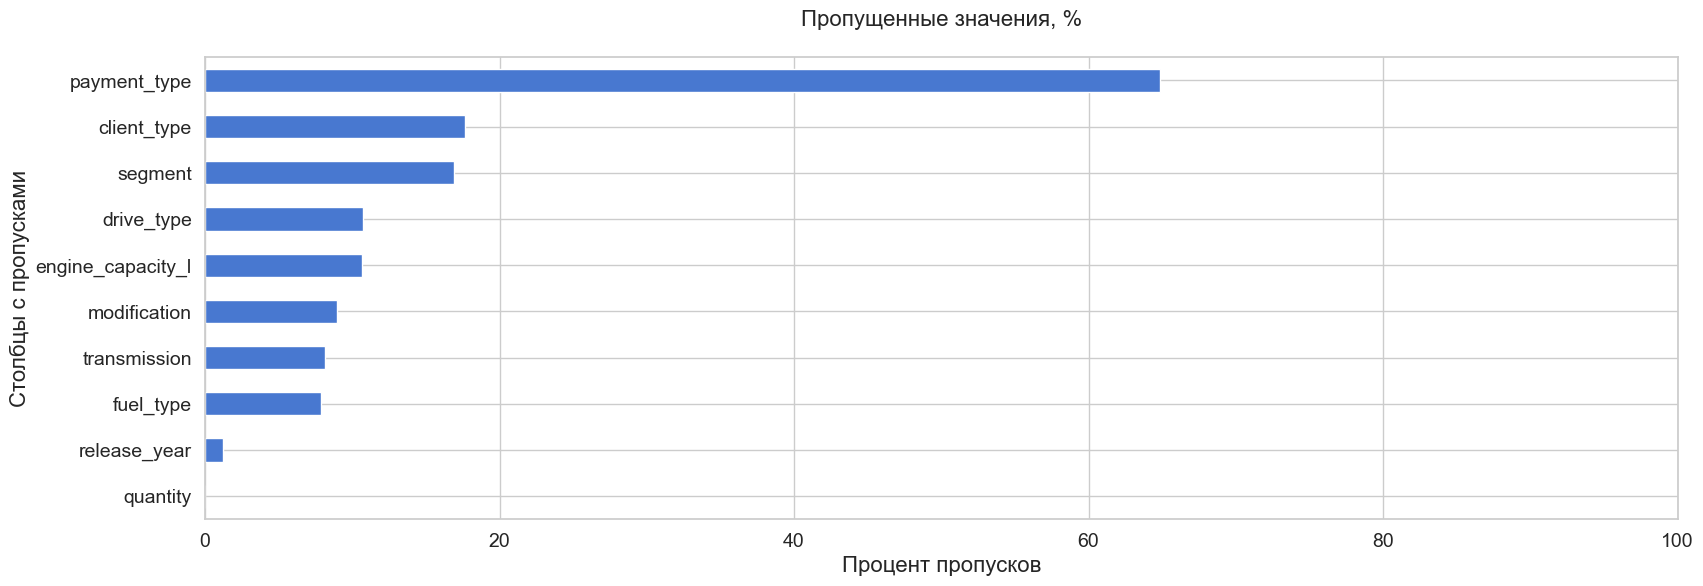

In [9]:
pass_value_barh(data)

Мы видим много пропусков в форме расчета, сегменте, типе клиента. В целях нашего анализа они не нужны. Удаляем столбцы.\
В том числе удалим столбцы, повторяющие имеющиеся: дилер, segment_eng, localization.

In [10]:
# удалим столбцы форма_расчета, сегмент, наименование_дилерского_центра, тип_клиента, сегментация_eng, локализация_производства, модификацию пока оставим
data = data.drop(columns=[
    'payment_type', 
    'segment', 
    'dealer', 
    'client_type', 
    'segment_eng', 
    'localization',
    # 'modification'
])

В датасете есть некоторое количество строк, заполненных текстовым #Н/Д, возможно, из Excel.\
Заменим это значение на пропуск, чтобы оно нам не мешало.

In [11]:
# Подсчитываем, сколько значений '#Н/Д' в таблице перед заменой
count_before = (data == '#Н/Д').sum().sum()

# Заменяем все вхождения '#Н/Д' на пропуски (NaN)
data.replace('#Н/Д', np.nan, inplace=True)

# Подсчитываем, сколько значений '#Н/Д' осталось (должно быть 0)
count_after = (data == '#Н/Д').sum().sum()

# Выводим результат
print(f"Заменено значений '#Н/Д' на NaN: {count_before - count_after}")

Заменено значений '#Н/Д' на NaN: 12


У нас большое количество пропусков в технических характеристиках. Посмотрим, в каких моделях большинство пропусков, можем ли мы заполнить данные.

In [12]:
(
    data.loc[
        data[['drive_type', 'engine_capacity_l', 'fuel_type', 'transmission']].isna().any(axis=1)
    ]
    .groupby(['company', 'brand', 'model', 'modification', 'release_year'])['price_usd']
    .count()
    .sort_values(ascending=False)
    .head(30)
)


company           brand       model        modification                                          release_year
Mercur Auto       Volkswagen  Polo         Polo Trendline MPI 81 кВт (110 л.с.), 6-АКП           2018            162
ТК КАМАЗ          KAMAZ       43118        KAMAZ 43118                                           2019            134
Renault Россия    Renault     Sandero      SXPA16PA5RB                                           2019             95
ТК КАМАЗ          KAMAZ       65115        KAMAZ 65115                                           2017             90
Renault Россия    Renault     Duster       Z2GB4AG                                               2019             89
                                           Z2GB4AGA                                              2019             88
Allur Auto        Jac         S5           Intelligent 2.0T MT6                                  2019             63
Renault Россия    Renault     Duster       Z1FB4AG                     

Мы видим, что у некоторых моделей в модификации указаны технические характеристики. Посмотрим на топ-1 по пропускам.

In [13]:
# посмотрим на топ1 по пропускам:
data[
    (data['modification'] == 'Polo Trendline MPI 81 кВт (110 л.с.), 6-АКП') & 
    (data[['drive_type']].isna().any(axis=1))
].sample(5)

year   month      company       brand model  \
37954  2019  Январь  Mercur Auto  Volkswagen  Polo   
38014  2019  Январь  Mercur Auto  Volkswagen  Polo   
38357  2019     Май  Mercur Auto  Volkswagen  Polo   
38332  2019     Май  Mercur Auto  Volkswagen  Polo   
38018  2019  Январь  Mercur Auto  Volkswagen  Polo   

                                      modification release_year  \
37954  Polo Trendline MPI 81 кВт (110 л.с.), 6-АКП         2018   
38014  Polo Trendline MPI 81 кВт (110 л.с.), 6-АКП         2018   
38357  Polo Trendline MPI 81 кВт (110 л.с.), 6-АКП         2018   
38332  Polo Trendline MPI 81 кВт (110 л.с.), 6-АКП         2018   
38018  Polo Trendline MPI 81 кВт (110 л.с.), 6-АКП         2018   

             country_origin fuel_type engine_capacity_l transmission  \
37954  Российская Федерация    Бензин               1,6          АКП   
38014  Российская Федерация    Бензин               1,6          АКП   
38357  Российская Федерация    Бензин               1,6          АКП   
38332  Российская Федерация    Бензин               1,6          АКП   
38018  Российская Федерация    Бензин               1,6          АКП   

      drive_type  region  quantity  price_usd  total_usd  province  \
37954        NaN  Алматы      1.00   14112.82   14112.82  г.Алматы   
38014        NaN  Алматы      1.00   14112.82   14112.82  г.Алматы   
38357        NaN  Алматы      1.00   14185.67   14185.67  г.Алматы   
38332        NaN  Алматы      1.00   14185.67   14185.67  г.Алматы   
38018        NaN  Алматы      1.00   13980.68   13980.68  г.Алматы   

              segment_2013 class_2013  
37954  Легковые автомобили    B класс  
38014  Легковые автомобили    B класс  
38357  Легковые автомобили    B класс  
38332  Легковые автомобили    B класс  
38018  Легковые автомобили    B класс

Пропуски только в типе привода. Мы с уверенностью можем сказать, что Volkswagen Polo Trendline бывает только с передним приводом.\
Проведем такой же анализ для остальных авто и создадим словарь для заполнения.


In [14]:
print('Количество строк с пропусками в технических характеристиках:')
data[
    data[['drive_type', 'engine_capacity_l', 'fuel_type', 'transmission']].isna().any(axis=1)
].shape[0]


Количество строк с пропусками в технических характеристиках:


5071

In [15]:
# у Renault в модификации лишние пробелы, уберем их:
mask = data['brand'] == 'Renault'
data.loc[mask, 'modification'] = (
    data.loc[mask, 'modification']
    .astype(str)
    .str.upper()
    .str.replace(r'\s+', '', regex=True)  # полностью убираем все пробелы
)

# Общие правила по бренду и модели
fill_rules = {
    ('Renault Россия', 'Renault', 'Sandero'): {
        'drive_type': 'передний',
        'fuel_type': 'бензин'
    },
    ('Renault Россия', 'Renault', 'Logan'): {
        'drive_type': 'передний',
        'fuel_type': 'бензин'
    },
    ('Renault Россия', 'Renault', 'Duster'): {
        'fuel_type': 'бензин'
    },
    ('Renault Россия', 'Renault', 'Kaptur'): {
        'fuel_type': 'бензин'
    },
    ('Mercur Auto', 'Volkswagen', 'Polo'): {
        'drive_type': 'передний',
        'fuel_type': 'бензин'
    },
    ('Равон Моторс Казахстан', 'Ravon', 'Nexia R3'): {
        'drive_type': 'передний',
        'fuel_type': 'бензин'
    },
    ('УзАвто-Казахстан', 'Ravon', 'Nexia R3'): {
        'drive_type': 'передний',
        'fuel_type': 'бензин'
    },
    ('ТК КАМАЗ', 'KAMAZ', '43118'): {
        'drive_type': 'полный',
        'fuel_type': 'дизель',
        'engine_capacity_l': 10.85
    },
    ('ТК КАМАЗ', 'KAMAZ', '6520'): {
        'engine_capacity_l': 11.76
    },
        ('ТК КАМАЗ', 'KAMAZ', '45143'): {
        'engine_capacity_l': 10.85
    },
    ('ТК КАМАЗ', 'KAMAZ', '65115'): {
        'drive_type': 'задний',
        'fuel_type': 'дизель',
        'engine_capacity_l': 10.85
    },
    ('Allur Auto', 'Jac', 'S3'): {
        'drive_type': 'передний',
        'fuel_type': 'бензин'
    },
    ('Allur Auto', 'Jac', 'S5'): {
        'drive_type': 'передний',
        'fuel_type': 'бензин'
    },
    ('Allur Auto', 'ANKAI', 'HFF6850G'): {
        'drive_type': 'задний',
        'fuel_type': 'дизель'
    },
    ('Вираж', 'GAZ', '3302'): {
        'drive_type': 'задний'
    },
    ('Вираж', 'GAZ', 'Next'): {
        'drive_type': 'задний'
    },
    ('СВС-ТРАНС', 'Isuzu', 'NMR'): {
        'drive_type': 'задний',
        'fuel_type': 'дизель'
    }
}

# Специфические правила по модификации
modification_rules = {
    # Renault Sandero
    ('Renault Россия', 'Renault', 'Sandero', 'SXPA16PA5RB'): {
        'transmission': 'автоматическая', 'engine_capacity_l': 1.6, 'drive_type': '2WD'
    },
    ('Renault Россия', 'Renault', 'Sandero', 'CXPA16MV5RB'): {
        'transmission': 'механическая', 'engine_capacity_l': 1.6, 'drive_type': '2WD'
    },
    ('Renault Россия', 'Renault', 'Sandero', 'SXPA16M5RB'): {
        'transmission': 'механическая', 'engine_capacity_l': 1.6, 'drive_type': '2WD'
    },
    ('Renault Россия', 'Renault', 'Sandero', 'SUTA16PA5RB'): {
        'transmission': 'автоматическая', 'engine_capacity_l': 1.6, 'drive_type': '2WD'
    },
    ('Renault Россия', 'Renault', 'Sandero', 'CUTA16MV5RB'): {
        'transmission': 'механическая', 'engine_capacity_l': 1.6, 'drive_type': '2WD'
    },
    ('Renault Россия', 'Renault', 'Sandero', 'SXPA16K5RB'): {
        'engine_capacity_l': 1.6, 'drive_type': '2WD'
    },
    ('Renault Россия', 'Renault', 'Sandero', 'SUTA16M5RB'): {
        'engine_capacity_l': 1.6, 'drive_type': '2WD'
    },
    ('Renault Россия', 'Renault', 'Sandero', 'SUTA16K5RB'): {
        'engine_capacity_l': 1.6, 'drive_type': '2WD'
    },
    ('Renault Россия', 'Renault', 'Sandero', 'STW16PA5RB'): {
        'engine_capacity_l': 1.6, 'drive_type': '2WD'
    },
    ('Renault Россия', 'Renault', 'Sandero', 'ACCA16K5RB'): {
        'engine_capacity_l': 1.6, 'drive_type': '2WD'
    },
    ('Renault Россия', 'Renault', 'Sandero', 'SXPA16K5RB'): {
        'engine_capacity_l': 1.6, 'drive_type': '2WD'
    },
    ('Renault Россия', 'Renault', 'Sandero', 'SUTA16K5RB'): {
        'engine_capacity_l': 1.6, 'drive_type': '2WD'
    },
    ('Renault Россия', 'Renault', 'Sandero', 'SUTA16M5RB'): {
        'engine_capacity_l': 1.6, 'drive_type': '2WD'
    },
    ('Renault Россия', 'Renault', 'Sandero', 'STW16PA5RB'): {
        'engine_capacity_l': 1.6, 'drive_type': '2WD'
    },
    ('Renault Россия', 'Renault', 'Sandero', 'ACCA16K5RB'): {
        'engine_capacity_l': 1.6, 'drive_type': '2WD'
    },

    # Renault Dokker
    ('Renault Россия', 'Renault', 'Dokker', 'YKLAURMVEM'): {
        'engine_capacity_l': 1.6, 'drive_type': '2WD'
    },

    # Renault Arkana
    ('Renault Россия', 'Renault', 'Arkana', 'B32M1TX5C'): {
        'engine_capacity_l': 1.6, 'drive_type': '2WD'
    },
    ('Renault Россия', 'Renault', 'Arkana', 'B22M1TX5C'): {
        'engine_capacity_l': 1.3, 'drive_type': '2WD'
    },

    # Renault Logan
    ('Renault Россия', 'Renault', 'Logan', 'AUTA16K5RB'): {
        'transmission': 'автоматическая', 'engine_capacity_l': 1.6, 'drive_type': '2WD'
    },
    ('Renault Россия', 'Renault', 'Logan', 'CXPA16MV5RB'): {
        'engine_capacity_l': 1.6, 'drive_type': '2WD'
    },
    ('Renault Россия', 'Renault', 'Logan', 'ACCA16K5RB'): {
        'engine_capacity_l': 1.6, 'drive_type': '2WD'
    },
    ('Renault Россия', 'Renault', 'Logan', 'EXPA16K5RB'): {
        'engine_capacity_l': 1.6, 'drive_type': '2WD'
    },
    ('Renault Россия', 'Renault', 'Logan', 'CUTA16MV5RB'): {
        'engine_capacity_l': 1.6, 'drive_type': '2WD'
    },
    ('Renault Россия', 'Renault', 'Logan', 'SXPA16M5RB'): {
        'engine_capacity_l': 1.6, 'drive_type': '2WD'
    },
    ('Renault Россия', 'Renault', 'Logan', 'DYNA16PA5RB'): {
        'engine_capacity_l': 1.6, 'drive_type': '2WD'
    },
    ('Renault Россия', 'Renault', 'Logan', 'AUTA16PA5RB'): {
        'engine_capacity_l': 1.6, 'drive_type': '2WD'
    },
    ('Renault Россия', 'Renault', 'Logan', 'SUTA16PA5RB'): {
        'engine_capacity_l': 1.6, 'drive_type': '2WD'
    },
    ('Renault Россия', 'Renault', 'Logan', 'CXPA16MV5RB'): {
        'engine_capacity_l': 1.6, 'drive_type': '2WD'
    },
    ('Renault Россия', 'Renault', 'Logan', 'ACCA16K5RB'): {
        'engine_capacity_l': 1.6, 'drive_type': '2WD'
    },
    ('Renault Россия', 'Renault', 'Logan', 'EXPA16K5RB'): {
        'engine_capacity_l': 1.6, 'drive_type': '2WD'
    },
    ('Renault Россия', 'Renault', 'Logan', 'CUTA16MV5RB'): {
        'engine_capacity_l': 1.6, 'drive_type': '2WD'
    },
    ('Renault Россия', 'Renault', 'Logan', 'SXPA16M5RB'): {
        'engine_capacity_l': 1.6, 'drive_type': '2WD'
    },
    ('Renault Россия', 'Renault', 'Logan', 'DYNA16PA5RB'): {
        'engine_capacity_l': 1.6, 'drive_type': '2WD'
    },
    ('Renault Россия', 'Renault', 'Logan', 'AUTA16PA5RB'): {
        'engine_capacity_l': 1.6, 'drive_type': '2WD'
    },
    ('Renault Россия', 'Renault', 'Logan', 'SUTA16PA5RB'): {
        'engine_capacity_l': 1.6, 'drive_type': '2WD'
    },

    # Renault Kaptur
    ('Renault Россия', 'Renault', 'Kaptur', 'ZB34AAA5C'): {
        'transmission': 'автоматическая', 'engine_capacity_l': 2.0, 'drive_type': '4WD'
    },
    ('Renault Россия', 'Renault', 'Kaptur', 'MB34AAA5C'): {
        'engine_capacity_l': 1.6, 'drive_type': '4WD'
    },
    ('Renault Россия', 'Renault', 'Kaptur', 'PLY4AAA5C'): {
        'engine_capacity_l': 1.6, 'drive_type': '4WD'
    },
    ('Renault Россия', 'Renault', 'Kaptur', 'ZB12JAX5C'): {
        'engine_capacity_l': 1.2, 'drive_type': '4WD'
    },
    ('Renault Россия', 'Renault', 'Kaptur', 'MB12JAX5C'): {
        'engine_capacity_l': 1.2, 'drive_type': '4WD'
    },

    # Ravon Nexia
    ('УзАвто-Казахстан', 'Ravon', 'Nexia R3', 'ELEGANT AT'): {
        'transmission': 'автоматическая', 'engine_capacity_l': 1.5
    },

    # Jac
    ('Allur Auto', 'Jac', 'S5', 'Intelligent 2.0T MT6'): {
        'transmission': 'механическая', 'engine_capacity_l': 2.0
    },
    ('Allur Auto', 'Jac', 'S3', 'Intelligent 1.6 CVT'): {
        'transmission': 'автоматическая', 'engine_capacity_l': 1.6
    },
    ('Allur Auto', 'Jac', 'S3', 'Luxury'): {
        'transmission': 'автоматическая'
    },
    ('Allur Auto', 'Jac', 'S5', 'FL Intelligent'): {
        'transmission': 'автоматическая'
    },

    # Shacman
    ('СемАЗ', 'Shacman', 'SX3258DR384', 'Автомобиль-самосвал SHACMAN Евро5 модель SX3258DR384'): {
        'transmission': 'механическая'
    },

    # Renault Duster
    ('Renault Россия', 'Renault', 'Duster', 'Z2GB4AG'): {
        'transmission': 'механическая', 'engine_capacity_l': 2.0, 'drive_type': '4WD'
    },
    ('Renault Россия', 'Renault', 'Duster', 'Z2GB4AGA'): {
        'transmission': 'автоматическая', 'engine_capacity_l': 2.0, 'drive_type': '4WD'
    },
    ('Renault Россия', 'Renault', 'Duster', 'Z1FB4AG'): {
        'transmission': 'механическая', 'engine_capacity_l': 2.0, 'drive_type': '4WD'
    },
    ('Renault Россия', 'Renault', 'Duster', 'Z1FB4AGA'): {
        'transmission': 'автоматическая', 'engine_capacity_l': 2.0, 'drive_type': '4WD'
    },
    ('Renault Россия', 'Renault', 'Duster', 'Z2PGB4AGA'): {
        'transmission': 'автоматическая', 'engine_capacity_l': 2.0, 'drive_type': '4WD'
    },
    ('Renault Россия', 'Renault', 'Duster', 'Z2PGB4AG'): {
        'transmission': 'механическая', 'engine_capacity_l': 2.0, 'drive_type': '4WD'
    },
    ('Renault Россия', 'Renault', 'Duster', 'ADGB4AG'): {
        'engine_capacity_l': 1.6, 'drive_type': '2WD', 'transmission': 'механическая'
    },
    ('Renault Россия', 'Renault', 'Duster', 'ADGB4AGA'): {
        'engine_capacity_l': 1.6, 'drive_type': '2WD', 'transmission': 'автоматическая'
    },
    ('Renault Россия', 'Renault', 'Duster', 'Z1FB2JA'): {
        'engine_capacity_l': 1.5, 'drive_type': '4WD'
    },
    ('Renault Россия', 'Renault', 'Duster', 'E2GB4AGA'): {
        'engine_capacity_l': 1.6, 'drive_type': '2WD', 'transmission': 'автоматическая'
    },
    ('Renault Россия', 'Renault', 'Duster', 'E2GB4AG'): {
        'engine_capacity_l': 1.6, 'drive_type': '2WD', 'transmission': 'механическая'
    },
    ('Renault Россия', 'Renault', 'Duster', 'Z0DB2JA'): {
        'engine_capacity_l': 1.5, 'drive_type': '2WD'  # дизель
    },
    ('Renault Россия', 'Renault', 'Duster', 'DKGB4AG'): {
        'engine_capacity_l': 1.6, 'drive_type': '2WD', 'transmission': 'механическая'
    },
    ('Renault Россия', 'Renault', 'Duster', 'DKGB4AGA'): {
        'engine_capacity_l': 1.6, 'drive_type': '2WD', 'transmission': 'автоматическая'
    },

}

# Счётчики
filled_counts = {col: 0 for col in ['drive_type', 'engine_capacity_l', 'fuel_type', 'transmission']}
total_filled = 0

# Основной цикл заполнения
for idx, row in data.iterrows():
    key3 = (row['company'], row['brand'], row['model'])
    key4 = (row['company'], row['brand'], row['model'], row['modification'])

    # Общие правила
    if key3 in fill_rules:
        for col, value in fill_rules[key3].items():
            if pd.isna(row[col]):
                data.at[idx, col] = value
                filled_counts[col] += 1
                total_filled += 1

    # Модификационные правила
    if key4 in modification_rules:
        for col, value in modification_rules[key4].items():
            if pd.isna(row[col]):
                data.at[idx, col] = value
                filled_counts[col] += 1
                total_filled += 1

# Вывод статистики
print("═" * 50)
print("СТАТИСТИКА ЗАПОЛНЕНИЯ ПРОПУСКОВ")
print("═" * 50)
for col, count in filled_counts.items():
    print(f"{col:<20} | Заполнено пропусков: {count}")
print("═" * 50)
print(f"ИТОГО: {total_filled} пропусков заполнено")
print("═" * 50)

# Проверка оставшихся пропусков
remaining_nulls = data[['drive_type', 'engine_capacity_l', 'fuel_type', 'transmission']].isna().sum()
print("\nОСТАВШИЕСЯ ПРОПУСКИ:")
print(remaining_nulls.to_string())

══════════════════════════════════════════════════
СТАТИСТИКА ЗАПОЛНЕНИЯ ПРОПУСКОВ
══════════════════════════════════════════════════
drive_type           | Заполнено пропусков: 3655
engine_capacity_l    | Заполнено пропусков: 2154
fuel_type            | Заполнено пропусков: 2245
transmission         | Заполнено пропусков: 1311
══════════════════════════════════════════════════
ИТОГО: 9365 пропусков заполнено
══════════════════════════════════════════════════

ОСТАВШИЕСЯ ПРОПУСКИ:
drive_type           1243
engine_capacity_l    2108
fuel_type             895
transmission         1948


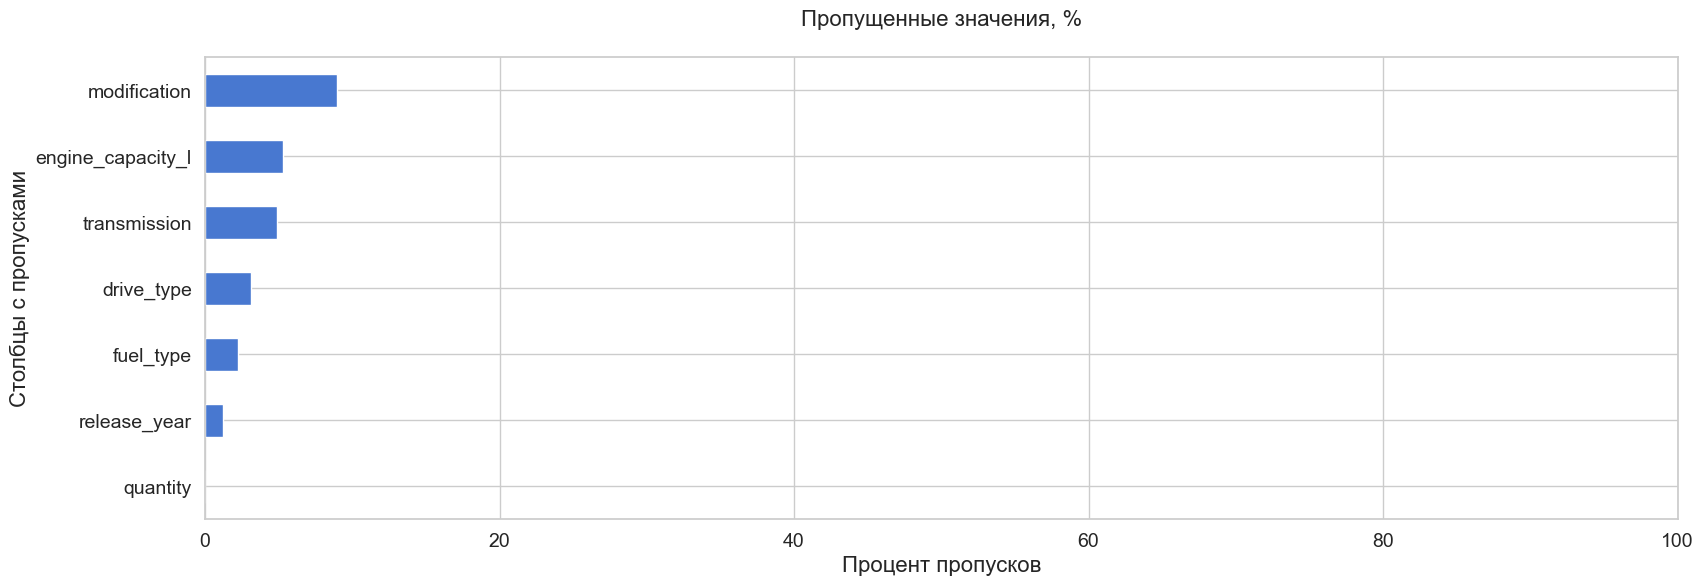

In [16]:
# повторно проверим количество пропусков
pass_value_barh(data)

Мы видим, количество пропусков существенно снизилось. Осталось много в столбце `modification`, но он нам больше не нужен, уберем его.

In [17]:
# удалим модификацию, теперь она не нужна:
data = data.drop(columns=[
    'modification'
])

Удалим оставшиеся пропуски

In [18]:
# Количество строк до удаления
before = data.shape[0]

# Удаляем строки с любыми пропусками
data = data.dropna(how='any')

# Количество строк после удаления
after = data.shape[0]

# Разница и доля потерь
removed = before - after
loss_pct = removed / before * 100

print(f'Было строк: {before}')
print(f'Удалено строк с пропусками: {removed} ({loss_pct:.2f}%)')
print(f'Осталось строк: {after}')


Было строк: 39966
Удалено строк с пропусками: 3130 (7.83%)
Осталось строк: 36836


### Дубликаты

In [19]:
# проверим дубликаты
data.duplicated().sum()

21428

По информации от заказчика, явные дубликаты таковыми не являются, это корректные данные, которые стали определяться как повторы.\
Оставляем.

## Чистка данных

### Страна производства

Кодируем страны в столбце страна производства в alpha3 (RUS, KAZ, USA и т.д.)

In [20]:
# выгрузим список стран с сайта
countries = pd.read_table('https://www.artlebedev.ru/country-list/tab/')

In [21]:
# посмотрим на случайные значения, чтобы узнать названия столбцов и корректность выгрузки
countries.sample(3)

name              fullname           english alpha2  \
225  Французская Полинезия                   NaN  French Polynesia     PF   
147                   Оман         Султанат Оман              Oman     OM   
145               Норвегия  Королевство Норвегия            Norway     NO   

    alpha3  iso location location-precise  
225    PYF  258  Океания        Полинезия  
147    OMN  512     Азия    Западная Азия  
145    NOR  578   Европа  Северная Европа

Для кодирования используем метод замены по словарю - мы объединяем два столбца датасета: название страны будет ключом, код - значением. Метод zip сшивает два столбца в массив кортежей, к которому мы применяем dict, таким образом создаем словарь, то же самое мы проделаем для полных названий

In [22]:
# Создание словарей для быстрого доступа к кодам стран
name_dict = dict(zip(countries['name'], countries['alpha3']))
full_name_dict = dict(zip(countries['fullname'], countries['alpha3']))

Посмотрим на список стран в нашем датасете

In [23]:
# Список уникальных стран производителей
data['country_origin'].value_counts().reset_index().rename(columns={'count': 'количество'})

country_origin  количество
0   Республика Казахстан       17951
1   Российская Федерация       11289
2                 Япония        4591
3                 Турция        1165
4                Таиланд         884
5                    США         289
6               Германия         242
7                     UK         189
8                  Китай          77
9             Узбекистан          69
10               Австрия          33
11                 Корея          17
12                Швеция          16
13               Испания           9
14               Бельгия           6
15                Польша           6
16               Венгрия           2
17            Белоруссия           1

У нас:
- UK вместо Соединенного Королевства,
- Корея вместо Республика Корея,
- США вместо Соединенные Штаты Америки,
- Белоруссия вместо Беларусь. 

Заменим.

In [24]:
# Заменим UK на Соединенное Королевство
data['country_origin'] = data['country_origin'].str.replace('UK', 'Соединенное Королевство')
data['country_origin'] = data['country_origin'].str.replace('Корея', 'Республика Корея')
data['country_origin'] = data['country_origin'].str.replace('Белоруссия', 'Беларусь')
data['country_origin'] = data['country_origin'].str.replace('США', 'Соединенные Штаты Америки')

In [25]:
# Применяем оба словаря для замены кодов стран
data['country_origin'] = data['country_origin'].map(
    lambda x: name_dict.get(x, full_name_dict.get(x, x)))

In [26]:
# Список уникальных стран производителей
data['country_origin'].value_counts().reset_index().rename(columns={'count': 'количество'})

country_origin  количество
0             KAZ       17951
1             RUS       11289
2             JPN        4591
3             TUR        1165
4             THA         884
5             USA         289
6             DEU         242
7             GBR         189
8             CHN          77
9             UZB          69
10            AUT          33
11            KOR          17
12            SWE          16
13            ESP           9
14            BEL           6
15            POL           6
16            HUN           2
17            BLR           1

Все страны закодированы, большинство произведено в Казахстане.\
Из Беларуси всего 1 автомобиль.

### Тип топлива

Кодируем тип топлива в (F - fuel, D - diesel, E - electro, HYB - hybrid) для экономии места и ускорения расчетов.

In [27]:
# список значений типа топлива
data['fuel_type'].value_counts().reset_index().rename(columns={'count': 'количество'})

fuel_type  количество
0     Бензин       34367
1     бензин        1128
2     Дизель        1069
3    бензин          159
4    дизель           41
5          2          23
6     дизель          19
7        1,6          14
8     гибрид          10
9          0           3
10   Электро           3

In [28]:
# посмотрим на строки с нетипичными данными по топливу
display(data.loc[data['fuel_type'].isin(['2', '1,6', '0'])])

print('=' * 30)
print(f"Общее количество пропусков: {data.loc[data['fuel_type'].isin(['2', '1,6', '0'])].shape[0]}")


year   month         company    brand    model release_year  \
23723  2019  Январь  Renault Россия  Renault   Duster         2019   
23724  2019  Январь  Renault Россия  Renault   Duster         2018   
23725  2019  Январь  Renault Россия  Renault   Duster         2018   
23726  2019  Январь  Renault Россия  Renault   Duster         2018   
23727  2019  Январь  Renault Россия  Renault   Duster         2018   
23728  2019  Январь  Renault Россия  Renault   Duster         2018   
23729  2019  Январь  Renault Россия  Renault   Duster         2018   
23730  2019  Январь  Renault Россия  Renault   Duster         2018   
23731  2019  Январь  Renault Россия  Renault   Duster         2018   
23732  2019  Январь  Renault Россия  Renault   Duster         2018   
23733  2019  Январь  Renault Россия  Renault   Duster         2018   
23734  2019  Январь  Renault Россия  Renault   Duster         2018   
23735  2019  Январь  Renault Россия  Renault   Duster         2018   
23736  2019  Январь  Renault Россия  Renault   Duster         2018   
23746  2019  Январь  Renault Россия  Renault   Duster         2018   
23747  2019  Январь  Renault Россия  Renault   Duster         2018   
23748  2019  Январь  Renault Россия  Renault   Duster         2018   
23749  2019  Январь  Renault Россия  Renault   Duster         2018   
23750  2019  Январь  Renault Россия  Renault   Duster         2018   
23751  2019  Январь  Renault Россия  Renault   Duster         2018   
23752  2019  Январь  Renault Россия  Renault   Duster         2018   
23753  2019  Январь  Renault Россия  Renault   Duster         2018   
23754  2019  Январь  Renault Россия  Renault   Duster         2018   
23755  2019  Январь  Renault Россия  Renault   Duster         2018   
23758  2019  Январь  Renault Россия  Renault   Duster         2018   
23759  2019  Январь  Renault Россия  Renault   Duster         2018   
23760  2019  Январь  Renault Россия  Renault   Duster         2018   
23761  2019  Январь  Renault Россия  Renault   Duster         2018   
23762  2019  Январь  Renault Россия  Renault   Duster         2018   
23763  2019  Январь  Renault Россия  Renault   Duster         2018   
23764  2019  Январь  Renault Россия  Renault   Duster         2018   
23765  2019  Январь  Renault Россия  Renault   Duster         2018   
24997  2019  Январь  Renault Россия  Renault  Sandero         2018   
24998  2019  Январь  Renault Россия  Renault  Sandero         2018   
24999  2019  Январь  Renault Россия  Renault  Sandero         2018   
25002  2019  Январь  Renault Россия  Renault  Sandero         2018   
25023  2019  Январь  Renault Россия  Renault  Sandero         2018   
37121  2019  Январь      БИПЭК АВТО      UAZ     3741         2018   
37122  2019  Январь      БИПЭК АВТО      UAZ     3741         2018   
37123  2019  Январь      БИПЭК АВТО      UAZ     3741         2018   

      country_origin fuel_type engine_capacity_l transmission drive_type  \
23723            RUS         2                MT          4WD        4WD   
23724            RUS         2                AT          4WD        4WD   
23725            RUS         2                AT          4WD        4WD   
23726            RUS         2                AT          4WD        4WD   
23727            RUS         2                MT          4WD        4WD   
23728            RUS       1,6                MT          4WD        4WD   
23729            RUS         2                AT          4WD        4WD   
23730            RUS         2                AT          4WD        4WD   
23731            RUS         2                MT          4WD        4WD   
23732            RUS         2                MT          4WD        4WD   
23733            RUS       1,6                MT          4WD        4WD   
23734            RUS       1,6                AT     Передний   Передний   
23735            RUS       1,6                AT     Передний   Передний   
23736            RUS       1,6                AT     Передний   Передний

Общее количество пропусков: 40


Мы  видим, что в данных отсутствует информация о типе топлива, 40 строк, удаляем.

In [29]:
# удалим строки с неверно заполненным типом топлива
data = data.loc[~data['fuel_type'].isin(['2', '1,6', '0'])]

Для экономии места кодируем тип топлива

In [30]:
# Кодируем тип топлива в (F - fuel, D - diesel, E - electro, HYB - hybrid
def encode_fuel_type(fuel):
    value = str(fuel).lower().strip()
    if value == 'бензин':
        return 'F'
    if value == 'дизель':
        return 'D'
    if value == 'электро' or value == 'электричество':
        return 'E'
    if value == 'гибрид':
        return 'HYB'
    return fuel

In [31]:
data.loc[:, 'fuel_type'] = data['fuel_type'].apply(encode_fuel_type)

In [32]:
# отобразим список авто по виду топлива
data['fuel_type'].value_counts()

fuel_type
F      35654
D       1129
HYB       10
E          3
Name: count, dtype: int64

### Тип привода

Удаляем неявные дубликаты в типе привода

In [33]:
# посмотрим уникальные значения в столбце тип_привода
print("Уникальные значения до обработки:")
print(data['drive_type'].unique())

Уникальные значения до обработки:
['передний' 'FWD' 'quattro' 'Задний' 'Полный' 'AWD' 'Передний' '4WD'
 '4х2.2' 'RWD' '2 WD' '2WD' '4 WD' 'полный' 'задний' '4X2' 'Передний (FF)'
 '0' 'FF' '4Motion']


Из аномальных значений у нас появился 0. Посмотрим, что это за автомобили и можем ли мы заменить значения.

In [34]:
# посмотрим, в каких моделях указаны 0
data.loc[data['drive_type'].isin(['0'])].groupby(
    ['brand', 'model', 'country_origin', 'release_year', 'fuel_type', 'engine_capacity_l', 'transmission']
)['drive_type'].count().head(10).reset_index()

brand    model country_origin release_year fuel_type  engine_capacity_l  \
0  Renault   Duster            RUS         2018         F               1.60   
1  Renault   Duster            RUS         2018         F               1.60   
2  Renault   Kaptur            RUS         2018         F               2.00   
3  Renault  Sandero            RUS         2018         F               1.60   

     transmission  drive_type  
0  автоматическая          10  
1    механическая           1  
2  автоматическая          18  
3  автоматическая          20

Мы можем гарантированно считать, что Рено с двигателем 2л - полноприводные, а 1.6 - 2wd.\
Заполним

In [35]:
# Правила для типа привода
drive_type_rules = {
    # Duster
    ('Renault', 'Duster', 'RUS', '2018', 'F', 1.6, 'автоматическая'): '2WD',
    ('Renault', 'Duster', 'RUS', '2018', 'F', 1.6, 'механическая'): '2WD',
    
    # Kaptur
    ('Renault', 'Kaptur', 'RUS', '2018', 'F', 2.0, 'автоматическая'): '4WD',
    
    # Sandero
    ('Renault', 'Sandero', 'RUS', '2018', 'F', 1.6, 'автоматическая'): '2WD'
}

# Создаем маску для строк с drive_type == '0'
mask = data['drive_type'] == '0'

# Для строк с mask формируем ключи для словаря
keys = list(zip(
    data.loc[mask, 'brand'],
    data.loc[mask, 'model'],
    data.loc[mask, 'country_origin'],
    data.loc[mask, 'release_year'],
    data.loc[mask, 'fuel_type'],
    data.loc[mask, 'engine_capacity_l'],
    data.loc[mask, 'transmission']
))

# Счётчик успешных замен
replaced_count = 0

# Обходим индексы и ключи, заменяем по словарю
for idx, key in zip(data.loc[mask].index, keys):
    if key in drive_type_rules:
        data.at[idx, 'drive_type'] = drive_type_rules[key]
        replaced_count += 1

# Вывод результата
print(f'Заменено drive_type "0" на значение из правил: {replaced_count}')


Заменено drive_type "0" на значение из правил: 49


Переводим в нижний регистр и убираем лишние пробелы

In [36]:
def normalize_drive_type(val):
    """
    Стандартизирует тип привода, разделяя значения на две категории:
    - '4WD' для полного привода,
    - '2WD' для приводов на два колеса (передний или задний).
    
    Если значение отсутствует (NaN), возвращает 'неизвестно'.
    Все остальные значения возвращает без изменений для дальнейшего анализа.
    
    Параметры:
        val (str или NaN): исходное значение типа привода.
        
    Возвращает:
        str: стандартизированный тип привода ('4WD', '2WD', 'неизвестно' или исходное значение).
    """
    if pd.isna(val):
        return 'неизвестно'
    
    val_str = str(val).lower().strip().replace(' ', '')
    
    if val_str in ['quattro', 'awd', '4wd', '4x4', '4х4', '4motion', 'полный']:
        return '4WD'
    elif val_str in ['передний', 'задний', '2wd', '4x2', '4х2', 'передний(ff)', 'ff', 'rwd', 'fwd', '4х2.2']:
        return '2WD'
    else:
        return val  # оставляем как есть для дальнейшего анализа


Уникальные значения после обработки:
['2WD' '4WD']


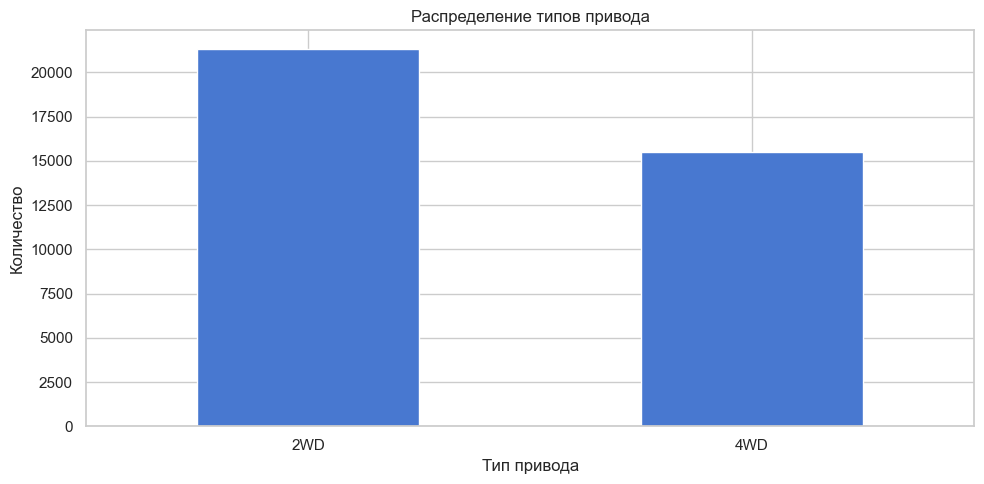

In [37]:
# Применяем к столбцу
data['drive_type'] = data['drive_type'].map(normalize_drive_type)

# проверим результат
print("\nУникальные значения после обработки:")
print(data['drive_type'].unique())

# построим график распределения типов привода
plt.figure(figsize=(10, 5))
data['drive_type'].value_counts().plot(
    kind='bar',
    title='Распределение типов привода',
    xlabel='Тип привода',
    ylabel='Количество'
)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

Мы видим, что большинство автомобилей имеют одну ведущую ось. Однако полноприводные авто отстают не сильно - занимают почти 40% рынка.

### Коробка передач

Тип трансмиссии - убираем неявные дубликаты (для простоты оставим два типа трансмиссии: механика и автомат)

In [38]:
# получим список уникальных значений в столбце 'коробка_передач'
[val.lower().strip() if isinstance(val, str) else val for val in data['transmission'].unique()]


['s-tronic',
 's-tronic',
 'tiptronic',
 'акпп',
 'акп',
 'steptronic',
 'at',
 '6 ат',
 '5 мт',
 '6ат',
 'mt',
 '8at',
 '5мт',
 'powershift s6',
 '6at',
 'мех.',
 '6 at',
 '6 mt',
 '6mt',
 '5 at',
 '5at',
 'мкпп',
 '7 dct',
 '7dct',
 '8 at',
 'мт',
 'автоматическая',
 'cvt',
 'dct',
 'механическая',
 '4 ат',
 '6 мт',
 '6мт',
 '4ат',
 '4at',
 '8ат',
 '8 ат',
 '5mt',
 'amt',
 'cvt (вариатор)',
 'cvt (вариatор)',
 'cvt(вaриatор)',
 '7g-tronic',
 '9g-tronic',
 '12at',
 '12ат',
 '5ат',
 '7ат',
 '7at',
 '6m/t',
 'pdk',
 '8-ступ акпп',
 '8',
 '8акпп',
 '8 акпп tiptronic s',
 '7 акпп (pdk)',
 '7 акпп pdk',
 '8 акпп (pdk)',
 'ат',
 'аt',
 'мt',
 '7 dsg',
 '7dsg',
 '6 dsg',
 '6dsg',
 'dsg',
 '6a',
 '6а',
 '5m',
 'a/t',
 'm/t',
 'мкп',
 '5м',
 'м/t',
 '7 акп',
 '7акп',
 'а/t',
 '8a',
 'tdi',
 '9at',
 'редуктор']

Из неизвестного здесь "редуктор". Проверим, можем ли мы однозначно определить коробку передач.

In [39]:
# отфильтруем редуктор
data.loc[data['transmission'] == 'РЕДУКТОР']

year    month                company   brand   model release_year  \
39544  2019  Февраль  Almaty Motors Premium  Jaguar  I-Pace         2019   
39545  2019   Апрель  Almaty Motors Premium  Jaguar  I-Pace         2019   
39546  2019     Июнь  Almaty Motors Premium  Jaguar  I-Pace         2019   

      country_origin fuel_type engine_capacity_l transmission drive_type  \
39544            GBR         E          400 Л.С.     РЕДУКТОР        4WD   
39545            GBR         E          400 Л.С.     РЕДУКТОР        4WD   
39546            GBR         E          400 Л.С.     РЕДУКТОР        4WD   

       region  quantity  price_usd  total_usd  province  segment_2013  \
39544  Алматы      1.00  117236.97  117236.97  г.Алматы  Внедорожники   
39545  Алматы      1.00  105388.79  105388.79  г.Алматы  Внедорожники   
39546  Алматы      1.00  120413.28  120413.28  г.Алматы  Внедорожники   

           class_2013  
39544  Компактные SUV  
39545  Компактные SUV  
39546  Компактные SUV

Мы видим, что редуктор указан для электрокаров. Можем заменить на "автомат", так как:
- Водитель управляет I-Pace как обычным авто с "автоматом" (селектор D/R/N).
- В маркетинговых материалах Jaguar называет это Automatic Transmission.

Хотя корректно было бы оставить и как редуктор, но в целях нашего исследования 3 автомобиля с редуктором не дадут значимых результатов. 

In [40]:
def classify_transmission(transmission):
    """
    Классифицирует тип трансмиссии: 'механическая', 'автоматическая', оставляет как есть для неизвестных.
    """

    if pd.isna(transmission):
        return 'неизвестно'

    transmission = str(transmission).lower().strip()

    # Словари ключевых фрагментов
    manual_keywords = [
        'mt', 'мт', 'мкп', 'мкпп', 'м/т', 'm/t', 'мех',
        '5м', '5m', '6м', 'мt', 'м/t', 'tdi'  # добавили все варианты
    ]
    auto_keywords = [
        'ат', 'акп', 'акпп', 'at', 'a/t', 'а/t', 'steptronic', 'tiptronic',
        'dsg', 's-tronic', 's tronic', 'cvt', 'вариатор', 'amt',
        'pdk', 'powershift', 'g-tronic', 'ступ акпп', 'dct',
        '6a', '6а', '8a', 'аt', 'редуктор', '8'
    ]

    if any(keyword in transmission for keyword in manual_keywords):
        return 'M'

    if any(keyword in transmission for keyword in auto_keywords):
        return 'A'

    return transmission


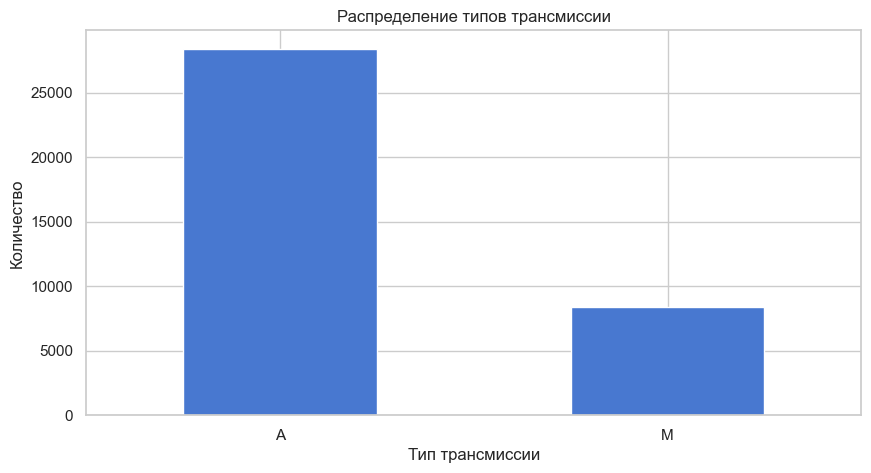

In [41]:
data['transmission'] = data['transmission'].apply(classify_transmission)

data['transmission'].value_counts().plot(
    kind='bar',
    figsize=(10, 5),
    title='Распределение типов трансмиссии',
    xlabel='Тип трансмиссии',
    ylabel='Количество',
)
plt.xticks(rotation=0)
plt.show()

### Стоимость, количество, итоговая стоимость

Приводим к числовому типу столбцы:
- `стоимость`
- `количество`
- `итоговая стоимость`  
*(если количество = 0 или -1 — возможен возврат; массовые продажи — скорее всего таксопарки)*


In [42]:
data[['price_usd', 'quantity', 'total_usd']].info()

<class 'pandas.core.frame.DataFrame'>
Index: 36796 entries, 0 to 39950
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   price_usd  36796 non-null  float64
 1   quantity   36796 non-null  float64
 2   total_usd  36796 non-null  float64
dtypes: float64(3)
memory usage: 2.1 MB


Проверим, можем ли мы перевести цену и общую стоимость в целочисленный формат.\
Если в большом количестве продаж цены с дробями, то при округлении мы получим искаженные данные.\
Если же остатков нет или мало, то можем изменить тип на int64.

In [43]:
# Проверяем, есть ли дробная часть
has_fraction_price = ~((data['price_usd'] % 1) == 0)
has_fraction_total = ~((data['total_usd'] % 1) == 0)

# Сколько строк с дробной частью
print('Дробные значения в price_usd:', has_fraction_price.sum())
print('Дробные значения в total_usd:', has_fraction_total.sum())

Дробные значения в price_usd: 33083
Дробные значения в total_usd: 33083


In [44]:
# посмотрим, что за строки с остатками
data.loc[~((data['price_usd'] % 1) == 0)]

year     month              company   brand      model release_year  \
1      2019    Август          Mercur Auto    Audi         A3         2018   
5      2019   Февраль          Mercur Auto    Audi         A6         2017   
11     2019    Август          Mercur Auto    Audi         A6         2019   
12     2019    Август          Mercur Auto    Audi         A6         2019   
15     2019    Январь          Mercur Auto    Audi         A8         2018   
...     ...       ...                  ...     ...        ...          ...   
39891  2019  Сентябрь           Allur Auto  Yutong  ZK6108HGH         2019   
39892  2019  Сентябрь           Allur Auto  Yutong  ZK6108HGH         2019   
39948  2019    Январь  Scandinavian Motors   Volvo        V90         2018   
39949  2019    Апрель  Scandinavian Motors   Volvo        V90         2019   
39950  2019  Сентябрь  Scandinavian Motors   Volvo        V90         2019   

      country_origin fuel_type engine_capacity_l transmission drive_type  \
1                DEU         F               1,4            A        2WD   
5                DEU         F                 2            A        4WD   
11               DEU         F                 3            A        4WD   
12               DEU         F                 3            A        4WD   
15               DEU         F                 3            A        4WD   
...              ...       ...               ...          ...        ...   
39891            KAZ         D               6,5            M        2WD   
39892            KAZ         D               6,5            M        2WD   
39948            SWE         F               2.0            A        4WD   
39949            SWE         F                 2            A        4WD   
39950            SWE         F               2.0            A        4WD   

           region  quantity  price_usd  total_usd              province  \
1          Алматы      1.00   32246.99   32246.99              г.Алматы   
5      Нур-Султан      1.00   42608.25   42608.25          г.Нур-Султан   
11     Нур-Султан      1.00   88028.63   88028.63          г.Нур-Султан   
12         Алматы      1.00   88028.63   88028.63              г.Алматы   
15         Алматы      1.00  129935.21  129935.21              г.Алматы   
...           ...       ...        ...        ...                   ...   
39891    Костанай      1.00   98175.23   98175.23  Костанайская область   
39892    Костанай      1.00   98175.23   98175.23  Костанайская область   
39948      Алматы      1.00   59199.85   59199.85              г.Алматы   
39949      Алматы      1.00   56646.48   56646.48              г.Алматы   
39950      Алматы      1.00   60256.41   60256.41              г.Алматы   

                  segment_2013        class_2013  
1          Легковые автомобили           C класс  
5          Легковые автомобили           E класс  
11         Легковые автомобили           E класс  
12         Легковые автомобили           E класс  
15         Легковые автомобили           F класс  
...                        ...               ...  
39891  Коммерческие автомобили  Средние автобусы  
39892  Коммерческие автомобили  Средние автобусы  
39948      Легковые автомобили           E класс  
39949      Легковые автомобили           E класс  
39950      Легковые автомобили           E класс  

[33083 rows x 18 columns]

Мы видим, что цены и стоимость с остатком до 5 знаков после запятой.\
Предположим, что цена в долларах получена путём конвертации из валюты продажи, поэто не круглая сумма.

Переведем количество в целочисленный формат.

In [45]:
# 1. Проверяем пропущенные значения
if data['quantity'].isna().any():
    print("Есть пропущенные значения в 'quantity'. Заполняем их, например, 0.")
    data['quantity'] = data['quantity'].fillna(0)  # Заполняем NaN нулями (или другим значением)

# 2. Убеждаемся, что данные можно преобразовать в числа
try:
    data['quantity'] = pd.to_numeric(data['quantity'], errors='coerce')  # Преобразуем в числа, невалидные значения станут NaN
except ValueError:
    print("В 'quantity' есть нечисловые значения. Проверьте данные.")

# 3. Преобразуем в int64, отбрасывая дробную часть
data['quantity'] = data['quantity'].astype('int64')

# Проверяем результат
print(data['quantity'].dtype)  # Должно вывести: int64

int64


### Дата продажи

Создаём новый столбец `дата продажи` на основе `год` и `месяц`  
  *(в качестве дня ставим 30 или 31)*

Сначала посмотрим, какие значения есть в столбцах

In [46]:
# Посмотрим, какие значения у нас присутствуют
print('Список годов продажи:')
display(data['year'].unique())

print('=' * 40)
print('Список месяцев продажи:')
data['month'].unique()

Список годов продажи:


array([2019], dtype=int64)

Список месяцев продажи:


array(['Май', 'Август', 'Апрель', 'Июль', 'Февраль', 'Июнь', 'Сентябрь',
       'Январь', 'Март'], dtype=object)

Русские наименования месяцев нам будут мешать.

In [47]:
# Соответствие русских названий номерам месяцев
month_map = {
    'Январь': 1, 'Февраль': 2, 'Март': 3, 'Апрель': 4,
    'Май': 5, 'Июнь': 6, 'Июль': 7, 'Август': 8,
    'Сентябрь': 9, 'Октябрь': 10, 'Ноябрь': 11, 'Декабрь': 12
}
# Преобразуем русские месяцы в номера
data['month'] = data['month'].map(month_map)

# Формируем дату конца месяца
data['sale_date'] = pd.to_datetime(
    data['year'].astype(str) + '-' + data['month'].astype(str) + '-01'
) + pd.offsets.MonthEnd(0)

In [48]:
# принудительно укажем тип данных
data['sale_date'] = pd.to_datetime(data['sale_date'], errors='coerce')


In [49]:
# посмотрим на список уникальных значений
data['sale_date'].unique()

<DatetimeArray>
['2019-05-31 00:00:00', '2019-08-31 00:00:00', '2019-04-30 00:00:00',
 '2019-07-31 00:00:00', '2019-02-28 00:00:00', '2019-06-30 00:00:00',
 '2019-09-30 00:00:00', '2019-01-31 00:00:00', '2019-03-31 00:00:00']
Length: 9, dtype: datetime64[ns]

Мы видим, что указаны даты концов месяцев, тип данных **datetime64[ns]**, как мы и хотели.

Удаляем столбцы `месяц` и `год`

In [50]:
# удалим ненужные теперь столбцы
data = data.drop(columns=['year', 'month'])

### Название компании


Удаляем неявные дубликаты в `company` (русские и английские варианты)


In [51]:
# посмотрим, какие значения присутствуют
data['company'].value_counts()

company
Toyota Motor Kazakhstan          11947
Astana Motors                     7395
БИПЭК АВТО                        3566
Astana Motors                     2774
Вираж                             2675
Allur Auto                        1931
Nissan Manufacturing RUS          1149
Renault Россия                    1002
Равон Моторс Казахстан             729
Mercur Auto                        592
Ravon Motors Kazakstan             559
Subaru Kazakhstan                  503
ТК КАМАЗ                           447
ММС Рус                            362
Лифан Моторс Рус                   233
Автоцентр-Бавария                  223
Eurasia Motor Premium              102
Almaty Motors Premium               87
Autokapital                         82
TERRA MOTORS                        76
УзАвто-Казахстан                    58
Автодом Motors KST                  53
Volkswagen Group Rus                41
Scandinavian Motors                 40
Хино Моторс Казахстан               39
Автомир-Центр    

Мы видим повторы названий на кириллице и латинице, некорректную запись (лишние пробелы, `kazakstan` без буквы `h`). Заменим.

In [52]:
# создаем словарь для замены
company_merge_map = {
    'Автокапитал': 'Autokapital',
    'Равон Моторс Казахстан': 'Ravon Motors Kazakhstan',
    'Ravon Motors Kazakstan': 'Ravon Motors Kazakhstan',
    'Каспиан Моторс': 'Caspian Motors',
    'Hino Motors': 'Хино Моторс Казахстан',
    'Mercur Autos': 'Mercur Auto',
    'ММС Рус': 'MMC RUS',
}

In [53]:
# применяем замену
data['company'] = data['company'].astype(str).str.strip()
data['company'] = data['company'].replace(company_merge_map)

In [54]:
# еще раз проверим повторы
data['company'].value_counts()

company
Toyota Motor Kazakhstan         11947
Astana Motors                   10169
БИПЭК АВТО                       3566
Вираж                            2675
Allur Auto                       1931
Ravon Motors Kazakhstan          1288
Nissan Manufacturing RUS         1149
Renault Россия                   1002
Mercur Auto                       596
Subaru Kazakhstan                 503
ТК КАМАЗ                          447
MMC RUS                           364
Лифан Моторс Рус                  233
Автоцентр-Бавария                 223
Autokapital                       111
Eurasia Motor Premium             102
Almaty Motors Premium              87
TERRA MOTORS                       76
УзАвто-Казахстан                   58
Автодом Motors KST                 53
Volkswagen Group Rus               41
Хино Моторс Казахстан              41
Scandinavian Motors                40
Автомир-Центр                      34
Hyundai Com Trans Kazakhstan       32
ТОО "Eurasia Motor Zhaik"          15
Daew

Повторов не осталось

### Объем двигателя

 Приводим в порядок `объём двигателя`:
- заменяем запятую на точку
- удаляем букву `L`


In [55]:
# посмотрим, какие значения есть в столбце
data['engine_capacity_l'].unique()

array(['1,4', '2', '3', '4,4', '6,6', '1,5', '1,596', '2,4', '1,7',
       '26,7', '25,7', '24,7', '23,7', '22,7', '21,7', '20,7', '19,7',
       '18,7', '17,7', '16,7', '15,7', '14,7', '13,7', '12,7', '11,7',
       '10,7', '9,7', '8,7', '7,7', '6,7', '5,7', '4,7', '3,7', '2,7',
       '6,2', '1,4 Turbo', '2,5', '1,6', '2,8', '4,3', '4,3,', '1,6 MPI',
       '2,0 MPI', '2,4 GDI', '2,4 MPI', '2,5 CRDI VGT', '2,5 CRDI WGT',
       '3,9', '7,5', '12,3', '1,6 T-GDI', '2,0 CRDI', '2.0', '3,5', '5,6',
       '3,0 L', 1.6, '1.6', '1.5', 2.0, '5', 10.85, '1,598', '1,248',
       '1,998', '2,359', '1,999', '3,342', '1,591', '3,47', '1,69',
       '1,774', '2.5', '2.7 ', '3.5', '2.7', '4.6', '4,6', '5.7', '1,8',
       '4', '5,5', '12', '12,8', '2,2', '1,2', 1.5, '1,485', '1,33',
       '4.0', '2.4G', '2,4G', '2.8', '2,693', '2,0', '3,8', '3.8', '1,2T',
       '3,6', '7,6', '4,9', '2.0h', '2,9', '400 Л.С.', '4,98 L,', '4,98',
       '8,4 L,', '6,7L', '6,5'], dtype=object)

Посмотрим, где у нас используется *400 Л.С.*

In [56]:
# выведем
data.loc[data['engine_capacity_l'] == '400 Л.С.']

company   brand   model release_year country_origin  \
39544  Almaty Motors Premium  Jaguar  I-Pace         2019            GBR   
39545  Almaty Motors Premium  Jaguar  I-Pace         2019            GBR   
39546  Almaty Motors Premium  Jaguar  I-Pace         2019            GBR   

      fuel_type engine_capacity_l transmission drive_type  region  quantity  \
39544         E          400 Л.С.            A        4WD  Алматы         1   
39545         E          400 Л.С.            A        4WD  Алматы         1   
39546         E          400 Л.С.            A        4WD  Алматы         1   

       price_usd  total_usd  province  segment_2013      class_2013  sale_date  
39544  117236.97  117236.97  г.Алматы  Внедорожники  Компактные SUV 2019-02-28  
39545  105388.79  105388.79  г.Алматы  Внедорожники  Компактные SUV 2019-04-30  
39546  120413.28  120413.28  г.Алматы  Внедорожники  Компактные SUV 2019-06-30

Мы видим, что это электрокары, у которых нет понятия объем двигателя.\
Посмотрим, есть ли другие электродвигатели, что указано у них.

In [57]:
# посмотрим электродвигатели
data.loc[data['fuel_type']=='E']

company   brand   model release_year country_origin  \
39544  Almaty Motors Premium  Jaguar  I-Pace         2019            GBR   
39545  Almaty Motors Premium  Jaguar  I-Pace         2019            GBR   
39546  Almaty Motors Premium  Jaguar  I-Pace         2019            GBR   

      fuel_type engine_capacity_l transmission drive_type  region  quantity  \
39544         E          400 Л.С.            A        4WD  Алматы         1   
39545         E          400 Л.С.            A        4WD  Алматы         1   
39546         E          400 Л.С.            A        4WD  Алматы         1   

       price_usd  total_usd  province  segment_2013      class_2013  sale_date  
39544  117236.97  117236.97  г.Алматы  Внедорожники  Компактные SUV 2019-02-28  
39545  105388.79  105388.79  г.Алматы  Внедорожники  Компактные SUV 2019-04-30  
39546  120413.28  120413.28  г.Алматы  Внедорожники  Компактные SUV 2019-06-30

Мы понимаем, что это единственные электродвигатели в датасете.\
Заменим для электродвигателей объем двигателя на 0.

In [58]:
# заменяем значение engine_capacity_l
data.loc[data['fuel_type']=='E', 'engine_capacity_l'] = 0

Обработаем остальные значения. Уберем буквы, пробелы, заменим запятые.

In [59]:
def clean_engine_capacity(val):
    """
    Преобразует значение объёма двигателя к числовому формату (float).

    Удаляет любые текстовые символы, оставляя только цифры, точку и запятую.
    Заменяет запятую на точку и приводит результат к float.

    Параметры:
    ----------
    val : str | float
        Значение объёма двигателя (например, '1,6 MPI', '4,98 L,', '2.0h', и т.п.)

    Возвращает:
    -----------
    float | np.nan
        Числовое значение объёма двигателя в литрах или np.nan, если не удалось преобразовать.
    """
    if pd.isna(val):
        return np.nan

    # Приводим к строке и очищаем от пробелов
    val = str(val).strip().lower()

    # Оставляем только цифры, точку, запятую
    val = re.sub(r'[^0-9.,]', '', val)

    # Заменяем запятую на точку (1,6 → 1.6)
    val = val.replace(',', '.')

    # Пробуем преобразовать к float
    try:
        return float(val)
    except ValueError:
        return np.nan

In [60]:

# Применяем к столбцу
data['engine_capacity_l'] = data['engine_capacity_l'].apply(clean_engine_capacity)

Мы получили список числовых значений, посмотрим на их распределение.

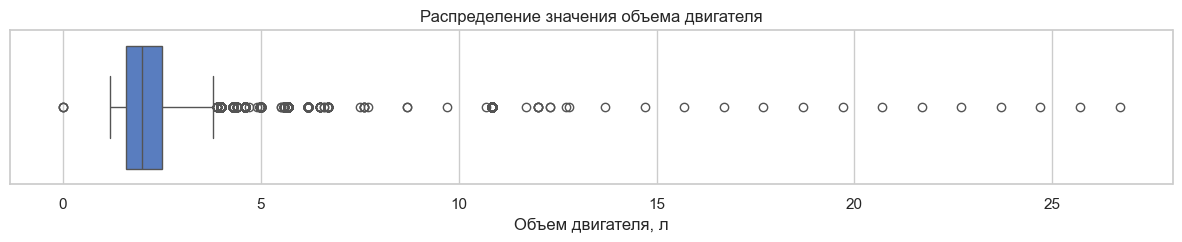

In [61]:
plt.figure(figsize=(15, 2))
sns.boxplot(data=data, x='engine_capacity_l')
plt.title('Распределение значения объема двигателя')
plt.xlabel('Объем двигателя, л')
plt.show()

Судя по графику, основная масса автомобилей с двигателем не выше 4 литров.\
Посмотрим на авто выше 5 литров, чтобы найти аномалии. 

In [62]:
# посмотрим на модели с объемом больше 5
data.loc[data['engine_capacity_l']>5].groupby(
    ['company', 'brand', 'model','release_year', 'engine_capacity_l']
)['price_usd'].count().reset_index().rename(columns={'price_usd': 'count'})

company                 brand      model  \
0                     Allur Auto                Yutong  ZK6108HGH   
1                     Allur Auto                Yutong  ZK6108HGH   
2                    Autokapital         Mercedes-Benz    G-Class   
3                    Autokapital         Mercedes-Benz  GLE Coupe   
4                    Autokapital  Mercedes-Benz Trucks     Actros   
5                    Autokapital  Mercedes-Benz Trucks     Actros   
6                    Autokapital  Mercedes-Benz Trucks     Actros   
7                    Autokapital  Mercedes-Benz Trucks   Tourismo   
8          Eurasia Motor Premium              Cadillac   Escalade   
9          Eurasia Motor Premium              Cadillac   Escalade   
10         Eurasia Motor Premium              Cadillac   Escalade   
11         Eurasia Motor Premium             Chevrolet      Tahoe   
12         Eurasia Motor Premium             Chevrolet      Tahoe   
13  Hyundai Com Trans Kazakhstan   Hyundai Truck & Bus     HD 170   
14  Hyundai Com Trans Kazakhstan   Hyundai Truck & Bus   Universe   
15                   Mercur Auto            Volkswagen       Polo   
16      Nissan Manufacturing RUS              Infiniti       QX80   
17      Nissan Manufacturing RUS              Infiniti       QX80   
18       Toyota Motor Kazakhstan                 Lexus         LX   
19       Toyota Motor Kazakhstan                 Lexus         LX   
20       Toyota Motor Kazakhstan                 Lexus         LX   
21       Toyota Motor Kazakhstan                 Lexus         LX   
22             Автоцентр-Бавария                   BMW    7 серия   
23                         Вираж             Chevrolet       Niva   
24                         Вираж             Chevrolet       Niva   
25                         Вираж             Chevrolet       Niva   
26                         Вираж             Chevrolet       Niva   
27                         Вираж             Chevrolet       Niva   
28                         Вираж             Chevrolet       Niva   
29                         Вираж             Chevrolet       Niva   
30                         Вираж             Chevrolet       Niva   
31                         Вираж             Chevrolet       Niva   
32                         Вираж             Chevrolet       Niva   
33                         Вираж             Chevrolet       Niva   
34                         Вираж             Chevrolet       Niva   
35                         Вираж             Chevrolet       Niva   
36                         Вираж             Chevrolet       Niva   
37                         Вираж             Chevrolet       Niva   
38                         Вираж             Chevrolet       Niva   
39                         Вираж             Chevrolet       Niva   
40                         Вираж             Chevrolet       Niva   
41                         Вираж             Chevrolet       Niva   
42                         Вираж             Chevrolet       Niva   
43                         Вираж             Chevrolet       Niva   
44                         Вираж             Chevrolet       Niva   
45                      ТК КАМАЗ                 KAMAZ      43118   
46                      ТК КАМАЗ                 KAMAZ      43118   
47                      ТК КАМАЗ                 KAMAZ      43118   
48                      ТК КАМАЗ                 KAMAZ      65115   
49                      ТК КАМАЗ                 KAMAZ      65115   
50                      ТК КАМАЗ                 KAMAZ      65115   
51                      ТК КАМАЗ                 KAMAZ      65115   
52         Хино Моторс Казахстан                  Hino        500   

   release_year  engine_capacity_l  count  
0          2019               6.50     13  
1          2019               6.70     31  
2          2017               5.50      1  
3          2018               5.50      1  
4          2018              12.00      1  
5          2019              12.00

Мы видим однозначную аномалию заполнения у Niva Chevrolet - значения идут с шагом 1л. Посмотрим на все значения у Нивы.

In [63]:
# посмотрим на объем двигателя у Нивы
data.loc[(data['brand'] == 'Chevrolet')&(data['model'] == 'Niva')].groupby(
    ['company', 'brand', 'model','release_year', 'engine_capacity_l']
)['price_usd'].count().reset_index().rename(columns={'price_usd': 'count'})

company      brand model release_year  engine_capacity_l  count
0    Вираж  Chevrolet  Niva         2017               1.70      1
1    Вираж  Chevrolet  Niva         2018               1.70    166
2    Вираж  Chevrolet  Niva         2019               1.70    375
3    Вираж  Chevrolet  Niva         2019               2.70      1
4    Вираж  Chevrolet  Niva         2019               3.70      1
5    Вираж  Chevrolet  Niva         2019               4.70      1
6    Вираж  Chevrolet  Niva         2019               5.70      1
7    Вираж  Chevrolet  Niva         2019               6.70      1
8    Вираж  Chevrolet  Niva         2019               7.70      1
9    Вираж  Chevrolet  Niva         2019               8.70      1
10   Вираж  Chevrolet  Niva         2019               9.70      1
11   Вираж  Chevrolet  Niva         2019              10.70      1
12   Вираж  Chevrolet  Niva         2019              11.70      1
13   Вираж  Chevrolet  Niva         2019              12.70      1
14   Вираж  Chevrolet  Niva         2019              13.70      1
15   Вираж  Chevrolet  Niva         2019              14.70      1
16   Вираж  Chevrolet  Niva         2019              15.70      1
17   Вираж  Chevrolet  Niva         2019              16.70      1
18   Вираж  Chevrolet  Niva         2019              17.70      1
19   Вираж  Chevrolet  Niva         2019              18.70      1
20   Вираж  Chevrolet  Niva         2019              19.70      1
21   Вираж  Chevrolet  Niva         2019              20.70      1
22   Вираж  Chevrolet  Niva         2019              21.70      1
23   Вираж  Chevrolet  Niva         2019              22.70      1
24   Вираж  Chevrolet  Niva         2019              23.70      1
25   Вираж  Chevrolet  Niva         2019              24.70      1
26   Вираж  Chevrolet  Niva         2019              25.70      1
27   Вираж  Chevrolet  Niva         2019              26.70      1

Мы видим, что большинство заполнено верно, 1.7 литра, но есть 25 значений с шагом 1 литр.
Заменим их.

In [64]:
data.loc[
    (data['company'] == 'Вираж')&
    (data['brand'] == 'Chevrolet')&
    (data['model'] == 'Niva')&
    (data['release_year'] == '2019')&
    (data['engine_capacity_l'] > 1.7),
    ['engine_capacity_l']
] = 1.7

Также мы видим аномалию у Volkswagen Polo - 8.7 литров. У них максимальный объем - 1.6.\
Заменяем.

In [65]:
# Volkswagen Polo
data.loc[
    (data['model'] == 'Polo') &
    (data['release_year'] == 2018)&
    (data['engine_capacity_l'] > 2),
    'engine_capacity_l'
] = 1.6

Теперь посмотрим на модели с 3 до 5 литров.

In [66]:
# посмотрим на модели с объемом больше 5
data.loc[
    (data['engine_capacity_l']>=3)&
    (data['engine_capacity_l']<5)
    ].groupby(
    ['company', 'brand', 'model', 'engine_capacity_l']
)['price_usd'].count().reset_index().rename(columns={'price_usd': 'count'}).tail(50)

company       brand              model  \
29               Mercur Auto        Audi                 A6   
30               Mercur Auto        Audi                 A7   
31               Mercur Auto        Audi                 A8   
32               Mercur Auto        Audi                 Q7   
33               Mercur Auto        Audi                 Q8   
34               Mercur Auto     Porsche      911 Carrera S   
35               Mercur Auto     Porsche            Cayenne   
36               Mercur Auto     Porsche              Macan   
37               Mercur Auto     Porsche           Panamera   
38               Mercur Auto     Porsche           Panamera   
39               Mercur Auto  Volkswagen            Touareg   
40  Nissan Manufacturing RUS    Infiniti               QX60   
41  Nissan Manufacturing RUS      Nissan             Murano   
42              TERRA MOTORS      Jaguar                 XJ   
43              TERRA MOTORS  Land Rover          Discovery   
44              TERRA MOTORS  Land Rover        Range Rover   
45              TERRA MOTORS  Land Rover  Range Rover Sport   
46   Toyota Motor Kazakhstan       Lexus                 ES   
47   Toyota Motor Kazakhstan       Lexus                 GX   
48   Toyota Motor Kazakhstan       Lexus                 LS   
49   Toyota Motor Kazakhstan       Lexus                 RX   
50   Toyota Motor Kazakhstan       Lexus                RXH   
51   Toyota Motor Kazakhstan      Toyota              Camry   
52   Toyota Motor Kazakhstan      Toyota              Camry   
53   Toyota Motor Kazakhstan      Toyota            Corolla   
54   Toyota Motor Kazakhstan      Toyota         HIGHLANDER   
55   Toyota Motor Kazakhstan      Toyota           LC Prado   
56   Toyota Motor Kazakhstan      Toyota              LC200   
57   Toyota Motor Kazakhstan      Toyota              LC200   
58      Volkswagen Group Rus  Volkswagen             Amarok   
59        Автодом Motors KST  Volkswagen            Touareg   
60         Автоцентр-Бавария         BMW            5 серия   
61         Автоцентр-Бавария         BMW            7 серия   
62         Автоцентр-Бавария         BMW            7 серия   
63         Автоцентр-Бавария         BMW            8 серия   
64         Автоцентр-Бавария         BMW                 X5   
65         Автоцентр-Бавария         BMW                 X5   
66         Автоцентр-Бавария         BMW                 X6   
67         Автоцентр-Бавария         BMW                 X6   
68         Автоцентр-Бавария         BMW                 X7   
69         Автоцентр-Бавария         BMW                 X7   
70                БИПЭК АВТО   Chevrolet            Captiva   
71                БИПЭК АВТО         Kia             Quoris   
72                БИПЭК АВТО         Kia            Sorento   
73                БИПЭК АВТО         Kia            Stinger   
74                     Вираж         GAZ               3302   
75                     Вираж         GAZ               3308   
76                     Вираж         GAZ               3309   
77                     Вираж         GAZ               Next   
78     Хино Моторс Казахстан        Hino                300   

    engine_capacity_l  count  
29               3.00      7  
30               3.00      2  
31               3.00      5  
32               3.00      3  
33               3.00     20  
34               3.00      1  
35               3.00     27  
36               3.00      3  
37               3.00      5  
38               4.00      3  
39               3.00      1  
40               3.50     14  
41               3.50     23  
42               3.00      1  
43               3.00      1  
44               3.00      4  
45               3.00     11  
46               3.50     41  
47               4.60     22  
48               3.50     10  
49               3.50     94  
50               3.50      2  
51               3.50    330  
52               4.60     97  
53               4.00    131  
5

Явные аномалии не обнаружены.

Мы заменили ошибки, обработали электродвигатели (заменили на 0).

### Регион и область

`регион` и `область` — приведем к нижнему регистру с заглавной буквы


In [67]:
# редактируем значения в столбцах
data['region'] = data['region'].str.strip().str.lower().str.capitalize()
data['province'] = data['province'].str.strip().str.lower().str.capitalize()

In [68]:
# посмотрим на результат
data['region'].value_counts().reset_index()

region  count
0             Алматы  10318
1         Нур-султан   7615
2            Шымкент   2718
3           Костанай   2251
4             Атырау   2014
5          Караганда   1830
6            Экспорт   1477
7            Уральск   1389
8              Актау   1375
9             Актобе   1243
10          Павлодар   1184
11  Усть-каменогорск   1084
12         Кызылорда    508
13     Петропавловск    480
14          Кокшетау    454
15             Семей    242
16       Талдыкорган    228
17             Тараз    194
18         Экибастуз     86
19            Рудный     47
20          Каскелен     38
21         Туркестан     15
22          Сарыагаш      4
23            Риддер      2

In [69]:
# посмотрим на результат в province
data['province'].value_counts().reset_index()

province  count
0                         Г.алматы  10318
1                     Г.нур-султан   7615
2       Южно-казахстанская область   2718
3             Костанайская область   2298
4               Атырауская область   2014
5           Карагандинская область   1830
6                  Экспорт область   1477
7    Западно-казахстанская область   1389
8            Мангистауская область   1375
9   Восточно-казахстанская область   1328
10            Павлодарская область   1270
11             Актюбинская область   1243
12          Кызылординская область    508
13    Северо-казахстанская область    480
14             Акмолинская область    454
15             Алматинская область    266
16              Жамбылская область    194
17           Туркестанская область     19

Поменяем *"Г.алматы"* и *"Г.нур-султан"* на название города без *"Г."*

In [70]:
# уберем Г. из названий области
data.loc[data['province']=='Г.алматы', 'province'] = 'Алматы'
data.loc[data['province']=='Г.нур-султан', 'province'] = 'Нур-султан'

Также 19 июня 2018 года указом президента Казахстана Южно-Казахстанская область переименована в Туркестанскую, а её административный центр перенесён из Шымкента в Туркестан; Шымкент был изъят из состава Южно-Казахстанской области, получив статус города республиканского значения (отдельная административно-территориальная единица, равная области) ["статья"](<https://www.akorda.kz/ru/events/akorda_news/akorda_other_events/publichnoe-podpisanie-ukaza-o-nekotoryh-voprosah-administrativno-territorialnogo-ustroistva-respubliki-kazahstan>).

Следовательно, проверим, какие города и районы сейчас присутствуют в продажах Южно-Казахстанской области.

In [71]:
data[data['province']=='Южно-казахстанская область'].groupby('region')['quantity'].sum()

region
Шымкент    3587
Name: quantity, dtype: int64

Среди регионов только Шымкент, который с июня является городом республиканского значения.\
 Можем заменить значение Южно-Казахстанская область на Шымкент.

In [72]:
data.loc[data['province']=='Южно-казахстанская область', 'province'] = 'Шымкент'

Мы привели все названия к одному формату, без лишних пробелов.

### Сегмент и класс

Посмотрим, какие у нас есть классы, сегменты.

In [73]:
data['segment_2013'].value_counts()

segment_2013
Внедорожники               16924
Легковые автомобили        15558
Коммерческие автомобили     3061
Пикапы                       893
Минивэны                     360
Name: count, dtype: int64

In [74]:
# посмотрим, что считается коммерческими авто
data.loc[
    (data['segment_2013'] == 'Коммерческие автомобили')
].groupby(['brand', 'model'])['price_usd'].count().reset_index().rename(columns={'price_usd': 'count'}).sort_values(by='count', ascending=False)

brand               model  count
11                   GAZ                3302    871
14                   GAZ                Next    346
40                   UAZ                3909    261
29                 KAMAZ               65115    259
28                 KAMAZ               43118    188
1                  ANKAI            HFF6850G    186
8                    GAZ                2705    136
36                   UAZ                2206    116
26                   Jac                N120     88
10                   GAZ                3221     59
12                   GAZ                3308     54
9                    GAZ                2752     51
27                   Jac                 N56     48
41                   UAZ                3962     47
46                Yutong           ZK6108HGH     44
13                   GAZ                3309     40
37                   UAZ                3303     38
15                  Hino                 300     37
39                   UAZ                3741     34
7                    GAZ                2310     27
42                   UAZ               Cargo     20
0                  ANKAI         HFF6127GZ-4     20
44            Volkswagen  Transporter Kasten     10
21   Hyundai Truck & Bus               HD 65      9
32  Mercedes-Benz Trucks            Sprinter      8
18   Hyundai Truck & Bus                H350      8
4                 Daewoo            BS 106 A      5
43            Volkswagen       Caddy Kasten       4
16                  Hino                 500      4
35  Mercedes-Benz Trucks                Vito      4
22   Hyundai Truck & Bus               HD 78      4
30         Mercedes-Benz             V-Class      4
20   Hyundai Truck & Bus               HD 35      4
45            Volkswagen  Transporter Kombi       4
17   Hyundai Truck & Bus              County      3
6                    GAZ                2217      3
31  Mercedes-Benz Trucks              Actros      3
2                 Daewoo              BC 095      2
33  Mercedes-Benz Trucks            Tourismo      2
24   Hyundai Truck & Bus            Universe      2
5                 Daewoo            BS 106 D      2
34  Mercedes-Benz Trucks             V-Class      1
3                 Daewoo           BC 211 MA      1
38                   UAZ                3309      1
19   Hyundai Truck & Bus              HD 170      1
25                 Iveco               Daily      1
23   Hyundai Truck & Bus               HD 79      1

В коммерческих автобусы и грузовики.

Посмотрим, есть ли крупные покупки (больше 2 шт.) в некоммерческом сегменте.

In [75]:
# отфильтруем некоммерческое и больше 2 штук
(
    data.loc[
        (data['segment_2013'] != 'Коммерческие автомобили') &
        (data['quantity'] > 2)
    ]
    .pivot_table(
        index=['brand', 'model'],
        values='quantity',
        aggfunc=['count', 'median']
    )
    .set_axis(['count', 'median_quantity'], axis=1)
    .reset_index()
    .sort_values(by='count', ascending=False, ignore_index=True)
)

brand         model  count  median_quantity
0            Lada        Granta    314             8.50
1            Lada         Vesta    288             5.00
2            Lada           4x4    192            10.00
3            Lada        Largus    144             7.00
4             Kia           Rio     99             6.00
5          Nissan       Terrano     65             4.00
6            Lada          XRAY     60             3.00
7             Kia       Sorento     49             4.00
8          Nissan       Qashqai     45             4.00
9             Kia      Sportage     33             4.00
10            Kia        Cerato     31             4.00
11         Nissan       X-Trail     30             3.00
12          Skoda       Octavia     24             4.00
13            BMW            X5     19             7.00
14            Kia        Optima     15             4.00
15          Skoda        Kodiaq     15             4.00
16          Skoda        Superb     15             3.00
17            UAZ       Patriot     14             3.50
18            BMW            X7     10             4.00
19            UAZ          3151      8             4.50
20  Mercedes-Benz       G-Class      8             4.00
21            Kia       Picanto      7             3.00
22          Skoda         Rapid      6             4.00
23            BMW            X3      5             3.00
24            BMW            X6      5             4.00
25            Kia          Soul      4             3.50
26            BMW       5 серия      4             3.50
27         Nissan        Almera      2             4.00
28      Chevrolet       Captiva      2             4.00
29     Mitsubishi     Outlander      2             4.00
30  Mercedes-Benz       A-Class      1             3.00
31            Kia        Quoris      1             6.00
32     Mitsubishi  Pajero Sport      1             3.00
33  Mercedes-Benz     GLE-Class      1             5.00
34  Mercedes-Benz     GLE Coupe      1             3.00
35  Mercedes-Benz       E-Class      1             3.00
36         Nissan          Juke      1             3.00

Маловероятно, что частные покупатели будут брать 10 Нив в одном заказе. Это могут быть таксопарки, организации и иные юридические лица.\
Создадим столбец `segment`, где разделим авто на b2b и b2c.

b2b - у которых в столбце `['segment_2013']` указано `Коммерческие автомобили`, и те, где количество в продаже больше 2.\
b2c - остальные.

In [76]:
# присвоим значения сегмента
data['segment'] = 'b2c'
data.loc[
    (data['segment_2013'] == 'Коммерческие автомобили') | (data['quantity'] > 2),
    'segment'
] = 'b2b'

In [77]:
# посмотрим на значения столбца
data['class_2013'].value_counts().reset_index()

class_2013  count
0              Компактные SUV   6371
1                     B класс   6301
2                     D класс   5355
3           Субкомпактные SUV   4620
4         Среднеразмерные SUV   3969
5                     C класс   3568
6          Полноразмерные SUV   1964
7     Малотоннажные грузовики   1427
8                    Pick-ups    893
9   Крупнотоннажные грузовики    478
10              Микроавтобусы    396
11       Развозные автомобили    350
12                 Компактвэн    315
13                    E класс    244
14           Большие автобусы    220
15  Среднетоннажные грузовики    143
16           Средние автобусы     47
17     Полноразмерный Минивэн     45
18                    A класс     42
19                    F класс     38
20      Спортивные автомобили     10

### Год выпуска

Посмотрим, какие значения у нас присутствуют в столбце.

In [78]:
# посмотрим на уникальные значения
data['release_year'].unique()

array(['2018', '2017', '2019', '2016', '2014', '2013', '2\xa0018',
       '2\xa0019'], dtype=object)

Мы обнаружили ошибку с неразрывными пробелами из Excel. Заменим их.

In [79]:
# заменим кракозябры
data['release_year'] = data['release_year'].str.replace('\xa0', '')

# выведем список уникальных значений
data['release_year'].unique()

array(['2018', '2017', '2019', '2016', '2014', '2013'], dtype=object)

In [80]:
# приведем год выпуска к числовому типу
data['release_year'] = data['release_year'].astype('int64')

# посмотрим, что получилось
data.groupby('release_year', as_index=False)['quantity'].sum().rename(columns={'quantity': 'count'}).assign(
    rate=lambda x: (x['count'] / x['count'].sum() * 100).round(2).astype(str) + '%'
).sort_values(by='release_year', ascending=False)

release_year  count    rate
5          2019  39130  79.19%
4          2018   9995  20.23%
3          2017    266   0.54%
2          2016     18   0.04%
1          2014      2    0.0%
0          2013      1    0.0%

Мы видим, что основная масса проданных в 2019 году авто была новой, 2019 года выпуска.\
20% - 2018 года, и менее процента - более старые.

In [81]:
### Категории
# Столбцы:
# - `тип топлива`
# - `тип трансмиссии`
# - `тип привода`
# - `сегмент 2013`
# - `класс 2013`,
# - `сегмент`
# - `бренд`
# можно перевести в категориальные признаки для экономии памяти.

In [82]:
# print('Использование памяти')
# print('=' * 25)
# print("До преобразования:")
# print('=' * 25)
# print(data[['segment_2013', 'class_2013', 'segment', 'fuel_type', 'transmission', 'drive_type', 'country_origin', 'company', 'brand']].memory_usage(deep=True))

# # Преобразуем
# data['segment_2013'] = data['segment_2013'].astype('category')
# data['class_2013'] = data['class_2013'].astype('category')
# data['segment'] = data['segment'].astype('category')
# data['fuel_type'] = data['fuel_type'].astype('category')
# data['transmission'] = data['transmission'].astype('category')
# data['drive_type'] = data['drive_type'].astype('category')
# data['country_origin'] = data['country_origin'].astype('category')
# data['company'] = data['company'].astype('category')
# data['brand'] = data['brand'].astype('category')

# print('=' * 25)
# print("\nПосле преобразования:")
# print('=' * 25)
# print(data[['segment_2013', 'class_2013', 'segment', 'fuel_type', 'transmission', 'drive_type', 'country_origin', 'company', 'brand']].memory_usage(deep=True))

In [83]:
# я перевел столбцы в категории, но эти категории потом стали постоянно вылезать со значением 0 на графиках, таблицах, расчетах, что сильно перегружало визуализации и заставляло периодически чистить данные

**Выводы:** Мы очистили данные, закодировали и уменьшили тип топлива, привода, коробку передач, создали столбцы с делением на сегменты и месяцем продажи.\
Обнаружили ошибку заполнения объема двигателя у Нивы, обработали электродвигатели.

## Исследовательский анализ данных

В рамках исследовательского анализа данных мы изучим ключевые столбцы датасета, чтобы получить общее представление о структуре и содержании данных. Цель — выявить закономерности, пропуски, выбросы и аномалии, а также визуализировать распределения и связи между переменными с помощью графиков. Это поможет подготовить данные к последующему анализу и сформировать гипотезы о поведении рынка.

In [84]:
# вспомним, какие у нас данные, столбцы, количество данных
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 36796 entries, 0 to 39950
Data columns (total 18 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   company            36796 non-null  object        
 1   brand              36796 non-null  object        
 2   model              36796 non-null  object        
 3   release_year       36796 non-null  int64         
 4   country_origin     36796 non-null  object        
 5   fuel_type          36796 non-null  object        
 6   engine_capacity_l  36637 non-null  float64       
 7   transmission       36796 non-null  object        
 8   drive_type         36796 non-null  object        
 9   region             36796 non-null  object        
 10  quantity           36796 non-null  int64         
 11  price_usd          36796 non-null  float64       
 12  total_usd          36796 non-null  float64       
 13  province           36796 non-null  object        
 14  segment_201

In [85]:
# Создаём отчёт по DataFrame
profile = ProfileReport(data, title="Отчёт по данным", explorative=True)

# Показываем в Jupyter
profile.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 18/18 [00:00<00:00, 213.08it/s]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Судя по автоматическому отчету:
- компании сильно привязаны к брендам, стране производства (видимо, к заводам), сегментам.
- цена в основном зависит от объема двигателя.
- тип топлива несбалансирован, большинство бензин, электродвигатели и гибриды не представлены в достаточном количестве.
- цена сделок перекошена, т.к. есть оптовые продажи, есть премиум сегмент.

### Компания

Посмотрим, как распределяются компании по количеству и сумме продаж

In [86]:
print(f"Всего уникальных компаний: {data['company'].nunique()}")
data.pivot_table(
    index='company',
    values=['quantity', 'total_usd'],
    aggfunc='sum',
    observed=False
).sort_values(by='total_usd', ascending=False)

Всего уникальных компаний: 28


quantity    total_usd
company                                            
Toyota Motor Kazakhstan          11947 479733923.77
Astana Motors                    10169 229338604.06
БИПЭК АВТО                       15030 184480681.45
Nissan Manufacturing RUS          1760  46289495.68
Allur Auto                        1931  45421956.26
Вираж                             2675  41552156.98
Автоцентр-Бавария                  453  29126201.04
ТК КАМАЗ                           447  22402311.88
Mercur Auto                        603  17674741.76
Autokapital                        179  16874860.49
Subaru Kazakhstan                  503  16158331.08
MMC RUS                            399  13341662.80
Renault Россия                    1002  13071110.27
Ravon Motors Kazakhstan           1288  12752459.10
Daewoo Bus Kazakhstan              146  12162701.94
Almaty Motors Premium               87   8973650.33
TERRA MOTORS                        76   7859764.75
Eurasia Motor Premium              102   7724913.40
Hyundai Com Trans Kazakhstan        80   3750251.37
Лифан Моторс Рус                   233   2890114.98
Хино Моторс Казахстан               58   2603154.99
Scandinavian Motors                 40   2502442.18
Volkswagen Group Rus                41   1646920.02
Автодом Motors KST                  53   1064732.01
Автомир-Центр                       34    660552.90
УзАвто-Казахстан                    58    584306.25
ТОО "Eurasia Motor Zhaik"           15    320037.58
Caspian Motors                       3     68429.17

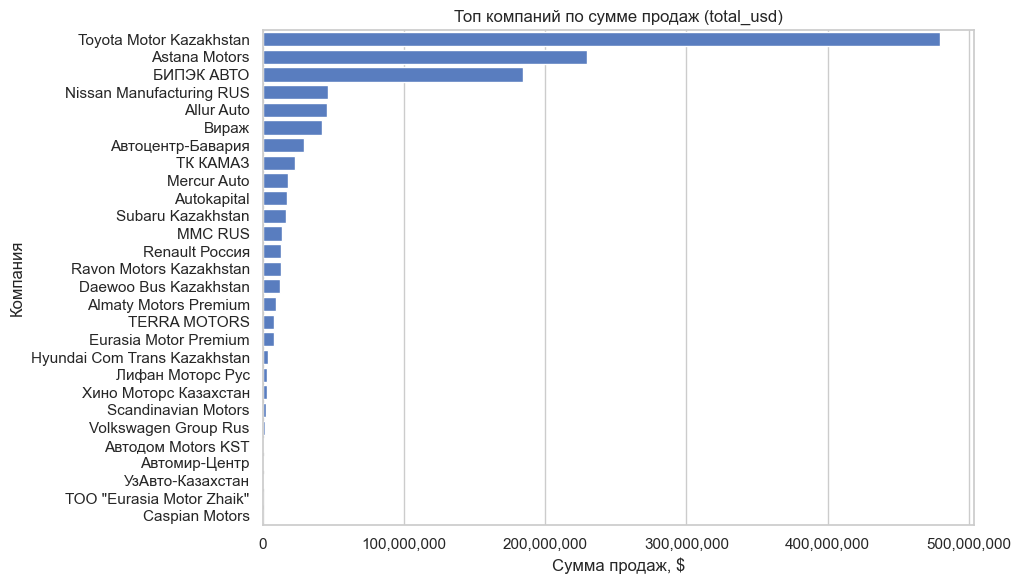

In [87]:
# Группируем данные
company_sales = data.pivot_table(
    index='company',
    values='total_usd',
    aggfunc='sum',
    observed=False
).sort_values(by='total_usd', ascending=False).reset_index()

# Указываем порядок компаний для отображения в графике
order = company_sales['company']

# Стиль графика
plt.figure(figsize=(10, 6))
sns.barplot(
    data=company_sales,
    y='company',   # компании по оси Y
    x='total_usd', # сумма продаж по X
    order=order,
)
plt.title('Топ компаний по сумме продаж (total_usd)')
plt.xlabel('Сумма продаж, $')
plt.ylabel('Компания')
plt.tight_layout()
plt.gca().xaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}')); # Формат без экспоненты
plt.show()

Топ-3 дилера:
- Toyota Motor Kazakhstan - почти $480 млн.
- Astana Motors	- больше 200 млн.
- БИПЭК АВТО - 184 млн.

Из интересного:
- Autokapital продал всего 179 автомобилей, но входит в ТОП-10 по выручке;
- У компаний из конца списка количество проданных авто за год - меньше 100, есть даже 3 авто. Либо это мелкие организации, либо неполная информация.

In [88]:
# посмотрим, какими брендами занимается Autokapital
print('Autokapital')
print('Количество и цена продажи по брендам')

df_brand = (
    data[data['company'] == 'Autokapital']
    .groupby('brand', as_index=False)
    .agg(
        car_count=('quantity', 'sum'),
        car_price=('price_usd', 'mean'),
        total_sales=('total_usd', 'sum')
    )
)

df_brand['rate'] = df_brand['total_sales'] / df_brand['total_sales'].sum()

display(df_brand)

print('=' * 55)
print('Разбивка продаж по моделям')

df_model = (
    data[data['company'] == 'Autokapital']
    .groupby(['brand', 'model'], as_index=False)
    .agg(
        car_count=('quantity', 'sum'),
        car_price=('price_usd', 'mean'),
        total_sales=('total_usd', 'sum')
    )
)

df_model['rate'] = df_model['total_sales'] / df_model['total_sales'].sum()

df_model.sort_values(by='car_count', ascending=False)

Autokapital
Количество и цена продажи по брендам


brand  car_count  car_price  total_sales  rate
0         Mercedes-Benz        145   90618.76  14574533.15  0.86
1  Mercedes-Benz Trucks         34   78965.38   2300327.34  0.14

Разбивка продаж по моделям


brand      model  car_count  car_price  total_sales  rate
5          Mercedes-Benz    G-Class         67  147589.37   9815009.58  0.58
4          Mercedes-Benz    E-Class         20   43620.38    874452.28  0.05
15  Mercedes-Benz Trucks   Sprinter         13   39150.57    451317.11  0.03
9          Mercedes-Benz  GLE Coupe         11   70541.13    776027.06  0.05
10         Mercedes-Benz  GLE-Class         11   67301.07    750016.80  0.04
11         Mercedes-Benz  GLS-Class         10   79062.90    791464.85  0.05
14  Mercedes-Benz Trucks     Actros          9   94747.16    839919.16  0.05
18  Mercedes-Benz Trucks       Vito          9   37229.52    334078.32  0.02
13         Mercedes-Benz    V-Class          5   65094.57    327714.46  0.02
0          Mercedes-Benz    A-Class          5   26377.76    131634.31  0.01
12         Mercedes-Benz    S-Class          4  107184.25    428737.00  0.03
8          Mercedes-Benz  GLC-Class          3   47568.53    142705.59  0.01
7          Mercedes-Benz  GLC Coupe          3   50244.59    150733.77  0.01
1          Mercedes-Benz    C-Class          2   49670.43     99340.85  0.01
3          Mercedes-Benz  CLS-Class          2   93414.56    186829.12  0.01
16  Mercedes-Benz Trucks   Tourismo          2  304451.45    608902.89  0.04
6          Mercedes-Benz  GLA-Class          1   61540.37     61540.37  0.00
2          Mercedes-Benz  CLA-Class          1   38327.09     38327.09  0.00
17  Mercedes-Benz Trucks    V-Class          1   66109.86     66109.86  0.00

 Autokapital занимается продажами Mercedes-Benz (86%) и Mercedes-Benz Trucks (14%). Основная доля продаж - Гелендвагены по $150 тысяч, 67 штук, 58% выручки.

### Бренд

Рассмотрим, какие бренды представлены на рынке, как распространены.

In [89]:
# Считаем, сколько разных брендов в данных
print(f"Всего уникальных брендов: {data['brand'].nunique()}")

# Суммируем общее количество проданных автомобилей по бренду
brand_sales = data.groupby('brand')['quantity'].sum().reset_index()

# Сортируем по убыванию количества
brand_sales = brand_sales.sort_values(by='quantity', ascending=False).reset_index(drop=True)

# Отображаем
brand_sales

Всего уникальных брендов: 37


brand  quantity
0                   Lada     11089
1                 Toyota     10741
2                Hyundai     10168
3                    Kia      2358
4                 Nissan      1664
5                    GAZ      1587
6                    Jac      1528
7                  Ravon      1482
8                    UAZ      1263
9                  Lexus      1206
10               Renault      1002
11                 Skoda       790
12             Chevrolet       648
13            Volkswagen       642
14                Subaru       504
15                 KAMAZ       447
16                   BMW       437
17            Mitsubishi       399
18                 Lifan       233
19                 ANKAI       206
20                Daewoo       146
21         Mercedes-Benz       145
22            Land Rover       130
23              Infiniti        96
24   Hyundai Truck & Bus        80
25              Cadillac        72
26                  Hino        58
27                  Audi        52
28               Porsche        52
29                Yutong        44
30                 Volvo        40
31  Mercedes-Benz Trucks        34
32                Jaguar        33
33                  Mini        16
34               Peugeot        16
35                  Ford         3
36                 Iveco         1

В топе продаж по количеству: Lada, Toyota и Hyundai.\
Посмотрим на графике.

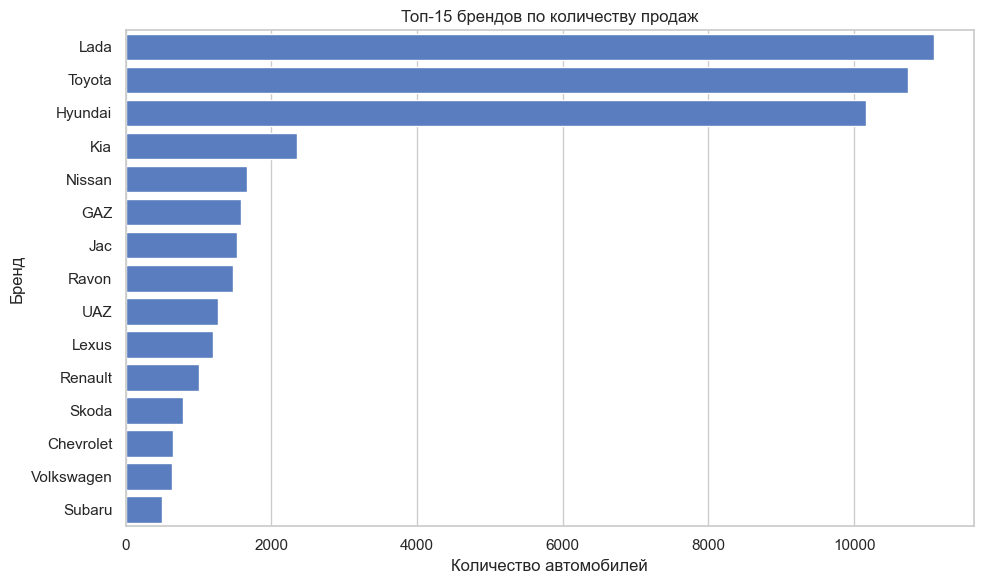

In [90]:
# Строим график
plt.figure(figsize=(10, 6))
order = brand_sales['brand'].head(15)
sns.barplot(
    data=brand_sales.head(15),
    x='quantity',
    y='brand',
    order=order
)

# Добавляем заголовок и улучшаем внешний вид
plt.title('Топ-15 брендов по количеству продаж')
plt.xlabel('Количество автомобилей')
plt.ylabel('Бренд')
plt.tight_layout()
plt.show()

Топ-3 бренда имеют по 10 тысяч и более проданных автомобилей.\
Kia чуть больше 2 тысяч, остальные проданы в количествах меньше 1500.

### Модель

Отберем наиболее часто встречающиеся среди проданных модели и составим для них ящики с усами.

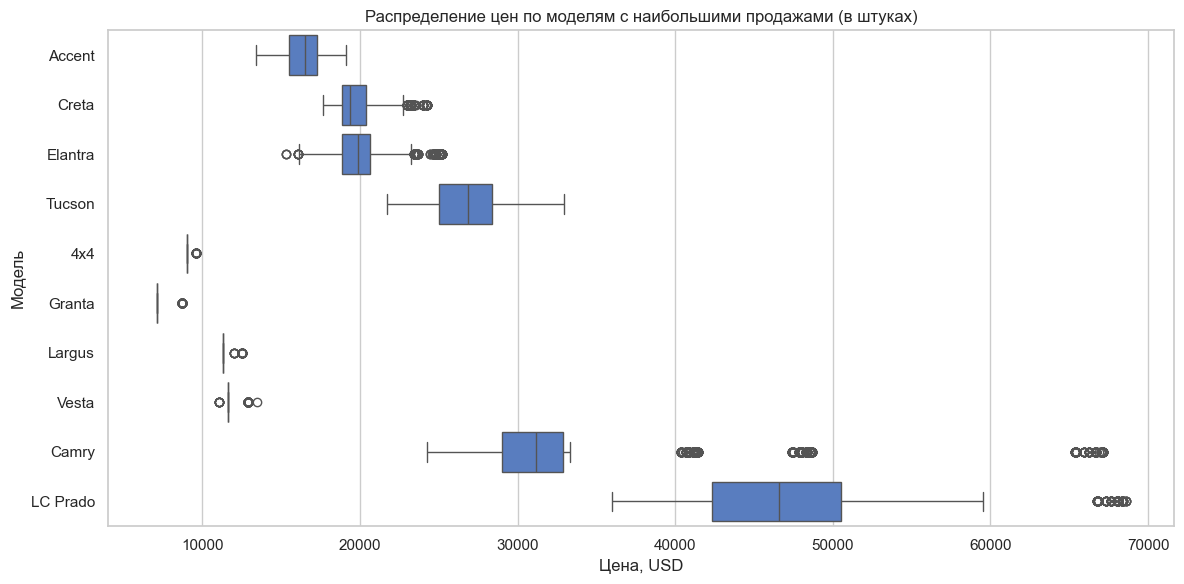

In [91]:
# Выбираем топ-10 моделей по проданным штукам
top_10_models = (
    data.groupby('model')['quantity']
    .sum()
    .sort_values(ascending=False)
    .head(10)
    .index
)

# строим график
plt.figure(figsize=(12, 6))
sns.boxplot(
    data=data[data['model'].isin(top_10_models)],
    x='price_usd', y='model', orient='h'
)

# Добавляем заголовок и улучшаем внешний вид
plt.title('Распределение цен по моделям с наибольшими продажами (в штуках)')
plt.xlabel('Цена, USD')
plt.ylabel('Модель')
plt.tight_layout()
plt.show()

- у Camry средняя цена около 30000 долларов, но есть большое количество выбросов и на 40-50, и на 70 тысяч долларов, что странно;
- LC Prado имеет высокий разброс, аномалии около 70 тысяч долларов. Возможно, это связано с модификациями. Интересно, что в топ-10 рынка Казахстана оказался Toyota Land Cruiser Prado.
- продукция Автоваза в основном без существенных выбросов, разброс в пару тысяч долларов.

Посмотрим на модели, которые находятся в топе по выручке.

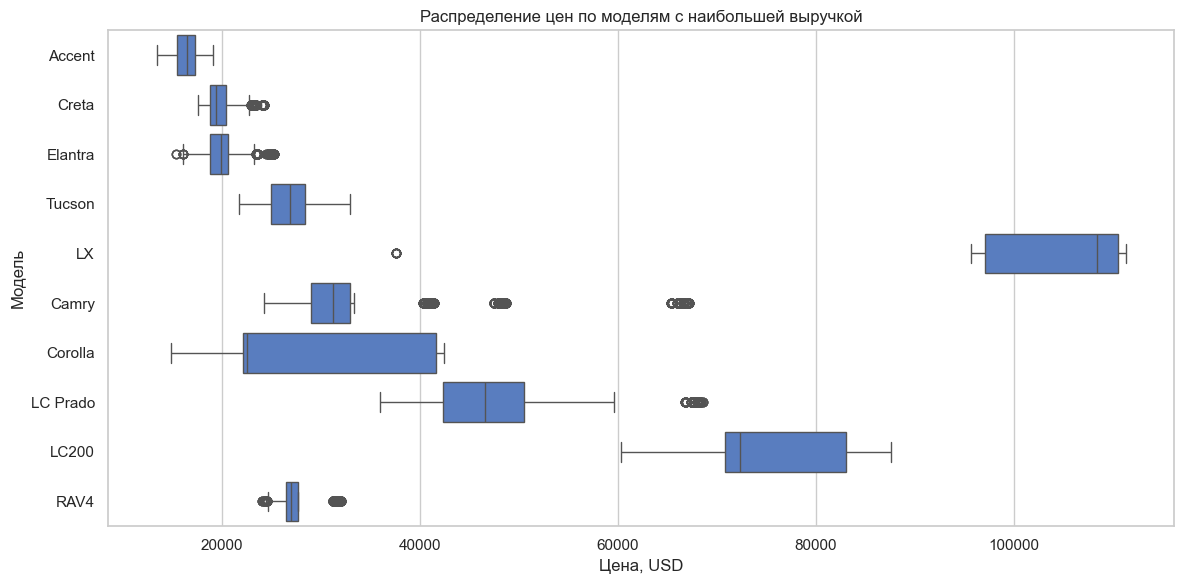

In [92]:
# Выбираем топ-10 моделей по суммарной выручке (total_usd)
top_10_by_sales = (
    data.groupby('model')['total_usd']
    .sum()
    .sort_values(ascending=False)
    .head(10)
    .index
)

# Строим boxplot — распределение цен по этим моделям
plt.figure(figsize=(12, 6))
sns.boxplot(
    data=data[data['model'].isin(top_10_by_sales)],
    x='price_usd',
    y='model',
    orient='h',
)

# Добавляем заголовок и улучшаем внешний вид
plt.title('Распределение цен по моделям с наибольшей выручкой')
plt.xlabel('Цена, USD')
plt.ylabel('Модель')
plt.tight_layout()
plt.show()

- У Corolla медианная цена 23000, однако разброс высок, от 15 до 43 тысяч за автомобиль;

### Год выпуска

In [93]:
# посмотрим, какие годы есть в нашем датасете
data['release_year'].value_counts().reset_index()

release_year  count
0          2019  28146
1          2018   8378
2          2017    251
3          2016     18
4          2014      2
5          2013      1

Посмотрим, что за авто 2013-2016 года выпуска продавались в 2019 году.

In [94]:
# отфильтруем по году выпуска
data.loc[data['release_year'] < 2017]

company                brand     model  \
975                           Вираж                  GAZ      2705   
1214                          Вираж                  GAZ      3302   
2236                          Вираж                  GAZ      3309   
2290                          Вираж                  GAZ      Next   
2292                          Вираж                  GAZ      Next   
2316                          Вираж                  GAZ      Next   
2322                          Вираж                  GAZ      Next   
2324                          Вираж                  GAZ      Next   
2337                          Вираж                  GAZ      Next   
2342                          Вираж                  GAZ      Next   
2397                          Вираж                  GAZ      Next   
2409                          Вираж                  GAZ      Next   
2422                          Вираж                  GAZ      Next   
2424                          Вираж                  GAZ      Next   
2427                          Вираж                  GAZ      Next   
2485                          Вираж                  GAZ      Next   
9632   Hyundai Com Trans Kazakhstan  Hyundai Truck & Bus    HD 170   
15509                      ТК КАМАЗ                KAMAZ     65115   
37540                         Вираж                  UAZ   Patriot   
37590                         Вираж                  UAZ   Patriot   
38800         Eurasia Motor Premium             Cadillac  Escalade   

       release_year country_origin fuel_type  engine_capacity_l transmission  \
975            2016            KAZ         F               2.70            M   
1214           2016            KAZ         F               2.70            M   
2236           2016            RUS         D               4.30            M   
2290           2016            KAZ         F               2.70            M   
2292           2016            RUS         D               4.30            M   
2316           2014            RUS         D               4.30            M   
2322           2016            KAZ         F               2.70            M   
2324           2016            KAZ         F               2.70            M   
2337           2016            KAZ         F               2.70            M   
2342           2016            KAZ         F               2.70            M   
2397           2016            KAZ         F               2.70            M   
2409           2016            RUS         F               2.70            M   
2422           2016            KAZ         F               2.70            M   
2424           2016            KAZ         F               2.70            M   
2427           2016            KAZ         F               2.70            M   
2485           2016            KAZ         F               2.70            M   
9632           2013            KAZ         D               7.50            M   
15509          2014            KAZ         D              10.85            M   
37540          2016            RUS         F               2.70            M   
37590          2016            RUS         F               2.70            M   
38800          2016            BLR         F               6.20            A   

      drive_type         region  quantity  price_usd  total_usd  \
975          4WD         Алматы         1   14999.45   14999.45   
1214         2WD         Алматы         1   14543.61   14543.61   
2236         2WD       Костанай         1   22998.08   22998.08   
2290         2WD       Павлодар         1   18772.17   18772.17   
2292         2WD       Костанай         1   28669.64   28669.64   
2316         2WD         Алматы         1   28669.64   28669.64   
2322         2WD     Нур-султан         1   17643.67   17643.67   
2324         2WD     Нур-султан         1   18772.17   18772.17   
2337         2WD      Караганда         1   18797.61   18797.61   
2342         2WD     Нур-султан         1   18797.61   1

Среди таких продаж часто попадается дилер "Вираж". Проверим, не занимается ли он только старыми авто.

In [95]:
# сгруппируем продажи по годам
data.loc[
    (data['company'] == 'Вираж')
].groupby('release_year')['total_usd'].count()

release_year
2014       1
2016      17
2017      40
2018     994
2019    1623
Name: total_usd, dtype: int64

В списке есть Беларусь. Посмотрим, есть ли еще авто из этого государства.

In [96]:
# отфильтруем Беларусь
data.loc[data['country_origin']=='BLR']

company     brand     model  release_year country_origin  \
38800  Eurasia Motor Premium  Cadillac  Escalade          2016            BLR   

      fuel_type  engine_capacity_l transmission drive_type  region  quantity  \
38800         F               6.20            A        4WD  Алматы         1   

       price_usd  total_usd province  segment_2013          class_2013  \
38800   79365.08   79365.08   Алматы  Внедорожники  Полноразмерные SUV   

       sale_date segment  
38800 2019-02-28     b2c

Если оставить запись, то на графике средних цен по государствам у Беларуси будет премиум сегмент (за счет единственной записи). Считаю, что можно отфильтровать, т.к. единичные данные не могут нам обрисовать рынок в целом.\
Продажи старых авто даже у "Виража" занимают менее процента. Можем сделать срез за последние 3 года.

In [97]:
# Находим максимальный год в столбце release_year
max_year = data['release_year'].max()

# Создаём срез за последние 3 года (включительно)
data_query = data.loc[data['release_year'] >= (max_year - 2)]

# # Удаляем неиспользуемые категории в столбцах
# data_query = data_query.copy() # были предупреждения, для избавления от них
# for col in data_query.select_dtypes(['category']).columns:
#     data_query[col] = data_query[col].cat.remove_unused_categories()

### Количество

Посмотрим на распределение значений количества продаж

In [98]:
data_query['quantity'].describe()

count   36775.00
mean        1.34
std         2.30
min        -1.00
25%         1.00
50%         1.00
75%         1.00
max       115.00
Name: quantity, dtype: float64

Мы видим значение -1 как минимальное. Посмотрим на все строки, где значение 0 и меньше.

In [99]:
data_query.loc[data_query['quantity']<=0]

company  brand   model  release_year country_origin fuel_type  \
25728  БИПЭК АВТО  Skoda  Superb          2019            KAZ         F   

       engine_capacity_l transmission drive_type region  quantity  price_usd  \
25728               2.00            A        4WD  Тараз        -1   35588.25   

       total_usd            province         segment_2013 class_2013  \
25728  -35588.25  Жамбылская область  Легковые автомобили    D класс   

       sale_date segment  
25728 2019-08-31     b2c

Посмотрим, есть ли такой же товар, но с количеством больше 0.

In [100]:
# Строка с проблемой
row = data_query.loc[data_query['quantity'] <= 0].iloc[0]

# Фильтруем строки с такими же характеристиками, но quantity > 0
matching = data_query[
    (data_query['company'] == row['company']) &
    (data_query['brand'] == row['brand']) &
    (data_query['model'] == row['model']) &
    (data_query['release_year'] == row['release_year']) &
    (data_query['country_origin'] == row['country_origin']) &
    (data_query['fuel_type'] == row['fuel_type']) &
    (data_query['engine_capacity_l'] == row['engine_capacity_l']) &
    (data_query['transmission'] == row['transmission']) &
    (data_query['drive_type'] == row['drive_type']) &
    (data_query['region'] == row['region']) &
    (data_query['province'] == row['province']) &
    (data_query['quantity'] > 0)
]

matching

company  brand   model  release_year country_origin fuel_type  \
25707  БИПЭК АВТО  Skoda  Superb          2019            KAZ         F   

       engine_capacity_l transmission drive_type region  quantity  price_usd  \
25707               2.00            A        4WD  Тараз         1   35588.25   

       total_usd            province         segment_2013 class_2013  \
25707   35588.25  Жамбылская область  Легковые автомобили    D класс   

       sale_date segment  
25707 2019-07-31     b2c

Так как эта строка присутствует 2 раза, то если не использовать специальные методы, учитывающие именно `quantity`, мы можем получить задвоенную информацию по продаже, которой не было. Судя по всему, проданный автомобиль вернули.\
Избавимся от обеих строк.

In [101]:
# Найдём индекс "плохой" строки
bad_index = row.name

# Найдём индекс совпадающей строки (если есть)
match_index = matching.index[0]

# Удалим обе строки из data_query
data_query = data_query.drop([bad_index, match_index])

# # Удаляем неиспользуемые категории в столбцах
# data_query = data_query.copy() # были предупреждения, для избавления от них
# for col in data_query.select_dtypes(['category']).columns:
#     data_query[col] = data_query[col].cat.remove_unused_categories()

Посмотрим на строки, где значения в числовом столбце выше 0.999 квантиля (то есть топ 0.1% по значению)

In [102]:
# Вычисляем порог 0.999 квантиля
threshold = data_query['quantity'].quantile(0.999)

# Фильтруем строки, где price_usd больше этого порога
top_qtys = data_query[data_query['quantity'] > threshold]

# Смотрим результат
print(f'Порог (0.999 квантиль): {threshold:.2f}')
print(f'Строк выше порога: {len(top_qtys)}')
top_qtys.sort_values(by='quantity', ascending=False)

Порог (0.999 квантиль): 30.23
Строк выше порога: 37


company   brand    model  release_year country_origin  \
16885             БИПЭК АВТО    Lada      4x4          2019            KAZ   
25555             БИПЭК АВТО   Skoda  Octavia          2019            KAZ   
16968             БИПЭК АВТО    Lada      4x4          2019            KAZ   
16299             БИПЭК АВТО     Kia      Rio          2019            KAZ   
16363             БИПЭК АВТО     Kia      Rio          2019            KAZ   
16858             БИПЭК АВТО    Lada      4x4          2019            KAZ   
17525             БИПЭК АВТО    Lada   Largus          2019            RUS   
17194             БИПЭК АВТО    Lada   Granta          2019            KAZ   
17102             БИПЭК АВТО    Lada   Granta          2018            KAZ   
17031             БИПЭК АВТО    Lada   Granta          2018            KAZ   
39561  Daewoo Bus Kazakhstan  Daewoo   BC 095          2019            KAZ   
17684             БИПЭК АВТО    Lada   Largus          2019            KAZ   
16949             БИПЭК АВТО    Lada      4x4          2019            KAZ   
16913             БИПЭК АВТО    Lada      4x4          2019            KAZ   
17389             БИПЭК АВТО    Lada   Granta          2019            KAZ   
17575             БИПЭК АВТО    Lada   Largus          2019            KAZ   
17661             БИПЭК АВТО    Lada   Largus          2019            KAZ   
17347             БИПЭК АВТО    Lada   Granta          2019            KAZ   
17606             БИПЭК АВТО    Lada   Largus          2019            KAZ   
16015             БИПЭК АВТО     Kia   Cerato          2019            KAZ   
17253             БИПЭК АВТО    Lada   Granta          2019            KAZ   
17404             БИПЭК АВТО    Lada   Granta          2019            KAZ   
17093             БИПЭК АВТО    Lada   Granta          2019            KAZ   
16847             БИПЭК АВТО    Lada      4x4          2019            KAZ   
17306             БИПЭК АВТО    Lada   Granta          2019            KAZ   
17639             БИПЭК АВТО    Lada   Largus          2019            KAZ   
17593             БИПЭК АВТО    Lada   Largus          2019            KAZ   
16943             БИПЭК АВТО    Lada      4x4          2019            KAZ   
17268             БИПЭК АВТО    Lada   Granta          2019            KAZ   
16856             БИПЭК АВТО    Lada      4x4          2019            KAZ   
16934             БИПЭК АВТО    Lada      4x4          2019            KAZ   
16978             БИПЭК АВТО    Lada      4x4          2019            KAZ   
17269             БИПЭК АВТО    Lada   Granta          2019            KAZ   
17321             БИПЭК АВТО    Lada   Granta          2019            KAZ   
17151             БИПЭК АВТО    Lada   Granta          2019            KAZ   
18282             БИПЭК АВТО    Lada    Vesta          2019            KAZ   
17210             БИПЭК АВТО    Lada   Granta          2019            KAZ   

      fuel_type  engine_capacity_l transmission drive_type            region  \
16885         F               1.69            M        4WD             Тараз   
25555         F               1.40            M        2WD             Тараз   
16968         F               1.69            M        4WD            Атырау   
16299         F               1.60            A        2WD            Алматы   
16363         F               1.60            A        2WD            Алматы   
16858         F               1.69            M        4WD         Караганда   
17525         F               1.60            M        2WD            Алматы   
17194         F               1.60            M        2WD           Шымкент   
17102         F               1.60            M        2WD            Алматы   
17031         F               1.60            M        2WD            Алматы   
39561         D               2.50            M        2WD             Семей   
17684         F               1.60            M        2WD           Шымкент   
16949         F 

Мы видим, что среди оптовых продаж преобладает БИПЭК АВТО. Входит в холдинг "БИПЭК АВТО – АЗИЯ АВТО".\
На тот момент в Усть-Каменогорске собирались автомобили Lada, Skoda, KIA, UAZ и Chevrolet. БИПЭК АВТО реализовывал их, в том числе крупными партиями b2b: таксопаркам, более мелким дилерам. Убирать данные строки не будем, не аномалия, а данные рынка.

С 2020 производство прекратилось. Громкий скандал вокруг предприятия и холдинга разразился весной 2020 года. Министерство индустрии и инфраструктурного развития Казахстана расторгло соглашение с "Азия Авто - Бипэк Авто" о промсборке, согласно которому на строящемся заводе до конца 2019 года должны были ввести в эксплуатацию цеха сварки, окраски и сборки кузовов автомобилей. Суд обязал компанию вернуть в бюджет недополученные 174 миллиарда тенге. В 2021 году в компаниях прошли массовые сокращения, производство было окончательно остановлено. В конце июля 2021 года контролирующий акционер компаний Анатолий Балушкин был объявлен в розыск, в отношении него было возбуждено уголовное дело по статье "Мошенничество". ["tengrinews"](<https://tengrinews.kz/kazakhstan_news/imuschestvo-biznesmena-spiska-forbes-balushkina-namerenyi-473361/>) ["inbusiness.kz"](<https://inbusiness.kz/ru/news/bipek-avto-aziya-avto-podtverzhdaet-lidiruyushie-pozicii-na-rossijskom-rynke>)

### Страна происхождения

Столбец `country_origin` обозначает страну происхождения марки или производителя автомобиля. Этот признак может быть полезен при анализе рыночной структуры, предпочтений покупателей, долей импорта и т.д. Мы изучим, какие страны наиболее активно представлены на рынке, сравним их долю, а также посмотрим, как различается средняя цена автомобилей по странам происхождения.

<Figure size 640x480 with 0 Axes>

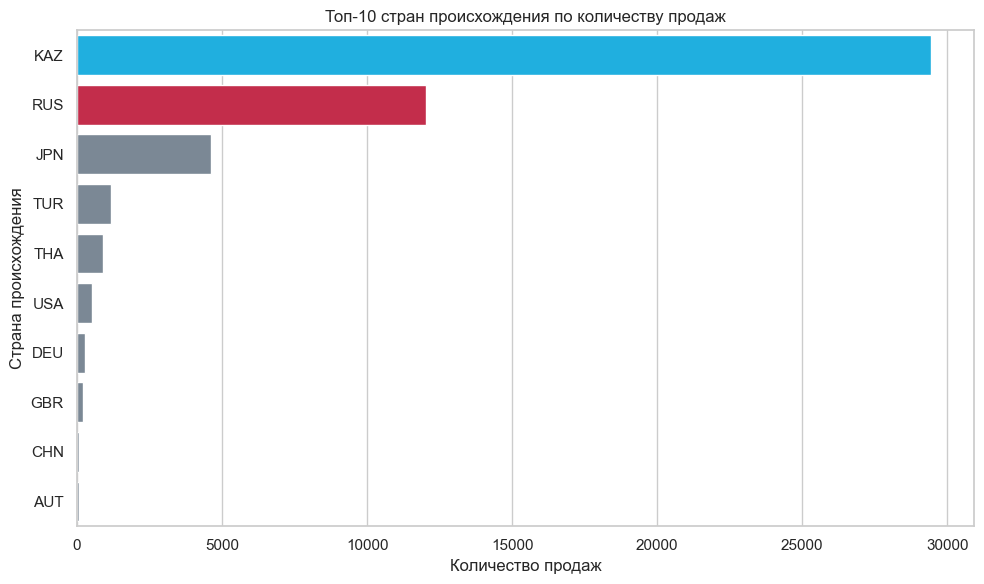

In [103]:
# Считаем количество продаж по странам
country_counts = data_query.groupby('country_origin')['quantity'].sum().sort_values(ascending=False).reset_index()
country_counts.columns = ['country_origin', 'count']

# Сортировка для топ-10 стран
order = country_counts['country_origin'].head(10)

# Формируем палитру: выделяем KAZ и RUS
palette = []
for country in order:
    if country == 'KAZ':
        palette.append('#00BFFF')  # голубой (Казахстан)
    elif country == 'RUS':
        palette.append('#DC143C')  # красный (Россия)
    else:
        palette.append('lightslategrey')

# Рисуем график с палитрой
plt.clf()  # очищаем текущий график
plt.figure(figsize=(10, 6))
sns.barplot(
    data=country_counts.head(10),
    x='count',
    y='country_origin',
    order=order,
    palette=palette
)

plt.title('Топ-10 стран происхождения по количеству продаж')
plt.xlabel('Количество продаж')
plt.ylabel('Страна происхождения')
plt.tight_layout()
plt.show();

Большинство проданных авто произведены в Казахстане - около 60%.\
Свыше 20% - из России.\
Япония - ~10%.\
И 5% - производство остальных стран.

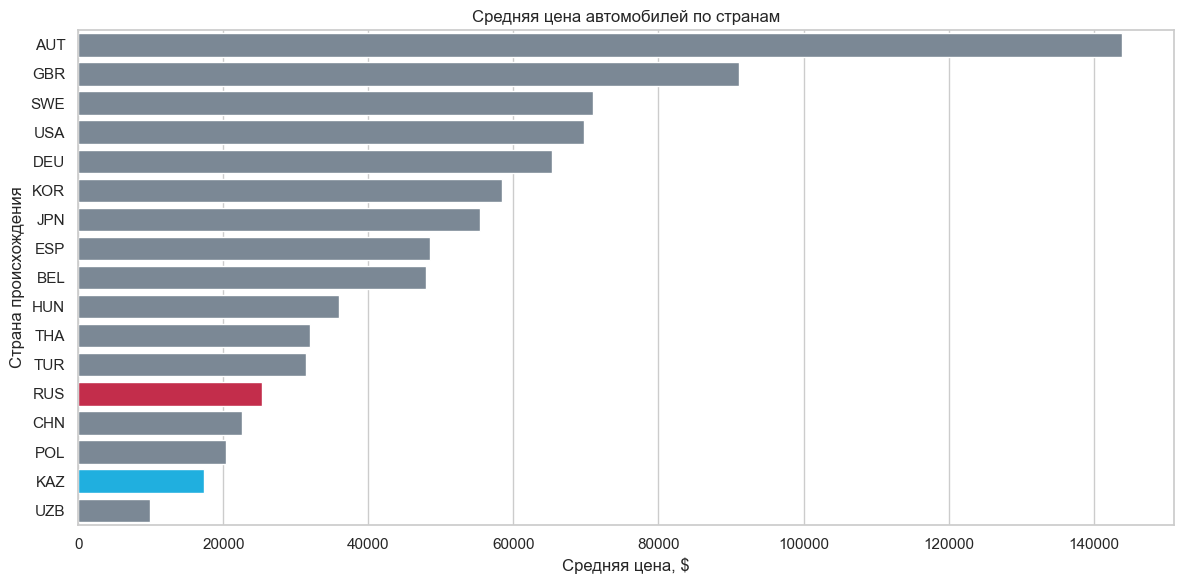

In [104]:
# Считаем взвешенную среднюю цену по странам
avg_price_by_country = data_query.groupby('country_origin', group_keys=False).apply(
    lambda g: pd.Series({'price_usd': (g['price_usd'] * g['quantity']).sum() / g['quantity'].sum()})
).reset_index()

# Сортируем
avg_price_by_country = avg_price_by_country.sort_values(by='price_usd', ascending=False).reset_index(drop=True)

# Получаем список стран в нужном порядке
ordered_countries = avg_price_by_country['country_origin']

# Задаём цвета для стран (по флагам или условно):
# KAZ — синий (цвет флага Казахстана), RUS — бело-сине-красный (возьмем красный)
# Остальные — по-умолчанию
palette = []
for country in ordered_countries:
    if country == 'KAZ':
        palette.append('#00BFFF')  # голубой/синий (KAZ)
    elif country == 'RUS':
        palette.append('#DC143C')  # красный (RUS)
    else:
        palette.append('lightslategrey')  # по-умолчанию для остальных

# Строим график
plt.figure(figsize=(12, 6))
sns.barplot(
    data=avg_price_by_country,
    x='price_usd',
    y='country_origin',
    order=ordered_countries,
    palette=palette
)
plt.title('Средняя цена автомобилей по странам')
plt.xlabel('Средняя цена, $')
plt.ylabel('Страна происхождения')
plt.tight_layout()
plt.show()

Авто из Казахстана и РФ - бюджетные, средние цены ниже Япониских в 2-3 раза.

In [105]:
# Группируем по стране
country_summary = data_query.groupby('country_origin').agg(
    sales_count=('quantity', 'sum'),             # Кол-во продаж (штук)
    avg_price_usd=('price_usd', 'mean'),         # Средняя цена
    total_sales_usd=('total_usd', 'sum')         # Общая выручка
).reset_index()

# Общие значения для долей
total_sales = country_summary['sales_count'].sum()
total_revenue = country_summary['total_sales_usd'].sum()

# Добавляем доли
country_summary['sales_share'] = (country_summary['sales_count'] / total_sales * 100).round(2).astype(str) + '%'
country_summary['revenue_share'] = (country_summary['total_sales_usd'] / total_revenue * 100).round(2).astype(str) + '%'

# Сортируем по выручке
country_summary = country_summary.sort_values(by='total_sales_usd', ascending=False).reset_index(drop=True)

# Выводим
country_summary.style.apply(
    lambda row: ['background-color: #00BFFF;' if row['country_origin']=='KAZ' 
                 else 'background-color: #DC143C;' if row['country_origin']=='RUS' 
                 else '' for _ in row], axis=1)

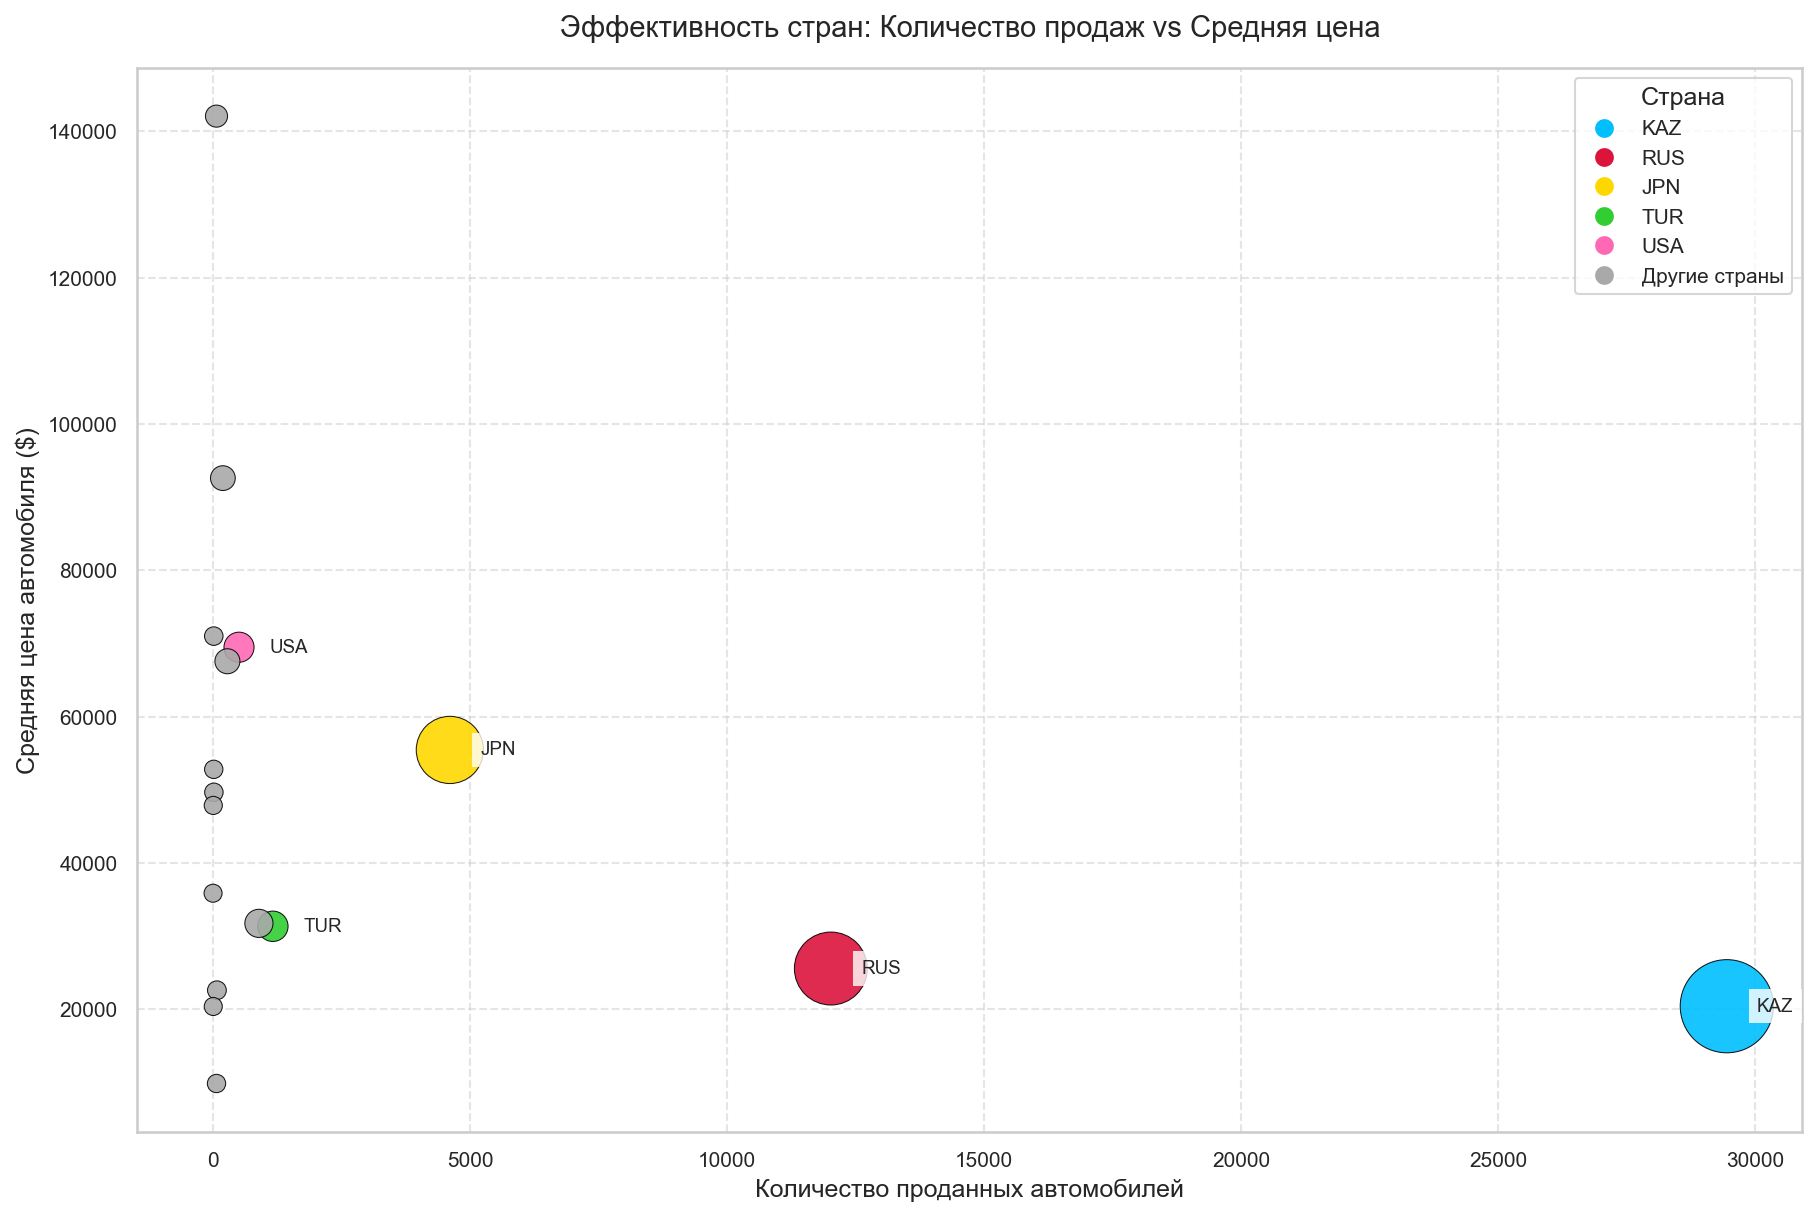

In [106]:
# Копируем таблицу
df = country_summary.copy()

# Определяем топ-5 стран по total_sales_usd
top_5_countries = df.nlargest(5, 'total_sales_usd')['country_origin'].tolist()

# Создаем словарь цветов: KAZ, RUS и топ-3 других стран получают уникальные цвета
color_map = {
    'KAZ': '#00BFFF',  # голубой (Казахстан)
    'RUS': '#DC143C'   # красный (Россия)
}
# Добавляем уникальные цвета для остальных стран из топ-5
available_colors = ['#FFD700', '#32CD32', '#FF69B4']  # желтый, зеленый, розовый
for i, country in enumerate([c for c in top_5_countries if c not in ['KAZ', 'RUS']][:3]):
    color_map[country] = available_colors[i]

# Применяем цвета: топ-5 стран — из color_map, остальные — серый
df['color'] = df['country_origin'].map(color_map).fillna('#A9A9A9')  # серый для остальных

# Создаем палитру для Seaborn, включая все цвета из color_map и серый
color_palette = {v: v for v in set(df['color'])}  # Все уникальные цвета из df['color']

plt.figure(figsize=(12, 8), constrained_layout=True, dpi=150)

# Создаем scatterplot
sns.scatterplot(
    data=df,
    x='sales_count',
    y='avg_price_usd',
    size='total_sales_usd',
    sizes=(75, 2000),
    hue='color',
    palette=color_palette,
    alpha=0.9,
    edgecolor='black',
    linewidth=0.5,
    legend=False
)

# Подписи для топ-5 стран
for i, row in df[df['country_origin'].isin(top_5_countries)].iterrows():
    plt.text(
        row['sales_count'] + 0.02 * df['sales_count'].max(),
        row['avg_price_usd'],
        row['country_origin'],
        fontsize=9,
        ha='left',
        va='center',
        bbox=dict(facecolor='white', alpha=0.8, edgecolor='none')
    )

# Создаем легенду автоматически на основе уникальных цветов и стран
unique_colors = df[['country_origin', 'color']].drop_duplicates().set_index('color')['country_origin'].to_dict()
plt.legend(
    [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10) for color in unique_colors.keys()],
    [country if country in top_5_countries else 'Другие страны' for country in unique_colors.values()],
    title='Страна',
    fontsize=10,
    title_fontsize=12,
    loc='best'
)

# Настраиваем заголовок и подписи осей
plt.title('Эффективность стран: Количество продаж vs Средняя цена', fontsize=14, pad=15)
plt.xlabel('Количество проданных автомобилей', fontsize=12)
plt.ylabel('Средняя цена автомобиля ($)', fontsize=12)

# Настраиваем масштаб и подписи
plt.tick_params(axis='both', labelsize=10)
plt.grid(True, linestyle='--', alpha=0.5)

plt.show()

На диаграмме рассеяния мы видим, что большая часть выручки с проданных автомобилей в 2019 году - за счет местного производства. В основном это бюджетные автомобили.\
В два раза меньше - у России и Японии. Однако, если Япония берёт стоимостью, то Россия - количеством.

### Тип топлива

In [107]:
# Сводная таблица по топливу с учетом количества и выручки
fuel_summary = data.groupby('fuel_type').agg(
    sales_count=('quantity', 'sum'),                 # суммарное количество продаж
    total_revenue_usd=('total_usd', 'sum')           # суммарная выручка
).reset_index()

# Среднюю цену считаем корректно: общая выручка / общее количество
fuel_summary['avg_price_usd'] = fuel_summary['total_revenue_usd'] / fuel_summary['sales_count']

# Считаем доли
total_qty = fuel_summary['sales_count'].sum()
total_rev = fuel_summary['total_revenue_usd'].sum()

fuel_summary['sales_share'] = (fuel_summary['sales_count'] / total_qty * 100).round(2).astype(str) + '%'
fuel_summary['revenue_share'] = (fuel_summary['total_revenue_usd'] / total_rev * 100).round(2).astype(str) + '%'

# Сортировка по выручке
fuel_summary = fuel_summary.sort_values(by='total_revenue_usd', ascending=False).reset_index(drop=True)

display(fuel_summary)


fuel_type  sales_count  total_revenue_usd  avg_price_usd sales_share  \
0         F        48055      1147211107.58       23872.88      97.25%   
1         D         1344        72861382.87       54212.34       2.72%   
2       HYB           10          614939.02       61493.90       0.02%   
3         E            3          343039.04      114346.35       0.01%   

  revenue_share  
0        93.95%  
1         5.97%  
2         0.05%  
3         0.03%

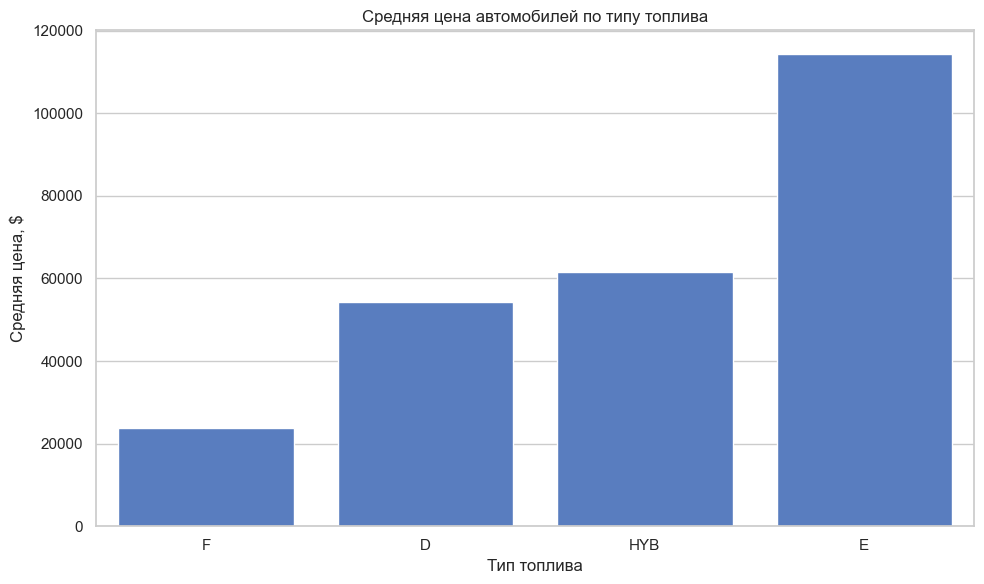

In [108]:
# построим график
plt.figure(figsize=(10, 6))
sns.barplot(data=fuel_summary, y='avg_price_usd', x='fuel_type')
plt.title('Средняя цена автомобилей по типу топлива')
plt.ylabel('Средняя цена, $')
plt.xlabel('Тип топлива')
plt.tight_layout()
plt.show()


Для выводов по гибридам и электродвигателям у нас мало данных. Среди E - 3 дорогих Jaguar I-Pace производства Великобритании.\
Предварительно:
- автомобили с дизельным двигателем в среднем дороже, чем с бензиновым, а гибрид дороже дизеля.

### Объём двигателя

Анализ столбца `engine_capacity_l` (объём двигателя) важен для понимания распределения моделей по мощности, выявления аномалий и зависимости от других факторов (цены, типа авто и пр.).

In [109]:
# описание данных
data_query['engine_capacity_l'].describe()

count   36614.00
mean        2.36
std         1.25
min         0.00
25%         1.60
50%         2.00
75%         2.50
max        12.80
Name: engine_capacity_l, dtype: float64

Медиана размера двигателей - 2 литра.\
Минимум 0 - мы поставили у электродвигателей.\
Максимум 12.8 - грузовики, самосвалы.\

Основная масса (между Q1 и Q3) - легковые авто 1.6-2.5 литров.

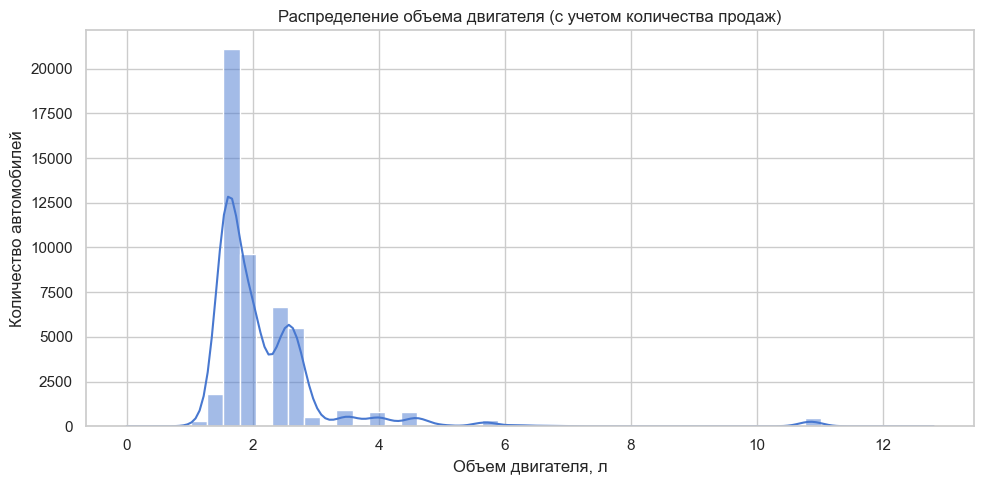

In [110]:
# 1. Распределение объема двигателя с учетом количества продаж
plt.figure(figsize=(10, 5))

# Строим гистограмму, где каждый двигатель учитывается с весомом quantity
sns.histplot(
    data=data_query,
    x='engine_capacity_l',
    weights='quantity',  # учитываем, сколько таких авто было продано
    bins=50,
    kde=True,
)

plt.title('Распределение объема двигателя (с учетом количества продаж)')
plt.xlabel('Объем двигателя, л')
plt.ylabel('Количество автомобилей')
plt.tight_layout()
plt.show()

Гистограмма подтверждает, что основная масса автомобилей в диапазоне 1.6-2.5 литров. С 6 до 10 литров практически нет авто в продаже.\
И 10.85 - объем двигателя у Камаза и ему подобных.

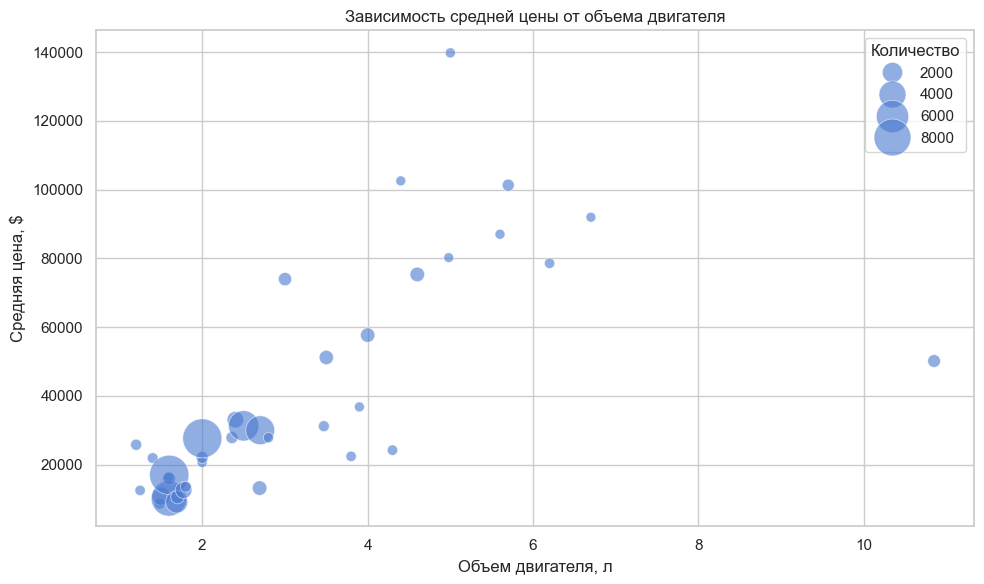

In [111]:
# Зависимость объема двигателя и средней цены (весим среднее по quantity)
# Группируем по объему двигателя, считаем среднюю цену и общее количество

engine_stats = data_query.groupby('engine_capacity_l').agg(
    total_quantity=('quantity', 'sum'),
    avg_price_usd=('price_usd', 'mean')
).reset_index()

# Отбрасываем редкие значения с малым количеством
engine_stats = engine_stats[engine_stats['total_quantity'] > 20]

# Строим график
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=engine_stats,
    x='engine_capacity_l',
    y='avg_price_usd',
    size='total_quantity',
    sizes=(50, 800),
    alpha=0.6
)

plt.title('Зависимость средней цены от объема двигателя')
plt.xlabel('Объем двигателя, л')
plt.ylabel('Средняя цена, $')
plt.legend(title='Количество')
plt.tight_layout()
plt.show()


Мы видим, что в категории легковых авто цена прямо зависит от объема двигателя. Что доказывает в том числе и транспортный налог.


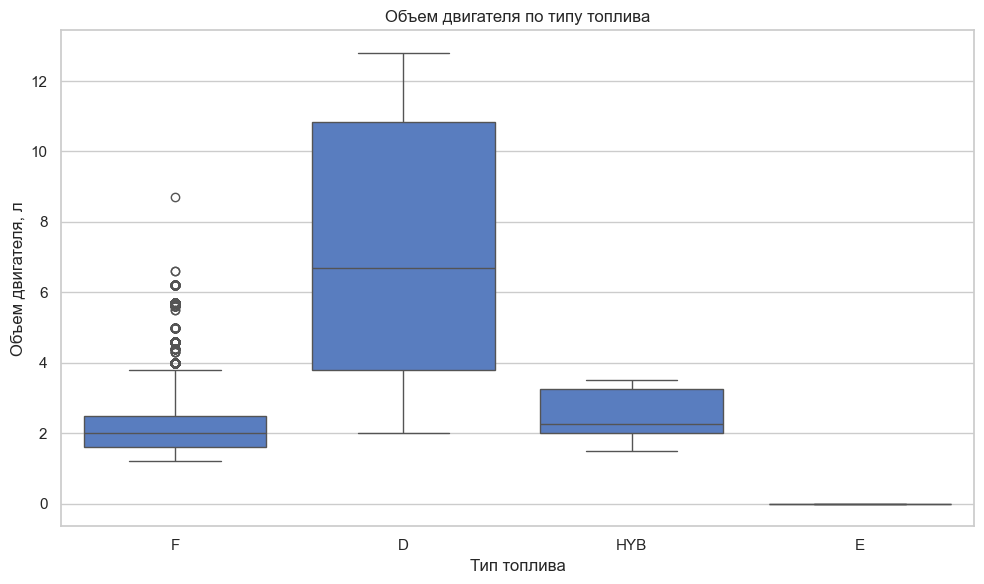

In [112]:
# 4. Объем двигателя по типу топлива (учитываем количество)
plt.figure(figsize=(10, 6))

# Группируем по типу топлива и объему двигателя
fuel_engine_stats = data.groupby(['fuel_type', 'engine_capacity_l']).agg(
    total_quantity=('quantity', 'sum')
).reset_index()

# Строим график: объем двигателя по топливу, учитываем число автомобилей
sns.boxplot(
    data=data,
    x='fuel_type',
    y='engine_capacity_l',
)

plt.title('Объем двигателя по типу топлива')
plt.xlabel('Тип топлива')
plt.ylabel('Объем двигателя, л')
plt.tight_layout()

Судя по графику, бензиновые и гибридные двигатели имеют более низкие объемы двигателя, чем дизельные.\
Это связано с тем, что дизель часто используется в коммерческом авто.

### Тип передачи

Посмотрим, какой тип трансмиссии более популярен

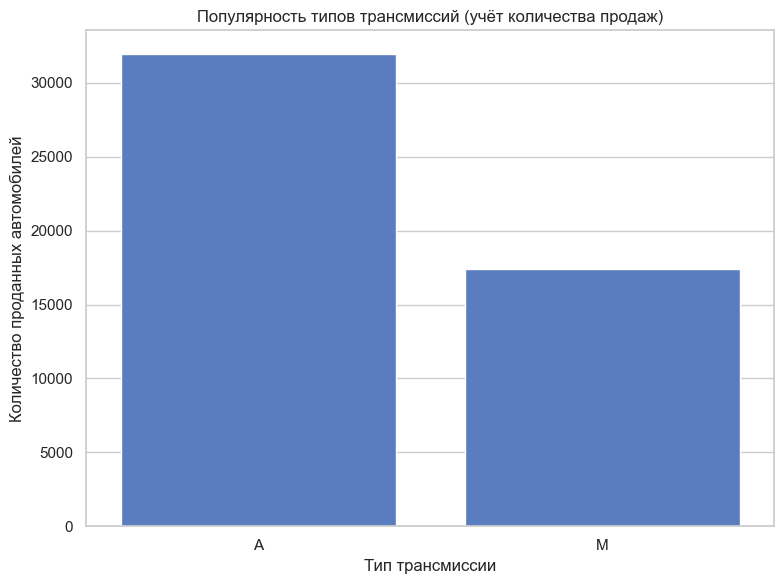

In [113]:
# Группируем по типу трансмиссии и суммируем количество проданных авто
transmission_stats = data_query.groupby('transmission').agg(
    total_quantity=('quantity', 'sum')
).reset_index().sort_values(by='total_quantity', ascending=False)

# Строим график
plt.figure(figsize=(8, 6))
sns.barplot(
    data=transmission_stats,
    y='total_quantity',
    x='transmission',
    alpha=1,
)
plt.title('Популярность типов трансмиссий (учёт количества продаж)')
plt.ylabel('Количество проданных автомобилей')
plt.xlabel('Тип трансмиссии')
plt.tight_layout()
plt.show()

Посмотрим среднюю цену

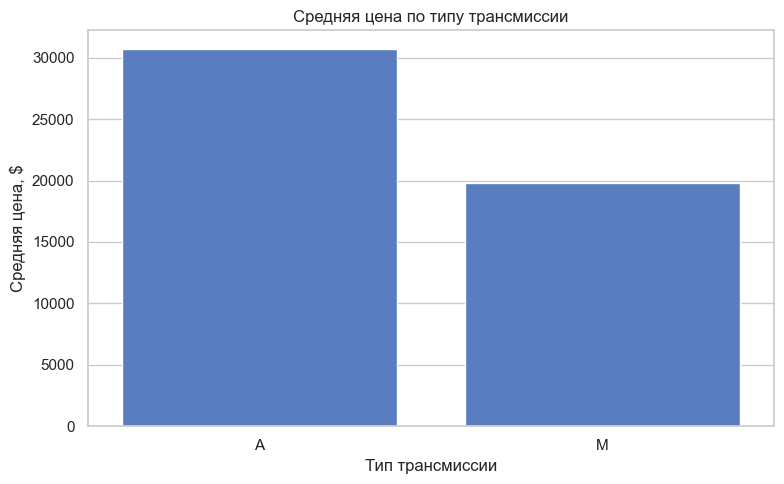

In [114]:
# Средняя цена по типу трансмиссии
# transmission_price = data_query.loc[data_query['segment'] == 'некоммерческий'].groupby('transmission').agg(
transmission_price = data_query.groupby('transmission').agg(
    avg_price_usd=('price_usd', 'mean'),
    total_quantity=('quantity', 'sum')
).reset_index().sort_values(by='avg_price_usd', ascending=False)

# График средней цены
plt.figure(figsize=(8, 5))
sns.barplot(
    data=transmission_price,
    y='avg_price_usd',
    x='transmission',
)
plt.title('Средняя цена по типу трансмиссии')
plt.ylabel('Средняя цена, $')
plt.xlabel('Тип трансмиссии')
plt.tight_layout()
plt.show()

Автомат дороже механики на 50% в среднем.

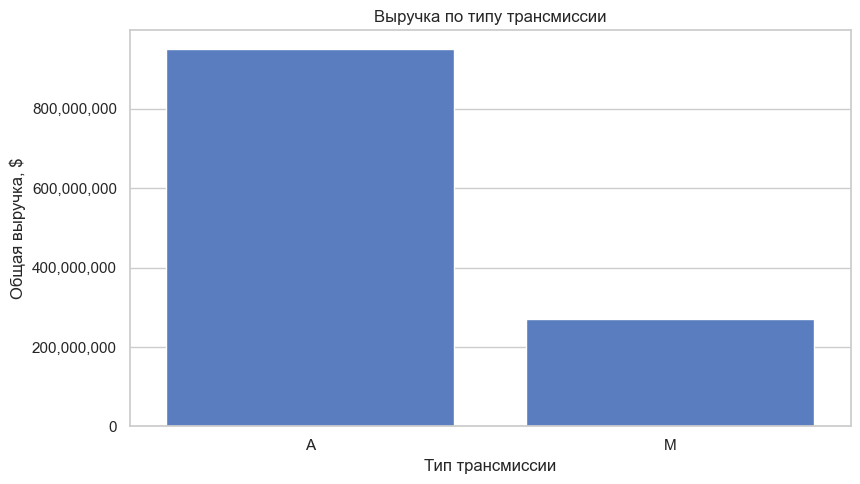

In [115]:
# Группируем и считаем выручку
transmission_revenue = data_query.groupby('transmission').agg(
    total_revenue=('total_usd', 'sum')
).reset_index().sort_values(by='total_revenue', ascending=False)

plt.figure(figsize=(8, 5))
sns.barplot(
    data=transmission_revenue,
    y='total_revenue',
    x='transmission',
)
plt.title('Выручка по типу трансмиссии')
plt.ylabel('Общая выручка, $')
plt.xlabel('Тип трансмиссии')
plt.tight_layout()
plt.gca().yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}')); # Формат без экспоненты
plt.show()


Автомат дороже, его чаще покупают, поэтому выручка кратно выше.

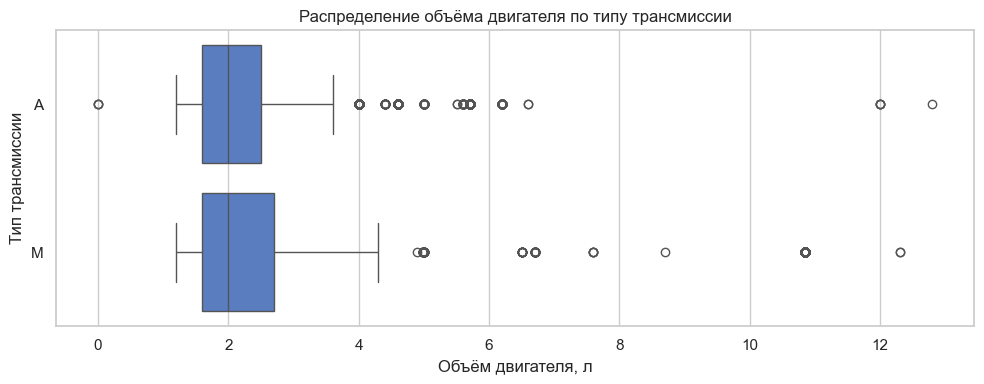

In [116]:
plt.figure(figsize=(10, 4))
sns.boxplot(
    data=data_query,
    y='transmission',
    x='engine_capacity_l',
)
plt.title('Распределение объёма двигателя по типу трансмиссии')
plt.ylabel('Тип трансмиссии')
plt.xlabel('Объём двигателя, л')
plt.tight_layout()
plt.show()

- Автоматическая трансмиссия — самый популярный тип в продаже.
- Средняя цена автомобилей с автоматической трансмиссией выше, чем с механической.
- Объём двигателя у автомобилей с автоматом по медиане равен автомобилям с механикой, однако у механики выше разброс (усы).
- Тип трансмиссии напрямую влияет на спрос, выручку и позиционирование автомобиля. В связи с более высокой ценой и спросом выручка кратно выше.

### Тип привода

Посмотрим, что чаще продается.

In [117]:
data_query.groupby(['drive_type'])['quantity'].sum().reset_index().assign(rate = lambda x: x['quantity']/x['quantity'].sum())

drive_type  quantity  rate
0        2WD     30102  0.61
1        4WD     19289  0.39

Мы видим, что 61% автомобилей имеют одну ведущую ось, и 39% - полноприводные, что составляет существенное количество.

### Цена

Изучим распределение цен, выявим выбросы и аномалии, а также посмотрим зависимости с другими признаками (категориальными и числовыми).

In [118]:
data_query['price_usd'].describe()

count    36773.00
mean     28223.02
std      19124.00
min       7100.00
25%      15788.90
50%      24566.72
75%      32505.66
max     305252.02
Name: price_usd, dtype: float64

Медиана цен - $24500, а максимум больше 300 тысяч. Похоже на аномалии.\
Посмотрим на графике.

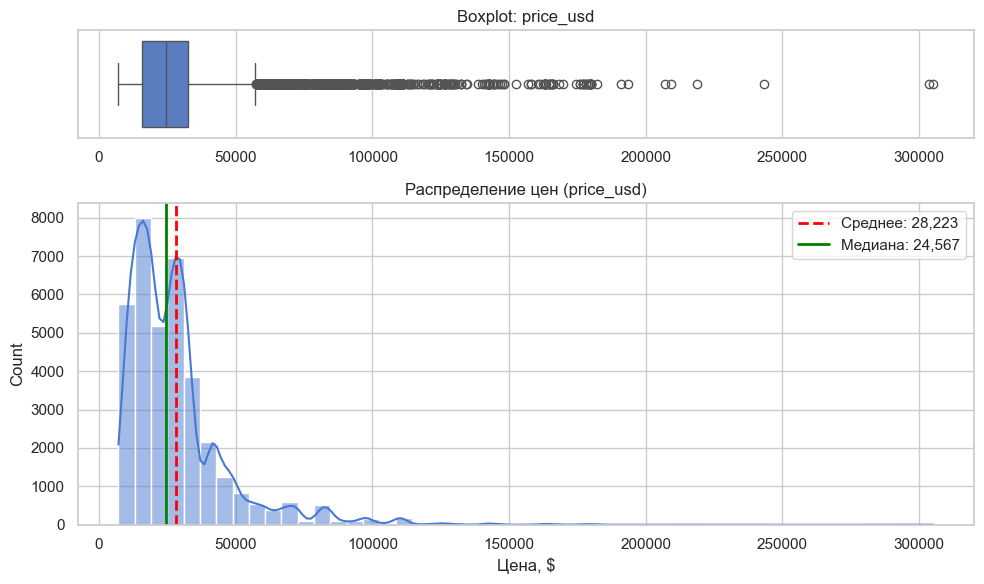

In [119]:
# Считаем среднее и медиану
mean_price = data_query['price_usd'].mean()
median_price = data_query['price_usd'].median()

# Создаём фигуру с двумя графиками
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 6), height_ratios=[1, 3])

# Boxplot сверху
sns.boxplot(data=data_query, x='price_usd', ax=axes[0])
axes[0].set(title='Boxplot: price_usd')
axes[0].set(xlabel='')

# Гистограмма снизу
sns.histplot(data=data_query, x='price_usd', bins=50, kde=True, ax=axes[1])

# Добавляем вертикальные линии на гистограмму
axes[1].axvline(mean_price, color='red', linestyle='--', linewidth=2, label=f'Среднее: {mean_price:,.0f}')
axes[1].axvline(median_price, color='green', linestyle='-', linewidth=2, label=f'Медиана: {median_price:,.0f}')

axes[1].set(title='Распределение цен (price_usd)', xlabel='Цена, $')
axes[1].legend()

plt.tight_layout()
plt.show()


Судя по графикам, цены выше 120-150 тысяч - аномально высоки.

In [120]:
print(f'999-й квантиль - {data_query['price_usd'].quantile(.999)}')
data_query.loc[data_query['price_usd'] > data_query['price_usd'].quantile(.999)]

999-й квантиль - 164464.004


company                 brand        model  \
9699   Hyundai Com Trans Kazakhstan   Hyundai Truck & Bus     Universe   
9700   Hyundai Com Trans Kazakhstan   Hyundai Truck & Bus     Universe   
18733         Almaty Motors Premium            Land Rover  Range Rover   
18734                  TERRA MOTORS            Land Rover  Range Rover   
18735                  TERRA MOTORS            Land Rover  Range Rover   
18736                  TERRA MOTORS            Land Rover  Range Rover   
18737                  TERRA MOTORS            Land Rover  Range Rover   
18742         Almaty Motors Premium            Land Rover  Range Rover   
18749                  TERRA MOTORS            Land Rover  Range Rover   
18750                  TERRA MOTORS            Land Rover  Range Rover   
18751                  TERRA MOTORS            Land Rover  Range Rover   
18758                  TERRA MOTORS            Land Rover  Range Rover   
18759         Almaty Motors Premium            Land Rover  Range Rover   
18761         Almaty Motors Premium            Land Rover  Range Rover   
18767                  TERRA MOTORS            Land Rover  Range Rover   
18772         Almaty Motors Premium            Land Rover  Range Rover   
18777                  TERRA MOTORS            Land Rover  Range Rover   
18781         Almaty Motors Premium            Land Rover  Range Rover   
18782         Almaty Motors Premium            Land Rover  Range Rover   
18797                  TERRA MOTORS            Land Rover  Range Rover   
18798                  TERRA MOTORS            Land Rover  Range Rover   
18799                  TERRA MOTORS            Land Rover  Range Rover   
18802         Almaty Motors Premium            Land Rover  Range Rover   
18804                  TERRA MOTORS            Land Rover  Range Rover   
18805                  TERRA MOTORS            Land Rover  Range Rover   
18807                  TERRA MOTORS            Land Rover  Range Rover   
18808                  TERRA MOTORS            Land Rover  Range Rover   
20345                   Autokapital         Mercedes-Benz      G-Class   
20346                   Autokapital         Mercedes-Benz      G-Class   
20347                   Autokapital         Mercedes-Benz      G-Class   
20348                   Autokapital         Mercedes-Benz      G-Class   
20349                   Autokapital         Mercedes-Benz      G-Class   
20350                   Autokapital         Mercedes-Benz      G-Class   
20402                   Autokapital  Mercedes-Benz Trucks     Tourismo   
20403                   Autokapital  Mercedes-Benz Trucks     Tourismo   
21922                   Mercur Auto               Porsche     Panamera   

       release_year country_origin fuel_type  engine_capacity_l transmission  \
9699           2017            KOR         D              12.30            M   
9700           2017            KAZ         D              12.30            M   
18733          2018            GBR         F               5.00            A   
18734          2018            GBR         F               5.00            A   
18735          2018            GBR         F               5.00            A   
18736          2018            GBR         F               5.00            A   
18737          2019            GBR         F               5.00            A   
18742          2019            GBR         F               5.00            A   
18749          2018            GBR         F               5.00            A   
18750          2019            GBR         F               5.00            A   
18751          2019            GBR         F               5.00            A   
18758          2019            GBR         F               5.00            A   
18759          2018            GBR         F               5.00            A   
18761          2019            GBR         F               5.00            A   
18767          2019            GBR         F               5.00            A   
18772    

Мы видим, что среди авто с высокой ценой - премиум сегмент, автобусы от Mercedes-Benz. Цены соответствуют действительности, не аномалия.

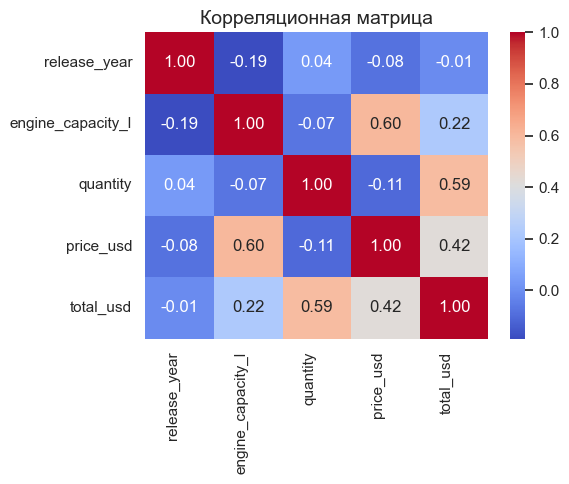

In [121]:
plt.figure(figsize=(6, 5))  # увеличь при необходимости до (16, 12)
sns.heatmap(data.corr(numeric_only=True), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Корреляционная матрица', fontsize=14)
plt.xticks(rotation=90, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

- Самая сильная положительная корреляция — с объёмом двигателя (engine_capacity_l, 0.60), что логично: машины с большим объёмом двигателя стоят дороже.
- Умеренная положительная связь между ценой и общей выручкой (total_usd, 0.42) — это ожидаемо, так как цена входит в расчёт выручки.
- Слабая отрицательная корреляция с количеством проданных штук (quantity, –0.11) — дорогие машины чаще покупают в меньшем количестве.
- Также слабая отрицательная связь с годом выпуска (release_year, –0.08) — вероятно, связано с особенностями выборки (более старые авто премиальные).

In [122]:
# Средняя цена по типу топлива
fuel_price = data_query.groupby('fuel_type')['price_usd'].mean().sort_values(ascending=False).reset_index()
display(fuel_price)

# Средняя цена по типу привода
drive_price = data_query.groupby('drive_type')['price_usd'].mean().sort_values(ascending=False).reset_index()
display(drive_price)

# Средняя цена по типу трансмиссии
trans_price = data_query.groupby('transmission')['price_usd'].mean().sort_values(ascending=False).reset_index()
display(trans_price)


fuel_type  price_usd
0         E  114346.35
1       HYB   61493.90
2         D   51399.53
3         F   27475.42

drive_type  price_usd
0        4WD   37086.09
1        2WD   21781.01

transmission  price_usd
0            A   30688.76
1            M   19834.96

- Гибриды (HYB) и дизельные авто (D) также значительно дороже бензиновых (F).
- Полный привод (4WD) почти в 1.7 раза дороже переднего/заднего привода (2WD).
- Автомобили с автоматической коробкой передач (A) почти на 55% дороже механических (M).

### Регион и область

Проверим, отличаются ли у нас регион и область продажи.

In [123]:
data_query.groupby(['province', 'region'])['quantity'].sum().reset_index().sort_values(by=['province', 'quantity'], ascending=[True, False])

province            region  quantity
0              Акмолинская область          Кокшетау       812
1              Актюбинская область            Актобе      1680
3              Алматинская область       Талдыкорган       361
2              Алматинская область          Каскелен        64
4                           Алматы            Алматы     12673
5               Атырауская область            Атырау      3175
8   Восточно-казахстанская область  Усть-каменогорск      1994
7   Восточно-казахстанская область             Семей       694
6   Восточно-казахстанская область            Риддер         4
9               Жамбылская область             Тараз       558
10   Западно-казахстанская область           Уральск      2035
11          Карагандинская область         Караганда      2592
12            Костанайская область          Костанай      2979
13            Костанайская область            Рудный        47
14          Кызылординская область         Кызылорда       744
15           Мангистауская область             Актау      1926
16                      Нур-султан        Нур-султан      9296
17            Павлодарская область          Павлодар      1698
18            Павлодарская область         Экибастуз       157
19    Северо-казахстанская область     Петропавловск       820
21           Туркестанская область         Туркестан        15
20           Туркестанская область          Сарыагаш         4
22                         Шымкент           Шымкент      3586
23                 Экспорт область           Экспорт      1477

Судя по таблице - `region` (регион изначально в данных) - это скорее город/район продажи.\
А `province` (область) - и в самом деле область.

Посмотрим, что продавалось в `Экспорт`. Что это за регион.

In [124]:
# отфильтруем
data_query.loc[data_query['region'] == 'Экспорт']

company    brand   model  release_year country_origin fuel_type  \
4838   Astana Motors  Hyundai  Accent          2019            KAZ         F   
4839   Astana Motors  Hyundai  Accent          2019            KAZ         F   
4840   Astana Motors  Hyundai  Accent          2019            KAZ         F   
4841   Astana Motors  Hyundai  Accent          2019            KAZ         F   
4842   Astana Motors  Hyundai  Accent          2019            KAZ         F   
...              ...      ...     ...           ...            ...       ...   
39356     Allur Auto      Jac     N56          2019            KAZ         D   
39357     Allur Auto      Jac     N56          2019            KAZ         D   
39358     Allur Auto      Jac     N56          2019            KAZ         D   
39359     Allur Auto      Jac     N56          2019            KAZ         D   
39360     Allur Auto      Jac     N56          2019            KAZ         D   

       engine_capacity_l transmission drive_type   region  quantity  \
4838                1.60            M        2WD  Экспорт         1   
4839                1.60            M        2WD  Экспорт         1   
4840                1.60            M        2WD  Экспорт         1   
4841                1.60            M        2WD  Экспорт         1   
4842                1.60            M        2WD  Экспорт         1   
...                  ...          ...        ...      ...       ...   
39356               2.70            M        2WD  Экспорт         1   
39357               2.70            M        2WD  Экспорт         1   
39358               2.70            M        2WD  Экспорт         1   
39359               2.70            M        2WD  Экспорт         1   
39360               2.70            M        2WD  Экспорт         1   

       price_usd  total_usd         province             segment_2013  \
4838    13404.36   13404.36  Экспорт область      Легковые автомобили   
4839    13404.36   13404.36  Экспорт область      Легковые автомобили   
4840    13404.36   13404.36  Экспорт область      Легковые автомобили   
4841    13404.36   13404.36  Экспорт область      Легковые автомобили   
4842    13404.36   13404.36  Экспорт область      Легковые автомобили   
...          ...        ...              ...                      ...   
39356   14813.40   14813.40  Экспорт область  Коммерческие автомобили   
39357   14800.00   14800.00  Экспорт область  Коммерческие автомобили   
39358   14800.00   14800.00  Экспорт область  Коммерческие автомобили   
39359   14800.00   14800.00  Экспорт область  Коммерческие автомобили   
39360   14800.00   14800.00  Экспорт область  Коммерческие автомобили   

                    class_2013  sale_date segment  
4838                   B класс 2019-09-30     b2c  
4839                   B класс 2019-09-30     b2c  
4840                   B класс 2019-09-30     b2c  
4841                   B класс 2019-09-30     b2c  
4842                   B класс 2019-09-30     b2c  
...                        ...        ...     ...  
39356  Малотоннажные грузовики 2019-08-31     b2b  
39357  Малотоннажные грузовики 2019-08-31     b2b  
39358  Малотоннажные грузовики 2019-08-31     b2b  
39359  Малотоннажные грузовики 2019-08-31     b2b  
39360  Малотоннажные грузовики 2019-08-31     b2b  

[1477 rows x 18 columns]

Сразу общие тенденции экспорта не видны.\
Рассмотрим подробнее.

In [125]:
# Фильтруем по региону "Экспорт" и количеству > 0
export_data = data_query.loc[
    (data_query['region'] == 'Экспорт') & 
    (data_query['quantity'] > 0)
].copy()

# # Удаляем неиспользуемые категории, если столбцы категориальные
# cat_cols = ['company', 'brand', 'country_origin', 'segment_2013', 'segment']
# for col in cat_cols:
#     if col in export_data.columns and export_data[col].dtype.name == 'category':
#         export_data[col] = export_data[col].cat.remove_unused_categories()

# Проверим размер выборки
print(f"Количество записей по экспорту: {export_data.shape[0]}")

print('\n','=' * 50)
# Сводная информация по компаниям
export_by_company = export_data.groupby('company')['quantity'].sum().sort_values(ascending=False)
print("Топ компаний по экспорту:")
display(export_by_company.head(10).reset_index())

print('\n','=' * 50)
# Сводная информация по брендам
export_by_brand = export_data.groupby('brand')['quantity'].sum().sort_values(ascending=False)
print("\nТоп брендов по экспорту:")
display(export_by_brand.head(10).reset_index())

print('\n','=' * 50)
# Страны происхождения
export_by_country = export_data.groupby('country_origin')['quantity'].sum().sort_values(ascending=False)
print("\nСтраны производства (по количеству):")
display(export_by_country.reset_index())

print('\n','=' * 50)
# Сегменты 2013 года
export_by_segment_2013 = export_data.groupby('segment_2013')['quantity'].sum().sort_values(ascending=False)
print("\nsegment_2013:")
display(export_by_segment_2013.reset_index())

print('\n','=' * 50)
# Новый сегмент (если есть)
if 'segment' in export_data.columns:
    export_by_segment = export_data.groupby('segment')['quantity'].sum().sort_values(ascending=False)
    print("\nsegment:")
    display(export_by_segment.reset_index())

# Считаем общие метрики по экспорту отдельно
total_quantity = export_data['quantity'].sum()
avg_price = export_data['price_usd'].mean()
total_revenue = export_data['total_usd'].sum()

print('\n','=' * 50)
# Форматируем вывод
print("Сводные показатели по экспорту:")
print(f"- Общее количество проданных автомобилей: {int(total_quantity):,}")
print(f"- Средняя цена автомобиля: ${avg_price:,.2f}")
print(f"- Общая выручка: ${total_revenue:,.2f}")



Количество записей по экспорту: 1477

Топ компаний по экспорту:


company  quantity
0               Allur Auto      1047
1  Toyota Motor Kazakhstan       270
2            Astana Motors       160



Топ брендов по экспорту:


brand  quantity
0      Jac       911
1   Toyota       221
2  Hyundai       160
3    Ravon       136
4    Lexus        49



Страны производства (по количеству):


country_origin  quantity
0            KAZ      1207
1            JPN       121
2            RUS        95
3            TUR        40
4            THA        14



segment_2013:


segment_2013  quantity
0             Внедорожники       997
1      Легковые автомобили       399
2  Коммерческие автомобили        67
3                   Пикапы        14



segment:


segment  quantity
0     b2c      1410
1     b2b        67


Сводные показатели по экспорту:
- Общее количество проданных автомобилей: 1,477
- Средняя цена автомобиля: $21,255.08
- Общая выручка: $31,393,758.94


- Всего зафиксировано 1477 экспортных продаж, из которых 95% — некоммерческие автомобили;
- Основной экспорт осуществляет компания Allur Auto (более 70% от общего объёма);
- Лидирующие бренды по экспорту: Jac, Toyota, Hyundai и Ravon;
- Более 80% экспортируемых автомобилей произведены в Казахстане;
- Основной сегмент экспорта — внедорожники.

### 'total_usd'

Посмотрим общую информацию о суммах продаж

In [126]:
# базовая статистика
data_query['total_usd'].describe()

count     36773.00
mean      33190.46
std       45969.67
min        7100.00
25%       17078.32
50%       26473.28
75%       34832.77
max     3778206.26
Name: total_usd, dtype: float64

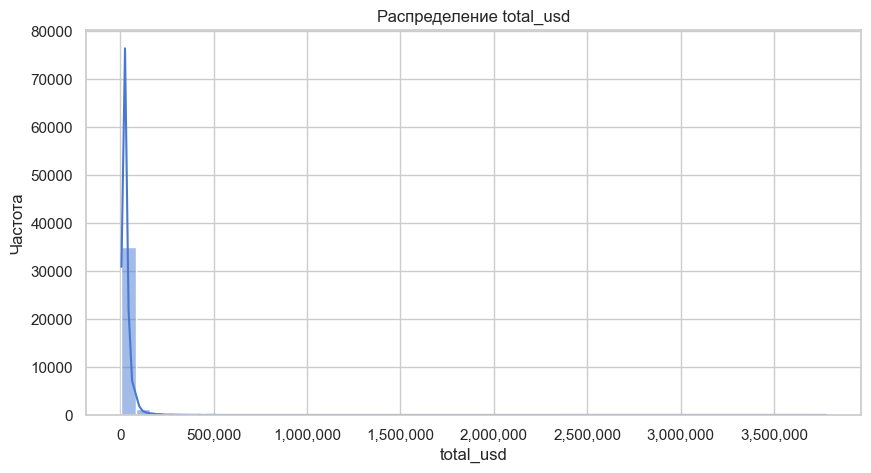

In [127]:
# Распределение значений (гистограмма + KDE)
plt.figure(figsize=(10, 5))
sns.histplot(data_query['total_usd'], bins=50, kde=True)
plt.title('Распределение total_usd')
plt.xlabel('total_usd')
plt.ylabel('Частота')
# plt.xlim(0, data_query['total_usd'].quantile(0.99))  # обрезаем правый хвост
plt.gca().xaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}')); # Формат без экспоненты
plt.show()

В основной массе продажи не превышали сумму в $100 тысяч. Однако существуют продажи суммой вплоть до $3.5 млн.

In [128]:
# посмотрим на 10 самых крупных продаж
data_query.loc[(data_query['total_usd'] > data_query['total_usd'].quantile(0.999))].sort_values(by='total_usd', ascending=False).head(10)

company          brand      model  release_year  \
39561  Daewoo Bus Kazakhstan         Daewoo     BC 095          2019   
39553  Daewoo Bus Kazakhstan         Daewoo  BC 211 MA          2019   
39560  Daewoo Bus Kazakhstan         Daewoo     BC 095          2019   
25555             БИПЭК АВТО          Skoda    Octavia          2019   
38710  Daewoo Bus Kazakhstan         Daewoo   BS 106 D          2019   
20349            Autokapital  Mercedes-Benz    G-Class          2019   
20358            Autokapital  Mercedes-Benz    G-Class          2019   
16885             БИПЭК АВТО           Lada        4x4          2019   
16299             БИПЭК АВТО            Kia        Rio          2019   
25658             БИПЭК АВТО          Skoda     Superb          2019   

      country_origin fuel_type  engine_capacity_l transmission drive_type  \
39561            KAZ         D               2.50            M        2WD   
39553            KAZ         D               2.50            M        2WD   
39560            KAZ         D               2.50            M        2WD   
25555            KAZ         F               1.40            M        2WD   
38710            KAZ         D               2.50            M        2WD   
20349            AUT         F               4.00            A        4WD   
20358            AUT         F               4.00            A        4WD   
16885            KAZ         F               1.69            M        4WD   
16299            KAZ         F               1.60            A        2WD   
25658            KAZ         F               2.00            A        2WD   

           region  quantity  price_usd  total_usd  \
39561       Семей        50   75564.13 3778206.26   
39553       Семей        30  105260.39 3157811.64   
39560       Семей        30   75912.26 2277367.68   
25555       Тараз       100   18700.00 1870000.00   
38710      Атырау        16   74986.11 1199777.77   
20349      Алматы         7  165224.10 1156568.72   
20358      Алматы         7  163222.68 1142558.75   
16885       Тараз       115    9000.00 1035000.00   
16299      Алматы        63   13500.00  850500.00   
25658  Нур-султан        23   35588.25  818529.75   

                             province             segment_2013  \
39561  Восточно-казахстанская область  Коммерческие автомобили   
39553  Восточно-казахстанская область  Коммерческие автомобили   
39560  Восточно-казахстанская область  Коммерческие автомобили   
25555              Жамбылская область      Легковые автомобили   
38710              Атырауская область  Коммерческие автомобили   
20349                          Алматы             Внедорожники   
20358                          Алматы             Внедорожники   
16885              Жамбылская область             Внедорожники   
16299                          Алматы      Легковые автомобили   
25658                      Нур-султан      Легковые автомобили   

               class_2013  sale_date segment  
39561    Большие автобусы 2019-07-31     b2b  
39553    Большие автобусы 2019-05-31     b2b  
39560    Большие автобусы 2019-06-30     b2b  
25555             C класс 2019-07-31     b2b  
38710    Большие автобусы 2019-03-31     b2b  
20349  Полноразмерные SUV 2019-06-30     b2b  
20358  Полноразмерные SUV 2019-08-31     b2b  
16885   Субкомпактные SUV 2019-05-31     b2b  
16299             B класс 2019-04-30     b2b  
25658             D класс 2019-02-28     b2b

Мы можем убрать все аномально высокие оптовые продажи, но тогда у нас не будет понимания о продажа в секторе b2b. Оставляем, но принимаем во внимание.

### 'segment_2013' и 'class_2013'

Посмотрим, какие типы сегментов присутствуют в данных (segment_2013), как они распределены по количеству автомобилей и выручке. Проверим наличие аномалий, нулевых продаж и сделаем визуализацию.

Уникальные значения segment_2013:
['Легковые автомобили' 'Внедорожники' 'Коммерческие автомобили' 'Минивэны'
 'Пикапы']


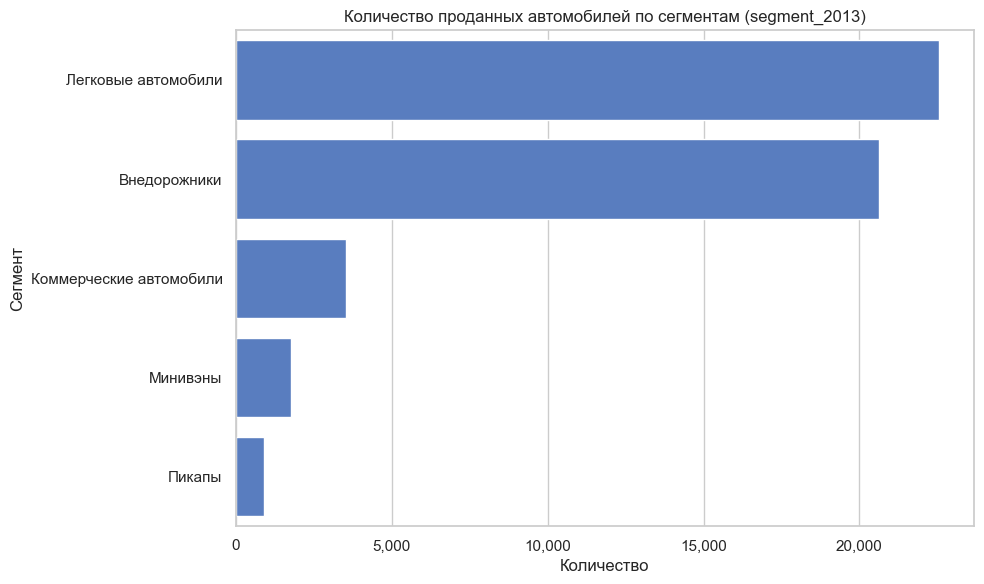

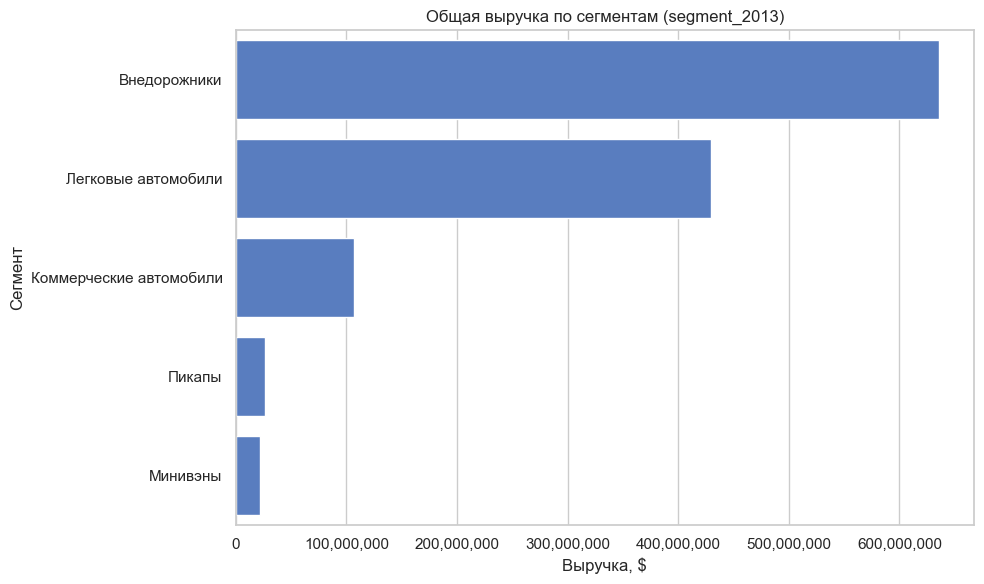

Пропущенных значений в segment_2013: 0


In [129]:
# Проверим уникальные значения сегмента
print("Уникальные значения segment_2013:")
print(data_query['segment_2013'].unique())

# Распределение по количеству продаж с учётом quantity
segment_quantity = data_query.groupby('segment_2013')['quantity'].sum().sort_values(ascending=False).reset_index()

# Распределение по общей выручке
segment_revenue = data_query.groupby('segment_2013')['total_usd'].sum().sort_values(ascending=False).reset_index()

# Список сегментов в нужном порядке
ordered_segments_quantity = segment_quantity['segment_2013']
ordered_segments_revenue = segment_revenue['segment_2013']

# График количества продаж по сегментам
plt.figure(figsize=(10, 6))
sns.barplot(
    data=segment_quantity,
    x='quantity',
    y='segment_2013',
    order=ordered_segments_quantity,
)
plt.title('Количество проданных автомобилей по сегментам (segment_2013)')
plt.xlabel('Количество')
plt.ylabel('Сегмент')
plt.tight_layout()
plt.gca().xaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}')); # Формат без экспоненты
plt.show()

# График выручки по сегментам
plt.figure(figsize=(10, 6))
sns.barplot(
    data=segment_revenue,
    x='total_usd',
    y='segment_2013',
    order=ordered_segments_revenue,
)
plt.title('Общая выручка по сегментам (segment_2013)')
plt.xlabel('Выручка, $')
plt.ylabel('Сегмент')
plt.tight_layout()
plt.gca().xaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}')); # Формат без экспоненты
plt.show()

# Проверим наличие пропущенных или нулевых значений
missing = data_query['segment_2013'].isna().sum()
print(f"Пропущенных значений в segment_2013: {missing}")


- Основная масса продаж: легковые автомобили и внедорожники, более 20 тысяч единиц.
- За счет цены внедорожники принесли в полтора раза больше денег: $640 млн. против $430 млн.
- Коммерческие авто занимают небольшое количество.

Рассмотрим связь segment_2013 с class_2013, чтобы понять, что за авто принадлежит к коммерческим.

In [130]:
# Кросс-таблица: сколько автомобилей в каждой паре (segment_2013 x class_2013), с учётом quantity
pd.pivot_table(
    data_query,
    index='class_2013',
    columns='segment_2013',
    values='quantity',
    aggfunc='sum',
    fill_value=0  # если нет значений — ставим 0
)


segment_2013               Внедорожники  Коммерческие автомобили  \
class_2013                                                         
A класс                               0                        0   
B класс                               0                        0   
C класс                               0                        0   
D класс                               0                        0   
E класс                               0                        0   
F класс                               0                        0   
Pick-ups                              0                        0   
Большие автобусы                      0                      358   
Компактвэн                            0                        0   
Компактные SUV                     6928                        0   
Крупнотоннажные грузовики             0                      504   
Малотоннажные грузовики               0                     1452   
Микроавтобусы                         0                      455   
Полноразмерные SUV                 2510                        0   
Полноразмерный Минивэн                0                        0   
Развозные автомобили                  0                      570   
Спортивные автомобили                 0                        0   
Среднеразмерные SUV                4349                        0   
Среднетоннажные грузовики             0                      142   
Средние автобусы                      0                       49   
Субкомпактные SUV                  6854                        0   

segment_2013               Легковые автомобили  Минивэны  Пикапы  
class_2013                                                        
A класс                                     69         0       0  
B класс                                  12632         0       0  
C класс                                   4018         0       0  
D класс                                   5509         0       0  
E класс                                    264         0       0  
F класс                                     44         0       0  
Pick-ups                                     0         0     894  
Большие автобусы                             0         0       0  
Компактвэн                                   0      1735       0  
Компактные SUV                               0         0       0  
Крупнотоннажные грузовики                    0         0       0  
Малотоннажные грузовики                      0         0       0  
Микроавтобусы                                0         0       0  
Полноразмерные SUV                           0         0       0  
Полноразмерный Минивэн                       0        45       0  
Развозные автомобили                         0         0       0  
Спортивные автомобили                       10         0       0  
Среднеразмерные SUV                          0         0       0  
Среднетоннажные грузовики                    0         0       0  
Средние автобусы                             0         0       0  
Субкомпактные SUV                            0         0       0

Коммерческими считаются только автобусы и грузовики.\
Внедорожники -- SUV (от английского sport utility vehicle) — «спортивно-утилитарный автомобиль».\
Пикапы - Pick-ups.\
Минивэны - в классе указано вэн (англ. фургон).\
Легковые - классы A-F и спортиные автомобили.

### Дата продажи

Понять динамику продаж по времени, выявить возможные тренды, сезонность, аномалии.

In [131]:
# посмотрим, за какой период у нас данные
data_query['sale_date'].describe()

count                            36773
mean     2019-06-13 06:27:33.495771392
min                2019-01-31 00:00:00
25%                2019-03-31 00:00:00
50%                2019-06-30 00:00:00
75%                2019-08-31 00:00:00
max                2019-09-30 00:00:00
Name: sale_date, dtype: object

Мы имеем продажи за январь-сентябрь 2019 года.

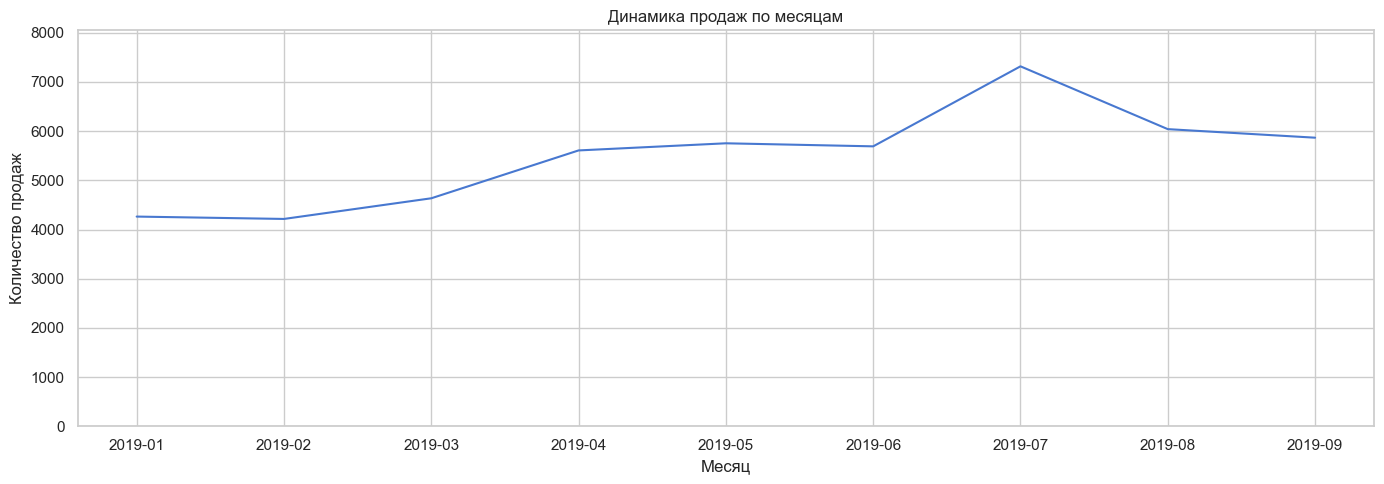

In [132]:
# Группировка по дате (до месяца)
data_query['sale_month'] = data_query['sale_date'].dt.to_period('M').astype(str)

monthly_sales = data_query.groupby('sale_month')['quantity'].sum().reset_index()

plt.figure(figsize=(14, 5))
sns.lineplot(data=monthly_sales, x='sale_month', y='quantity')
plt.title('Динамика продаж по месяцам')
plt.xlabel('Месяц')
plt.ylabel('Количество продаж')
# plt.xticks(rotation=0)
plt.tight_layout()
plt.ylim(0, monthly_sales['quantity'].max()*1.1)
plt.show()


Мы видим низкие продажи зимой, рост весной и резкий рост летом в июле.\
Посмотрим, с чем это может быть связано, как себя ведут продажи по брендам.

In [133]:
# Группируем продажи по месяцам и брендам
monthly_brand_sales = (
    data_query
    .assign(sale_month=lambda x: pd.to_datetime(x['sale_date']).dt.to_period('M').astype(str))
    .groupby(['sale_month', 'brand'])['quantity']
    .sum()
    .reset_index()
)

# Берём топ-10 брендов по объёму продаж
top_brands = (
    monthly_brand_sales
    .groupby('brand')['quantity']
    .sum()
    .nlargest(10)
    .index
)
monthly_brand_sales = monthly_brand_sales[monthly_brand_sales['brand'].isin(top_brands)]

# Построим интерактивный график
fig = px.line(
    monthly_brand_sales,
    x='sale_month',
    y='quantity',
    color='brand',
    markers=True,
    title='Динамика продаж по топ-брендам'
)

# Настраиваем внешний вид графика
fig.update_layout(
    xaxis_title='Месяц',
    yaxis_title='Количество проданных авто',
    legend_title='Бренд',
    legend=dict(
        orientation="h",
        yanchor="bottom",
        y=1.02,
        xanchor="right",
        x=1
    )
)

Среди брендов выделяется Jac. Остальные - без резких изменений.


In [134]:
# Группировка по месяцу и сегменту
monthly_segment_sales = (
    data_query
    .assign(sale_month=lambda x: pd.to_datetime(x['sale_date']).dt.to_period('M').astype(str))
    .groupby(['sale_month', 'segment_2013'])['quantity']
    .sum()
    .reset_index()
)

# Оставим только основные сегменты — топ-7 по объёму продаж
top_segments = (
    monthly_segment_sales
    .groupby('segment_2013')['quantity']
    .sum()
    .nlargest(7)
    .index
)
monthly_segment_sales = monthly_segment_sales[monthly_segment_sales['segment_2013'].isin(top_segments)]

# Интерактивный график
fig = px.line(
    monthly_segment_sales,
    x='sale_month',
    y='quantity',
    color='segment_2013',
    markers=True,
    title='Динамика продаж по сегментам (segment_2013)'
)

# Настраиваем внешний вид графика
fig.update_layout(
    xaxis_title='Месяц',
    yaxis_title='Количество проданных авто',
    legend_title='Сегмент',
    legend=dict(
        orientation="h",
        yanchor="bottom",
        y=1.02,
        xanchor="right",
        x=1
    )
)

fig.show()

По сегментам - у легковых и внедорожников был взлет, но связано ли это с аномалией, сказать нельзя.

In [135]:
# Создаем DataFrame с месячными продажами по компаниям
monthly_company_sales = (
    data_query
    .assign(sale_month=lambda x: pd.to_datetime(x['sale_date']).dt.to_period('M').astype(str))
    .groupby(['sale_month', 'company'])['quantity']
    .sum()
    .reset_index()
)

# Определяем топ-10 компаний по общему количеству продаж
top_companies = (
    monthly_company_sales
    .groupby('company')['quantity']
    .sum()
    .nlargest(10)
    .index
)

# Фильтруем данные, оставляя только топ-10 компаний
monthly_company_sales = monthly_company_sales[monthly_company_sales['company'].isin(top_companies)]

# Создаем линейный график
fig = px.line(
    monthly_company_sales,
    x='sale_month',
    y='quantity',
    color='company',
    markers=True,
    title='Динамика продаж по топ-компаниям'
)

# Настраиваем внешний вид графика
fig.update_layout(
    xaxis_title='Месяц',
    yaxis_title='Продажи (шт)',
    legend_title='Компания',
    legend=dict(
        orientation="h",
        yanchor="bottom",
        y=1.02,
        xanchor="right",
        x=1
    )
)
fig.show()


По трем графикам мы видим рост в июле у бренда Jac и компании Allur Auto.

In [136]:
jac_july = data_query[
    (data_query['brand'] == 'Jac') &
    (pd.to_datetime(data_query['sale_date']).dt.month == 7)
]

jac_july['model'].value_counts()


model
S3      641
S5      154
N120     14
N56       6
T6        5
Name: count, dtype: int64

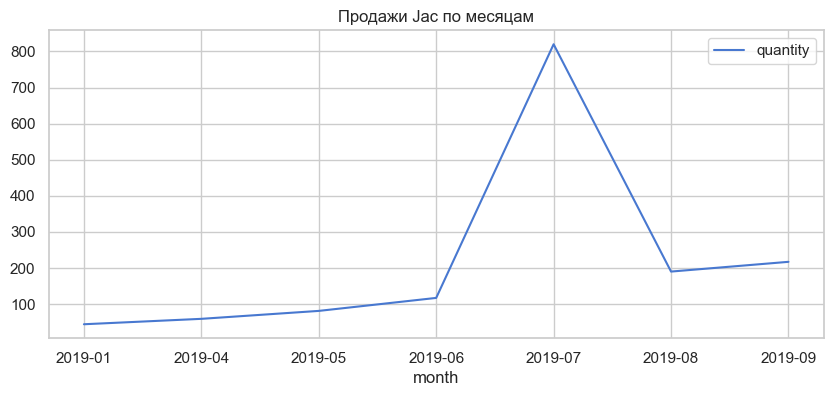

In [137]:
# посмотрим на ежемесячные продажи Jac
jac_monthly = (
    data_query[data_query['brand'] == 'Jac']
    .assign(month=pd.to_datetime(data_query['sale_date']).dt.to_period('M').astype(str))
    .groupby('month')['quantity'].sum()
    .reset_index()
)

jac_monthly.plot(x='month', y='quantity', figsize=(10, 4), title='Продажи Jac по месяцам')
plt.xticks(rotation=0);



Мы видим, что в июле был аномальный рост, который затем упал.

In [138]:
allur_sales = (
    data_query
    .loc[(data_query['company'] == 'Allur Auto') & (data_query['brand'] == 'Jac')]
    .groupby(['sale_date', 'brand', 'model'])['quantity']
    .sum()
    .reset_index()
)

# Фильтруем только строки, где quantity > 0
allur_sales = allur_sales[allur_sales['quantity'] > 0]

display(allur_sales)


sale_date brand model  quantity
0  2019-01-31   Jac    S3         9
1  2019-01-31   Jac    S5        35
2  2019-04-30   Jac    S3        22
3  2019-04-30   Jac    S5        17
4  2019-04-30   Jac    S7         1
5  2019-04-30   Jac    T6        19
6  2019-05-31   Jac    S3        58
7  2019-05-31   Jac    S5        21
8  2019-05-31   Jac    T6         2
9  2019-06-30   Jac    S3        54
10 2019-06-30   Jac    S5        63
11 2019-07-31   Jac  N120        14
12 2019-07-31   Jac   N56         6
13 2019-07-31   Jac    S3       641
14 2019-07-31   Jac    S5       154
15 2019-07-31   Jac    T6         5
16 2019-08-31   Jac  N120        38
17 2019-08-31   Jac   N56        10
18 2019-08-31   Jac    S3        93
19 2019-08-31   Jac    S5        42
20 2019-08-31   Jac    T6         7
21 2019-09-30   Jac  N120        36
22 2019-09-30   Jac   N56        32
23 2019-09-30   Jac    S3        82
24 2019-09-30   Jac    S5        45
25 2019-09-30   Jac    T6        22

In [139]:
# Фильтруем по компании и бренду
allur_jac = data_query.loc[
    (data_query['company'] == 'Allur Auto') &
    (data_query['brand'] == 'Jac')&
    (data_query['model'] == 'S3')
]

# Группируем по дате продажи (sale_date)
jac_monthly_stats = allur_jac.groupby('sale_date').apply(
    lambda x: pd.Series({
        'total_quantity': x['quantity'].sum(),
        'avg_price_usd_weighted': (x['price_usd'] * x['quantity']).sum() / x['quantity'].sum()
    })
).reset_index()

display(jac_monthly_stats)


sale_date  total_quantity  avg_price_usd_weighted
0 2019-01-31            9.00                14986.14
1 2019-04-30           22.00                13728.90
2 2019-05-31           58.00                13666.68
3 2019-06-30           54.00                14456.90
4 2019-07-31          641.00                12942.58
5 2019-08-31           93.00                13017.18
6 2019-09-30           82.00                12576.02

В июле снизилась цена на Jac S3. Это мог быть коммерческий ход или объективные обстоятельства. Например, в конце июня произошел очередной рестайлинг модели в Китае. [статья](<https://kolesa.kz/content/news/jac-s3-snova-obnovilsya/?ysclid=mcw78hy789871572799>). В связи с этим могли начать распродавать старую версию.\
В итоге продажи выросли.

### Сегмент

Анализируем долю каждого сегмента в общем объёме продаж и общей выручке.  
Это поможет понять, насколько важен каждый сегмент для рынка в количественном и денежном выражении.

In [140]:
# Группируем по сегменту и считаем продажи и выручку
segment_stats = data_query.groupby('segment').agg(
    total_quantity=('quantity', 'sum'),
    total_revenue=('total_usd', 'sum')
).reset_index()

# Добавляем доли
total_q = segment_stats['total_quantity'].sum()
total_r = segment_stats['total_revenue'].sum()

segment_stats['quantity_share'] = (segment_stats['total_quantity'] / total_q * 100).round(2).astype(str) + '%'
segment_stats['revenue_share'] = (segment_stats['total_revenue'] / total_r * 100).round(2).astype(str) + '%'

# Выводим результат
segment_stats


segment  total_quantity  total_revenue quantity_share revenue_share
0     b2b           16301   275907757.38          33.0%        22.61%
1     b2c           33090   944605013.76          67.0%        77.39%

Коммерческий транспорт занимает треть по количеству, но всего 22% в выручке.

Сравним средние цены автомобилей в сегментах (по одинаковым моделям)

Чтобы корректно сравнить цены между сегментами, возьмем только те модели, которые встречаются как в коммерческом, так и в некоммерческом сегментах.  
Средняя цена рассчитывается с учетом количества (взвешенная средняя).

In [141]:
# Находим модели, присутствующие в обоих сегментах
common_models = data_query.groupby('model')['segment'].nunique()
common_models = common_models[common_models == 2].index

# Считаем взвешенную среднюю цену по сегменту (только для общих моделей)
weighted_avg_price = (
    data_query[data_query['model'].isin(common_models)]
    .groupby('segment')
    .apply(lambda x: (x['price_usd'] * x['quantity']).sum() / x['quantity'].sum())
    .reset_index(name='weighted_avg_price')
)

# Показываем результат
display(weighted_avg_price)

# Считаем взвешенную среднюю цену по моделям и сегментам (только для общих моделей)
weighted_avg_price = (
    data_query[data_query['model'].isin(common_models)]  # Фильтруем данные, оставляя только строки с моделями из common_models
    .groupby(['model', 'segment'])  # Группируем по моделям и сегментам
    .apply(lambda x: (x['price_usd'] * x['quantity']).sum() / x['quantity'].sum())  # Вычисляем взвешенную среднюю цену
    .reset_index(name='weighted_avg_price')  # Преобразуем в DataFrame с колонкой weighted_avg_price
    .pivot(index='model', columns='segment', values='weighted_avg_price')  # Преобразуем в сводную таблицу: модели — строки, сегменты — столбцы
    .reset_index()  # Сбрасываем индекс, чтобы model стал столбцом
)

# Получаем названия столбцов сегментов (предполагается, что их два)
segment_columns = weighted_avg_price.columns[1:]  # Исключаем столбец 'model'

# Вычисляем процентную разницу между ценами в сегментах
# Формула: |price1 - price2| / min(price1, price2) * 100
weighted_avg_price['percent_diff'] = (
    (weighted_avg_price[segment_columns[1]] - weighted_avg_price[segment_columns[0]]) 
    / weighted_avg_price[segment_columns].min(axis=1) * 100
).round(2)  # Округляем до 2 знаков после запятой

# Функция для условного форматирования строк с разницей >= 20%
def highlight_diff(row):
    if (row['percent_diff'] >= 10) or (row['percent_diff'] <= -10):
        return ['background-color: #FFCCCB'] * len(row)  # Красный фон для всей строки
    return [''] * len(row)

# Определяем числовые столбцы (исключаем 'model', оставляем только float)
numeric_columns = weighted_avg_price.select_dtypes(include=['float64', 'int64']).columns

# Применяем форматирование: округляем числовые столбцы и подсвечиваем значимые отличия
styled_df = (
    weighted_avg_price
    .style
    .apply(highlight_diff, axis=1)
    .format({col: '{:.2f}' for col in numeric_columns})  # округление до 2 знаков
)

# Отображаем таблицу
styled_df


segment  weighted_avg_price
0     b2b            13261.42
1     b2c            22690.99

По таблице мы видим, что у BMW X6, Patriot и Nissan Almera есть значимые различия в средних ценах между сегментами. Рассмотрим их.

In [142]:
# Отбираем модели, у которых процентное отличие по цене >= 10%
highdiff = weighted_avg_price.loc[abs(weighted_avg_price['percent_diff']) >= 10, 'model'].unique()
display(highdiff)
# Отфильтровываем строки по этим моделям
for i in highdiff:
    display(data_query.loc[data_query['model'] == i].sort_values(by='price_usd', ascending=False))

array(['Almera', 'Patriot', 'X6'], dtype=object)

company   brand   model  release_year country_origin  \
20802  Nissan Manufacturing RUS  Nissan  Almera          2018            RUS   
20806  Nissan Manufacturing RUS  Nissan  Almera          2018            RUS   
20805  Nissan Manufacturing RUS  Nissan  Almera          2018            RUS   
20809  Nissan Manufacturing RUS  Nissan  Almera          2018            RUS   
20808  Nissan Manufacturing RUS  Nissan  Almera          2018            RUS   
20803  Nissan Manufacturing RUS  Nissan  Almera          2018            RUS   
20796  Nissan Manufacturing RUS  Nissan  Almera          2018            RUS   
20795  Nissan Manufacturing RUS  Nissan  Almera          2018            RUS   
20811  Nissan Manufacturing RUS  Nissan  Almera          2018            RUS   
20813  Nissan Manufacturing RUS  Nissan  Almera          2018            RUS   
20799  Nissan Manufacturing RUS  Nissan  Almera          2018            RUS   
20798  Nissan Manufacturing RUS  Nissan  Almera          2018            RUS   
20810  Nissan Manufacturing RUS  Nissan  Almera          2018            RUS   
20814  Nissan Manufacturing RUS  Nissan  Almera          2018            RUS   
20801  Nissan Manufacturing RUS  Nissan  Almera          2018            RUS   
20800  Nissan Manufacturing RUS  Nissan  Almera          2018            RUS   
20812  Nissan Manufacturing RUS  Nissan  Almera          2018            RUS   
20797  Nissan Manufacturing RUS  Nissan  Almera          2018            RUS   
20804  Nissan Manufacturing RUS  Nissan  Almera          2018            RUS   
20807  Nissan Manufacturing RUS  Nissan  Almera          2018            RUS   

      fuel_type  engine_capacity_l transmission drive_type     region  \
20802         F               1.60            A        2WD     Актобе   
20806         F               1.60            A        2WD     Атырау   
20805         F               1.60            A        2WD  Караганда   
20809         F               1.60            A        2WD  Караганда   
20808         F               1.60            A        2WD     Атырау   
20803         F               1.60            A        2WD     Алматы   
20796         F               1.60            A        2WD     Алматы   
20795         F               1.60            A        2WD    Уральск   
20811         F               1.60            A        2WD     Атырау   
20813         F               1.60            A        2WD     Атырау   
20799         F               1.60            A        2WD     Алматы   
20798         F               1.60            A        2WD     Атырау   
20810         F               1.60            A        2WD  Караганда   
20814         F               1.60            A        2WD  Караганда   
20801         F               1.60            A        2WD  Караганда   
20800         F               1.60            A        2WD     Алматы   
20812         F               1.60            M        2WD    Уральск   
20797         F               1.60            M        2WD  Караганда   
20804         F               1.60            A        2WD     Алматы   
20807         F               1.60            M        2WD     Алматы   

       quantity  price_usd  total_usd                       province  \
20802         1   73362.80   73362.80            Актюбинская область   
20806         2   73362.80  146725.59             Атырауская область   
20805         2   15589.59   31179.19         Карагандинская область   
20809         2   15589.59   31179.19         Карагандинская область   
20808         1   15589.59   15589.59             Атырауская область   
20803         1   15589.59   15589.59                         Алматы   
20796         1   14466.96   14466.96                         Алматы   
20795         1   14466.96   14466.96  Западно-казахстанская область   
20811         2   14253.83   28507.67             Атырауская область   
20813         1   14236.32   14236.32             Атырауская область   
20799         1  

company brand    model  release_year country_origin fuel_type  \
37565       Вираж   UAZ  Patriot          2018            RUS         F   
37654       Вираж   UAZ  Patriot          2018            RUS         F   
37653       Вираж   UAZ  Patriot          2018            RUS         F   
37652       Вираж   UAZ  Patriot          2019            RUS         F   
37690       Вираж   UAZ  Patriot          2018            RUS         F   
...           ...   ...      ...           ...            ...       ...   
37641  БИПЭК АВТО   UAZ  Patriot          2018            KAZ         F   
37640  БИПЭК АВТО   UAZ  Patriot          2018            KAZ         F   
37639  БИПЭК АВТО   UAZ  Patriot          2018            KAZ         F   
37638  БИПЭК АВТО   UAZ  Patriot          2018            KAZ         F   
37781  БИПЭК АВТО   UAZ  Patriot          2019            KAZ         F   

       engine_capacity_l transmission drive_type            region  quantity  \
37565               2.70            M        4WD         Караганда         1   
37654               2.70            M        4WD  Усть-каменогорск         1   
37653               2.70            M        4WD  Усть-каменогорск         1   
37652               2.70            M        4WD            Алматы         1   
37690               2.70            M        4WD            Алматы         1   
...                  ...          ...        ...               ...       ...   
37641               2.69            M        4WD            Алматы         1   
37640               2.69            M        4WD            Атырау         1   
37639               2.69            M        4WD         Кызылорда         1   
37638               2.69            M        4WD          Павлодар         1   
37781               2.69            M        4WD  Усть-каменогорск         1   

       price_usd  total_usd                        province  segment_2013  \
37565   21543.77   21543.77          Карагандинская область  Внедорожники   
37654   21260.80   21260.80  Восточно-казахстанская область  Внедорожники   
37653   21260.80   21260.80  Восточно-казахстанская область  Внедорожники   
37652   21260.80   21260.80                          Алматы  Внедорожники   
37690   21162.99   21162.99                          Алматы  Внедорожники   
...          ...        ...                             ...           ...   
37641   13800.00   13800.00                          Алматы  Внедорожники   
37640   13800.00   13800.00              Атырауская область  Внедорожники   
37639   13800.00   13800.00          Кызылординская область  Внедорожники   
37638   13800.00   13800.00            Павлодарская область  Внедорожники   
37781   13800.00   13800.00  Восточно-казахстанская область  Внедорожники   

                class_2013  sale_date segment sale_month  
37565  Среднеразмерные SUV 2019-03-31     b2c    2019-03  
37654  Среднеразмерные SUV 2019-06-30     b2c    2019-06  
37653  Среднеразмерные SUV 2019-06-30     b2c    2019-06  
37652  Среднеразмерные SUV 2019-06-30     b2c    2019-06  
37690  Среднеразмерные SUV 2019-07-31     b2c    2019-07  
...                    ...        ...     ...        ...  
37641  Среднеразмерные SUV 2019-06-30     b2c    2019-06  
37640  Среднеразмерные SUV 2019-06-30     b2c    2019-06  
37639  Среднеразмерные SUV 2019-06-30     b2c    2019-06  
37638  Среднеразмерные SUV 2019-06-30     b2c    2019-06  
37781  Среднеразмерные SUV 2019-09-30     b2c    2019-09  

[254 rows x 19 columns]

company brand model  release_year country_origin fuel_type  \
190  Автоцентр-Бавария   BMW    X6          2018            USA         F   
194  Автоцентр-Бавария   BMW    X6          2019            USA         F   
182  Автоцентр-Бавария   BMW    X6          2018            USA         F   
183  Автоцентр-Бавария   BMW    X6          2018            USA         F   
184  Автоцентр-Бавария   BMW    X6          2018            USA         F   
181  Автоцентр-Бавария   BMW    X6          2018            USA         F   
179  Автоцентр-Бавария   BMW    X6          2018            USA         F   
180  Автоцентр-Бавария   BMW    X6          2018            USA         F   
189  Автоцентр-Бавария   BMW    X6          2019            USA         F   
188  Автоцентр-Бавария   BMW    X6          2019            USA         F   
187  Автоцентр-Бавария   BMW    X6          2019            USA         F   
186  Автоцентр-Бавария   BMW    X6          2019            USA         F   
185  Автоцентр-Бавария   BMW    X6          2019            USA         F   
191  Автоцентр-Бавария   BMW    X6          2018            USA         F   
192  Автоцентр-Бавария   BMW    X6          2018            USA         F   
193  Автоцентр-Бавария   BMW    X6          2019            USA         F   
195  Автоцентр-Бавария   BMW    X6          2019            USA         F   
196  Автоцентр-Бавария   BMW    X6          2018            USA         F   

     engine_capacity_l transmission drive_type            region  quantity  \
190               4.40            A        4WD        Нур-султан         1   
194               4.40            A        4WD            Алматы         1   
182               3.00            A        4WD  Усть-каменогорск         1   
183               3.00            A        4WD        Нур-султан         4   
184               3.00            A        4WD            Алматы         2   
181               3.00            A        4WD        Нур-султан         1   
179               3.00            A        4WD        Нур-султан         1   
180               3.00            A        4WD            Алматы         3   
189               3.00            A        4WD            Алматы         2   
188               3.00            A        4WD        Нур-султан         4   
187               3.00            A        4WD  Усть-каменогорск         1   
186               3.00            A        4WD           Уральск         1   
185               3.00            A        4WD          Костанай         1   
191               3.00            A        4WD        Нур-султан         4   
192               3.00            A        4WD            Алматы         3   
193               3.00            A        4WD        Нур-султан         1   
195               3.00            A        4WD            Алматы         1   
196               3.00            A        4WD          Костанай         1   

     price_usd  total_usd                        province  segment_2013  \
190  121069.26  121069.26                      Нур-султан  Внедорожники   
194  120434.22  120434.22                          Алматы  Внедорожники   
182   68392.57   68392.57  Восточно-казахстанская область  Внедорожники   
183   68392.57  273570.29                      Нур-султан  Внедорожники   
184   68392.57  136785.15                          Алматы  Внедорожники   
181   68235.62   68235.62                      Нур-султан  Внедорожники   
179   68143.25   68143.25                      Нур-султан  Внедорожники   
180   68143.25  204429.76                          Алматы  Внедорожники   
189   67933.62  135867.23                          Алматы  Внедорожники   
188   67933.62  271734.46                      Нур-султан  Внедорожники   
187   67933.62   67933.62  Восточно-казахстанская область  Внедорожники   
186   67933.62   67933.62   Западно-казахстанская область  Внедорожники   
185   67933.62   67933.62            Костанайская область  Внедорожники   
191   67753.32  27

Мы видим, что у BMW X6 и Nissan Almera очень высокие цены, значительно отличающиеся от обычных.\
Найдем такие выбросы.

In [143]:
# Список для хранения индексов аномалий
anomaly_indices = []

# Проходим по каждой модели из списка highdiff
for model in highdiff:
    # Отбираем все строки по модели
    model_data = data_query.loc[data_query['model'] == model]
    
    # Если меньше 3 строк — пропустим (мало данных для анализа)
    if model_data.shape[0] < 3:
        continue

    # Считаем медиану по цене
    median_price = model_data['price_usd'].median()

    # Определяем порог аномалии (на 50% выше медианы)
    upper_threshold = median_price * 1.5

    # Находим строки, которые превышают порог
    anomalies = model_data.loc[model_data['price_usd'] > upper_threshold]
    
    # Сохраняем индексы аномалий
    anomaly_indices.extend(anomalies.index.tolist())
    
    # Можно напечатать, если нужно проверить вручную
    if not anomalies.empty:
        print(f"Аномалии найдены в модели {model}:")
        display(anomalies[['model', 'price_usd', 'quantity']].sort_values(by='price_usd', ascending=False))


Аномалии найдены в модели Almera:


model  price_usd  quantity
20802  Almera   73362.80         1
20806  Almera   73362.80         2

Аномалии найдены в модели X6:


model  price_usd  quantity
190    X6  121069.26         1
194    X6  120434.22         1

Избавимся от этих выбросов.


In [144]:
# Удаляем строки с аномально высокими ценами
data_query = data_query.drop(index=anomaly_indices).reset_index(drop=True)

print(f"Удалено строк с аномалиями: {len(anomaly_indices)}")

Удалено строк с аномалиями: 4


Ещё раз сравним средние цены по сегментам. Отберем только те, которые продавали хотя бы по 10 раз.

In [145]:
# Минимальное количество строк (записей) в каждом сегменте для модели
min_rows_per_segment = 10  # Можем менять это значение

# Шаг 1: оставляем модели, встречающиеся в обоих сегментах
model_segment_counts = data_query.groupby(['model', 'segment']).size().unstack(fill_value=0)

# Шаг 2: фильтруем — должны быть хотя бы min_rows_per_segment в каждом сегменте
eligible_models = model_segment_counts[
    (model_segment_counts >= min_rows_per_segment).all(axis=1)
].index

# Шаг 3: считаем взвешенную среднюю цену по сегментам только по этим моделям
weighted_avg_price = (
    data_query[data_query['model'].isin(eligible_models)]
    .groupby('segment')
    .apply(lambda x: (x['price_usd'] * x['quantity']).sum() / x['quantity'].sum())
    .reset_index(name='weighted_avg_price')
)

# Показываем результат
weighted_avg_price


segment  weighted_avg_price
0     b2b            12640.86
1     b2c            20115.95

Мы видим, что цены в продажах бизнесу существенно ниже по одинаковым моделям.

### Выводы:

Рынок автомобилей Казахстана в 2019 году характеризуется высокой концентрацией продаж у нескольких крупных дилеров, где лидируют Toyota Motor Kazakhstan, Astana Motors и БИПЭК АВТО. При этом среди крупных игроков наблюдаются как компании с высоким объёмом продаж, так и такие, как Autokapital, с относительно низким количеством автомобилей, но высокой выручкой.

Основные бренды по количеству — Lada, Toyota и Hyundai, при этом топ-3 бренда имеют свыше 10 тысяч проданных авто. Значительный разброс цен наблюдается у популярных моделей Toyota Camry и Land Cruiser Prado, что, вероятно, связано с модификациями и премиальными версиями. Бюджетные автомобили преимущественно производятся в Казахстане и России, составляя около 80% рынка, а японские авто — около 10%, при этом последние дороже в 2–3 раза.

Автомобили с автоматической трансмиссией наиболее востребованы и имеют более высокие средние цены, чем с механической, что отражается и на выручке. Также выявлена сильная положительная корреляция цены с объёмом двигателя и типом привода — полный привод значительно увеличивает цену авто.

Коммерческие автомобили составляют небольшую долю рынка по количеству и выручке, при этом цена на автомобили, продаваемые бизнесу, заметно ниже, чем в сегменте B2C по тем же моделям.

В динамике продаж выделяется аномальный рост в июле, связанный с распродажей модели Jac S3 после снижения цены, что говорит о влиянии маркетинговых акций и обновлений моделей на спрос.

Наконец, несмотря на аномалии и редкие очень дорогие продажи премиальных моделей и автобусов, основная масса рынка — легковые автомобили и внедорожники, с преобладанием местного производства и устойчивыми тенденциями в предпочтениях покупателей по трансмиссии, объёму двигателя и типу привода.

## Анализ рынка

В этом разделе мы рассмотрим общую картину продаж на автомобильном рынке по данным за 2019 год. Исследуем основные тренды, популярные сегменты, бренды и модели, а также проанализируем динамику продаж.

### Общие тренды

In [146]:
# Подсчёт общего количества проданных авто и выручки
total_qty = data_query['quantity'].sum()
total_rev = data_query['total_usd'].sum()
print(f"Общее количество продаж: {data_query['quantity'].count()}")
print(f"Общее количество проданных авто: {int(total_qty):,}")
print(f"Общая выручка: ${total_rev:,.0f}")

Общее количество продаж: 36769
Общее количество проданных авто: 49,386
Общая выручка: $1,220,051,179


Мы видим, что емкость рынка составляет 1 млрд. 200 млн. долларов за неполный год.

In [147]:
# 1. Определяем топ-10 компаний по выручке
top_companies_revenue = (
    data_query.groupby('company', as_index=False)['total_usd']
    .sum()
    .sort_values(by='total_usd', ascending=False)
)

top_10_companies = top_companies_revenue.head(10)['company'].tolist()

# 2. Фильтруем данные по этим компаниям
top_data = data_query[data_query['company'].isin(top_10_companies)]

# 3. Группируем по компании и бренду, считаем выручку
grouped = (
    top_data.groupby(['company', 'brand'], as_index=False)['total_usd']
    .sum()
)

# 4. Устанавливаем порядок отображения по убыванию общей выручки
company_order = (
    top_companies_revenue[top_companies_revenue['company'].isin(top_10_companies)]
    ['company']
    .tolist()
)

# 5. Строим накопительный столбчатый график
fig = px.bar(
    grouped,
    x='company',
    y='total_usd',
    color='brand',
    title='Выручка по брендам у крупнейших компаний',
    labels={'total_usd': 'Выручка ($)', 'company': 'Компания'},
    category_orders={'company': company_order},
    text_auto='.2s',  # краткий формат чисел (например, 1.5M)
    height=800,
)

fig.update_layout(
    barmode='stack',
    xaxis_tickangle=45,
    yaxis_title='Выручка ($)',
    legend_title='Бренд'
)

fig.show()

По графику мы видим, что крупнейшие компании имеют специализацию по брендам.\
Toyota Motor Kazakhstan имеет самую высокую выручку, продавая Toyota и Lexus.\
Astana Motors специализируется на Hyunday, БИПЭК АВТО - Lada, Kia, Scoda.

Крупнейший игрок на рынке за 9 месяцев совершил продаж на $477 миллионов. Посмотрим, где производятся автомобили.

In [148]:
# сгруппируем Тойоты по странам производства
data_query.loc[
    data_query['brand'] == 'Toyota'
].groupby(['country_origin'])['quantity'].sum().reset_index().sort_values(by='quantity', ascending=False)

country_origin  quantity
1            RUS      6066
0            JPN      2687
3            TUR      1163
2            THA       825

Судя по таблице, все проданные Toyota произведены за пределами республики. В основном везут из России и Японии. Часть - Турция и Таиланд.

In [149]:
data_query.loc[
    data_query['brand'] == 'Toyota'
].groupby(['country_origin', 'model'])['quantity'].sum().reset_index().sort_values(by='quantity', ascending=False)

country_origin       model  quantity
3            RUS       Camry      4853
1            JPN    LC Prado      1711
4            RUS        RAV4      1213
7            TUR     Corolla      1087
5            THA    HILUX DC       825
2            JPN       LC200       779
0            JPN  HIGHLANDER       197
6            TUR        C-HR        76

Мы видим, что модели не повторяются. Camry, RAV4 производят и привозят из РФ, Land Cruiser - из Японии.\
В Турции собирают Corolla.

### Сегменты

Рассмотрим, какую долю занимают продажи бизнесу, а какую - частным покупателям.

In [150]:
# Суммарные продажи и выручка по сегментам
segment_summary = (
    data_query.groupby('segment')
    .agg(
        quantity=('quantity', 'sum'),
        revenue=('total_usd', 'sum')
    )
    .reset_index()
)

# Добавим доли
segment_summary['qty_share'] = (segment_summary['quantity'] / segment_summary['quantity'].sum() * 100).round(2)
segment_summary['rev_share'] = (segment_summary['revenue'] / segment_summary['revenue'].sum() * 100).round(2)
segment_summary

segment  quantity      revenue  qty_share  rev_share
0     b2b     16301 275907757.38      33.01      22.61
1     b2c     33085 944143421.89      66.99      77.39

Продажи частным лицам занимают 77% рынка.\
b2b меньше в 3.5 раза.

In [151]:
# Копируем датафрейм, чтобы не менять исходный
df = data_query.copy()

# Создаём новый сегмент с уточнением для B2B
df['segment_split'] = df.apply(
    lambda row: 'b2b_com' if row['segment'] == 'b2b' and row['segment_2013'] == 'Коммерческие автомобили'
    else 'b2b_cust' if row['segment'] == 'b2b'
    else row['segment'],
    axis=1
)

# Считаем количество проданных авто по сегменту и бренду
segment_brand = (
    df.groupby(['segment_split', 'brand'], as_index=False)
    .agg(quantity=('quantity', 'sum'))
)

# Сортируем и берём топ-5 брендов в каждом сегменте
top_segment_brand = (
    segment_brand.sort_values(['segment_split', 'quantity'], ascending=[True, False])
    .groupby('segment_split')
    .head(5)
)

# Добавляем колонку с текстом "бренд / количество"
top_segment_brand['label'] = top_segment_brand['brand'] + ' / ' + top_segment_brand['quantity'].astype(int).astype(str)

# Нумеруем позиции внутри каждого сегмента
top_segment_brand['rank'] = top_segment_brand.groupby('segment_split').cumcount()

# Преобразуем в широкую таблицу
pivot_table = top_segment_brand.pivot(index='rank', columns='segment_split', values='label').reset_index(drop=True)

pivot_table.style.hide(axis='index')

В b2b по количеству проданных автомобилей лидируют GAZ, UAZ, KAMAZ в сфере коммерческого транспорта и Lada, Kia среди некоммерческих.\
Среди b2c: Toyota, Hyundai.

### Популярные марки и модели

Посмотрим, какие автомобили наиболее популярны в Казахстане.

In [152]:
# Топ моделей
data_query.groupby(['brand', 'model'])['quantity'].sum().sort_values(ascending=False).head(10).reset_index()


brand     model  quantity
0   Toyota     Camry      4853
1     Lada    Granta      3664
2  Hyundai    Tucson      3271
3     Lada     Vesta      2653
4     Lada       4x4      2469
5  Hyundai    Accent      2211
6  Hyundai   Elantra      2062
7  Hyundai     Creta      1775
8   Toyota  LC Prado      1711
9     Lada    Largus      1683

Самым популярным автомобилем в Казахстане является Toyota Camry. Её покупают на 30% больше, чем Lada Granta.\
В топе после Camry находятся различные модели Lada и Hyundai.\
9-й по популярности - Land Cruiser Prado.

Однако на эти значения сильно влияют оптовые продажи Бипэк Авто. Оставим только b2c сегмент.

In [153]:
# Топ моделей
data_query[data_query['segment'] == 'b2c'].groupby(['brand', 'model'])['quantity'].sum().sort_values(ascending=False).head(20).reset_index()

brand     model  quantity
0       Toyota     Camry      4853
1      Hyundai    Tucson      3271
2      Hyundai    Accent      2211
3      Hyundai   Elantra      2062
4      Hyundai     Creta      1775
5       Toyota  LC Prado      1711
6        Ravon  Nexia R3      1396
7       Toyota      RAV4      1213
8       Toyota   Corolla      1087
9          Jac        S3       959
10      Toyota  HILUX DC       825
11      Toyota     LC200       779
12     Hyundai  Santa Fe       639
13   Chevrolet      Niva       567
14     Renault    Duster       561
15  Volkswagen      Polo       516
16        Lada     Vesta       464
17       Lexus        RX       442
18      Nissan   Qashqai       420
19        Lada      XRAY       384

Теперь в Топ-10 отсутствует Lada. Только на 17-м месте Lada Vesta.\
Обычные люди предпочитают Toyota, Hyundai, Ravon, Jac.\
На 14-м месте Chevrolet Niva, с продажами на порядок ниже, чем у Camry.

Делаем вывод, что Lada в основном продается оптом для перепродажи.

### Динамика продаж

Посмотрим на динамику продаж по очищенным данным.

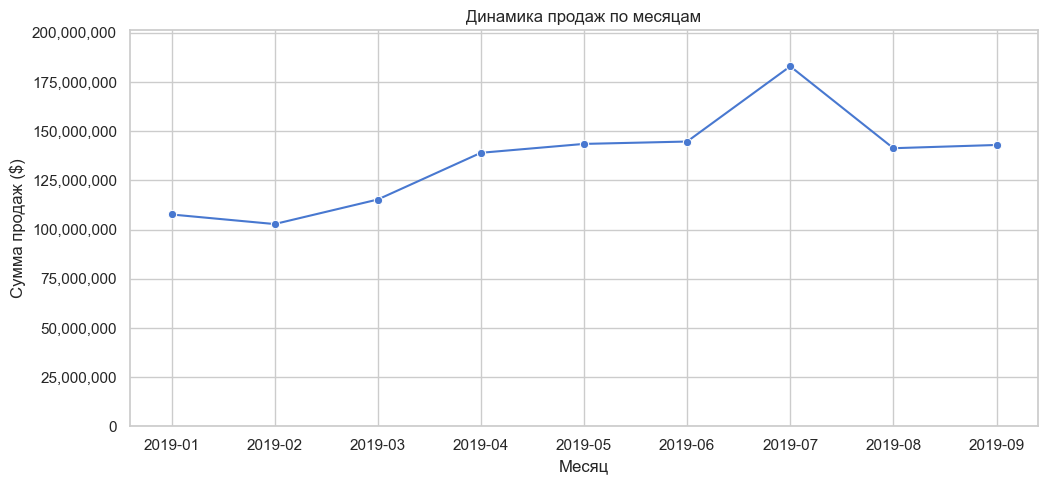

In [154]:
# Группируем продажи по месяцам
monthly_sales = data_query.groupby('sale_month')['total_usd'].sum().reset_index()

# Строим график
plt.figure(figsize=(10, 5))
sns.lineplot(data=monthly_sales, x='sale_month', y='total_usd', marker='o')
plt.title('Динамика продаж по месяцам')
plt.xlabel('Месяц')
plt.ylabel('Сумма продаж ($)')
plt.tight_layout()
plt.ylim(0, monthly_sales['total_usd'].max()*1.1)
plt.gca().yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}')); # Формат без экспоненты
plt.show()


Мы видим аномальный рост в июле. Это произошло из-за резкого увеличения продаж Jac S3 в июле, мы рассмотрели это ранее в разделе "Исследовательский анализ данных. Дата продажи". На них снизилась цена, продажи выросли.

### Краткие выводы о рынке автомобилей Казахстана

- **Общий объём продаж** за 9 месяцев составил **49,386 автомобилей** на сумму **$1,22 млрд**, что указывает на высокую ёмкость и активность рынка.
- **Около 60%** автомобилей произведены в **Казахстане**, **20%** — в **России**, **10%** — в **Японии**, и ещё **5%** — в остальных странах (Турция, Таиланд и др.).
- **Автоматическая трансмиссия** — самый распространённый тип. Она преобладает по количеству продаж и имеет **более высокую среднюю цену**, чем механическая.
- Основной вклад в рынок дают **легковые автомобили и внедорожники** — более **20 тыс. единиц**. Однако благодаря более высокой цене **внедорожники принесли $640 млн** против **$430 млн** у легковых.
- **Коммерческий транспорт** занимает **небольшую долю** и по количеству, и по выручке.
- **Toyota Motor Kazakhstan** — лидер по выручке, специализируется на **Toyota** и **Lexus**. Также выделяются **Astana Motors (Hyundai)** и **БИПЭК АВТО (Lada, Kia, Skoda)**.
- **Локальный рынок сильно сегментирован по брендам**: у каждого крупного автоцентра есть собственная специализация.
- В июле зафиксирован **аномальный рост продаж**, вызванный **резким снижением цены на Jac S3**, что привело к всплеску спроса.


## Эффективность компании «Mercur Auto»

В этом разделе мы исследуем работу компании «Меркур Авто», определим её долю на рынке, сравним с другими автоцентрами и изучим её доходы и продажи по месяцам.

### Общая информация

Рассмотрим совокупные продажи компании Mercur Auto за период наблюдений. Проанализируем:
- общий объём продаж и выручку;
- распределение по сегментам (b2b/коммерческий и b2c/некоммерческий);
- бренды, с которыми работает компания, и их вклад;
- самые продаваемые модели.

In [155]:
# Фильтруем данные по компании
merc_data = data_query.query("company == 'Mercur Auto'").copy()

# Сводные метрики
total_sales = merc_data['quantity'].sum()
total_revenue = merc_data['total_usd'].sum()
avg_price = total_revenue / total_sales

print(f"Общее количество проданных автомобилей: {int(total_sales):,}")
print(f"Общая выручка: ${total_revenue:,.0f}")
print(f"Средняя цена продажи: ${avg_price:,.0f}")

# Распределение по сегментам и брендам
brand_segment_pivot = (
    merc_data
    .groupby(['brand', 'segment'], as_index=False)
    .agg(quantity=('quantity', 'sum'))
    .pivot(index='brand', columns='segment', values='quantity')
    .fillna(0)
    .astype(int)
)

# Добавим итоговую строку
brand_segment_pivot.loc['Итого'] = brand_segment_pivot.sum()

print("\nРаспределение продаж Mercur Auto по брендам и сегментам")
# Форматирование вывода
display(
    brand_segment_pivot
    .style.format('{:,.0f}')
)

print('\nТоп-10 моделей по продажам')
# Топ-10 моделей по продажам
(
    merc_data
    .groupby(['brand', 'model'], as_index=False)
    .agg(quantity=('quantity', 'sum'), revenue=('total_usd', 'sum'))
    .sort_values(by='quantity', ascending=False)
    .head(10).reset_index(drop=True)
    .style.format({'revenue': '${:,.0f}'})
)

Общее количество проданных автомобилей: 603
Общая выручка: $17,674,742
Средняя цена продажи: $29,311

Распределение продаж Mercur Auto по брендам и сегментам



Топ-10 моделей по продажам


- Общее количество проданных автомобилей: **603**
- Общая выручка: **$17,674,742**
- Средняя цена продажи: **$29,311**
- Основной объём продаж пришёлся на **некоммерческий сегмент (b2c)** — 595 автомобилей против 8 в коммерческом (b2b)
- В продаже только 3 бренда: **Volkswagen**, **Audi**, **Porsche**
- Самая продаваемая модель — **Volkswagen Polo**: 439 штук на сумму $6.4 млн
- Среди премиальных моделей выделяются: **Porsche Cayenne** ($2.9 млн при 28 продажах) и **Audi Q8** ($1.8 млн при 20 продажах)
- **Продажи в сегменте b2b крайне ограничены** — только Volkswagen, всего 8 штук

### Сравнение с другими автоцентрами


Рассчитаем ключевые показатели по компаниям: общее количество проданных автомобилей и полученная выручка.  
Это поможет определить основных игроков на рынке и оценить долю "Mercur Auto" среди лидеров.

Ниже — топ-10 компаний по выручке.

In [156]:
# Группировка по компаниям
company_summary = (
    data_query
    .groupby('company')
    .agg(
        quantity=('quantity', 'sum'),
        revenue=('total_usd', 'sum')
    )
    .sort_values(by='revenue', ascending=False)
    .reset_index()
)
company_summary['avg_price'] = company_summary['revenue']/company_summary['quantity']
company_summary['rate'] = company_summary['revenue']/company_summary['revenue'].sum()*100

# Функция форматирования
def highlight_merc(row):
    if row['company'] == 'Mercur Auto':
        return ['background-color: green'] * len(row)  # Светло-зелёный фон
    return [''] * len(row)

# Отображаем таблицу с форматированием
styled = company_summary.head(10).style.apply(highlight_merc, axis=1).format({
    'quantity': '{:,.0f}',
    'revenue': '{:,.0f}',
    'avg_price': '{:,.0f}',
    'rate': '{:.2f}%'
})
display(styled)


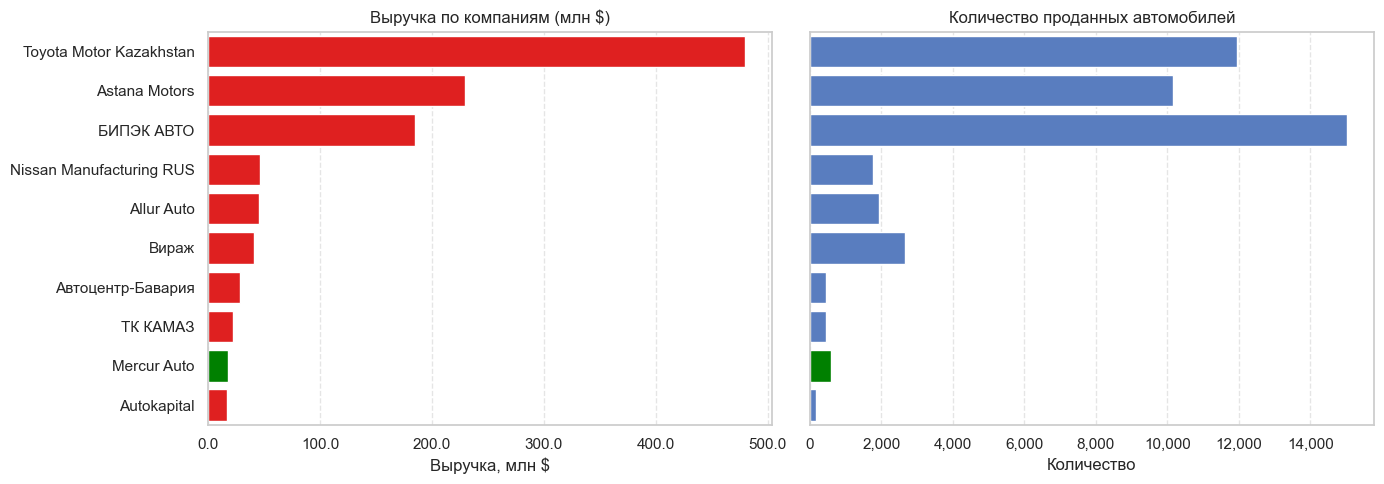

In [157]:
# Берем топ-10
top_companies = company_summary.head(10).copy()

# Масштабируем значения в тыс. $
top_companies['revenue_mln'] = top_companies['revenue'] / 1_000_000

# Построим два графика: выручка и количество
fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=True)

# Выручка
sns.barplot(
    data=top_companies,
    y='company', x='revenue_mln',
    ax=axes[0], color='red'
)
axes[0].set_title('Выручка по компаниям (млн $)')
axes[0].set_xlabel('Выручка, млн $')
axes[0].xaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.1f}'))

# Перекрасим Mercur Auto в зелёный
for bar, company in zip(axes[0].containers[0], top_companies['company']):
    if company == 'Mercur Auto':
        bar.set_facecolor('green')

# Количество
sns.barplot(
    data=top_companies,
    y='company', x='quantity',
    ax=axes[1]
)
axes[1].set_title('Количество проданных автомобилей')
axes[1].set_xlabel('Количество')
axes[1].xaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))

# Перекрасим Mercur Auto в зелёный
for bar, company in zip(axes[1].containers[0], top_companies['company']):
    if company == 'Mercur Auto':
        bar.set_facecolor('green')

# Общий стиль
for ax in axes:
    ax.set_ylabel('')
    ax.grid(axis='x', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

Мы видим, что Mercur Auto занимает примерно 1.5% рынка. Сравнивая с ближайшими конкурентами, мы видим, что они имеют сравнимую выручку при более низком количестве проданных авто.

Если смотреть по компаниям со сравнимыми ценами, то конкурентами являются:
- Astana Motors;
- Nissan Manufacturing RUS;
- Allur Auto.

### Динамика продаж "Mercur Auto"

Рассмотрим динамику продаж компании по месяцам.

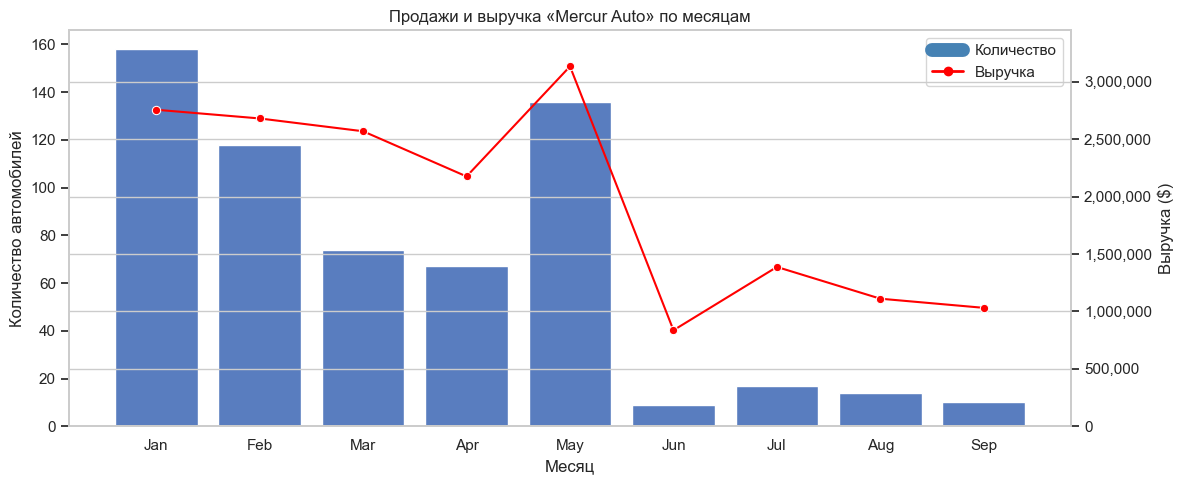

In [158]:
# Фильтруем данные по компании Mercur Auto
merc_data = data_query.query("company == 'Mercur Auto'").copy()

# Преобразуем sale_date в datetime (если еще не было)
merc_data['sale_date'] = pd.to_datetime(merc_data['sale_date'])

# Группировка по месяцам
merc_monthly = (
    merc_data
    .groupby('sale_date')
    .agg(
        quantity=('quantity', 'sum'),
        revenue=('total_usd', 'sum')
    )
    .reset_index()
)

# Преобразуем и сортируем даты
merc_monthly['sale_date'] = pd.to_datetime(merc_monthly['sale_date'])
merc_monthly = merc_monthly.sort_values('sale_date')

# Для отображения месяцев текстом
merc_monthly['month_str'] = merc_monthly['sale_date'].dt.strftime('%b')
merc_monthly['revenue'] = merc_monthly['revenue'].astype('float64')

# Строим график
fig, ax1 = plt.subplots(figsize=(12, 5))

# Столбчатый график: количество продаж
sns.barplot(data=merc_monthly, x='month_str', y='quantity', ax=ax1, label='Продажи', legend=False)
ax1.set_ylabel('Количество автомобилей')
ax1.set_xlabel('Месяц')
ax1.set_title('Продажи и выручка «Mercur Auto» по месяцам')
ax1.grid(False)

# Вторая ось: выручка
ax2 = ax1.twinx()
sns.lineplot(data=merc_monthly, x='month_str', y='revenue', ax=ax2, color='red', label='Выручка', marker='o', legend=False)
ax2.set_ylabel('Выручка ($)')
ax2.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))  # Без экспоненты
ax2.set_ylim(0, merc_monthly['revenue'].max()*1.1)

# Легенда
lines1 = [plt.Line2D([0], [0], color='steelblue', lw=10)]
lines2 = [plt.Line2D([0], [0], color='red', marker='o', lw=2)]
labels = ['Количество', 'Выручка']
ax1.legend(lines1 + lines2, labels, loc='upper right')

plt.tight_layout()
plt.show()


Мы видим, что в мае были самые высокие в денежном выражении продажи, затем с лета последовал резкий спад почти в 3 раза - с $3 млн до $1 млн.

Рассмотрим бренды, с которыми работает компания Mercur Auto. Далее сравним продажи по месяцам с другими компаниями, чтобы выявить общерыночные тренды.

На графиках видно поведение каждого бренда у конкурентов: рост, спад или стабильность. Это позволяет понять, связано ли изменение продаж Mercur Auto с рынком или внутренними факторами.

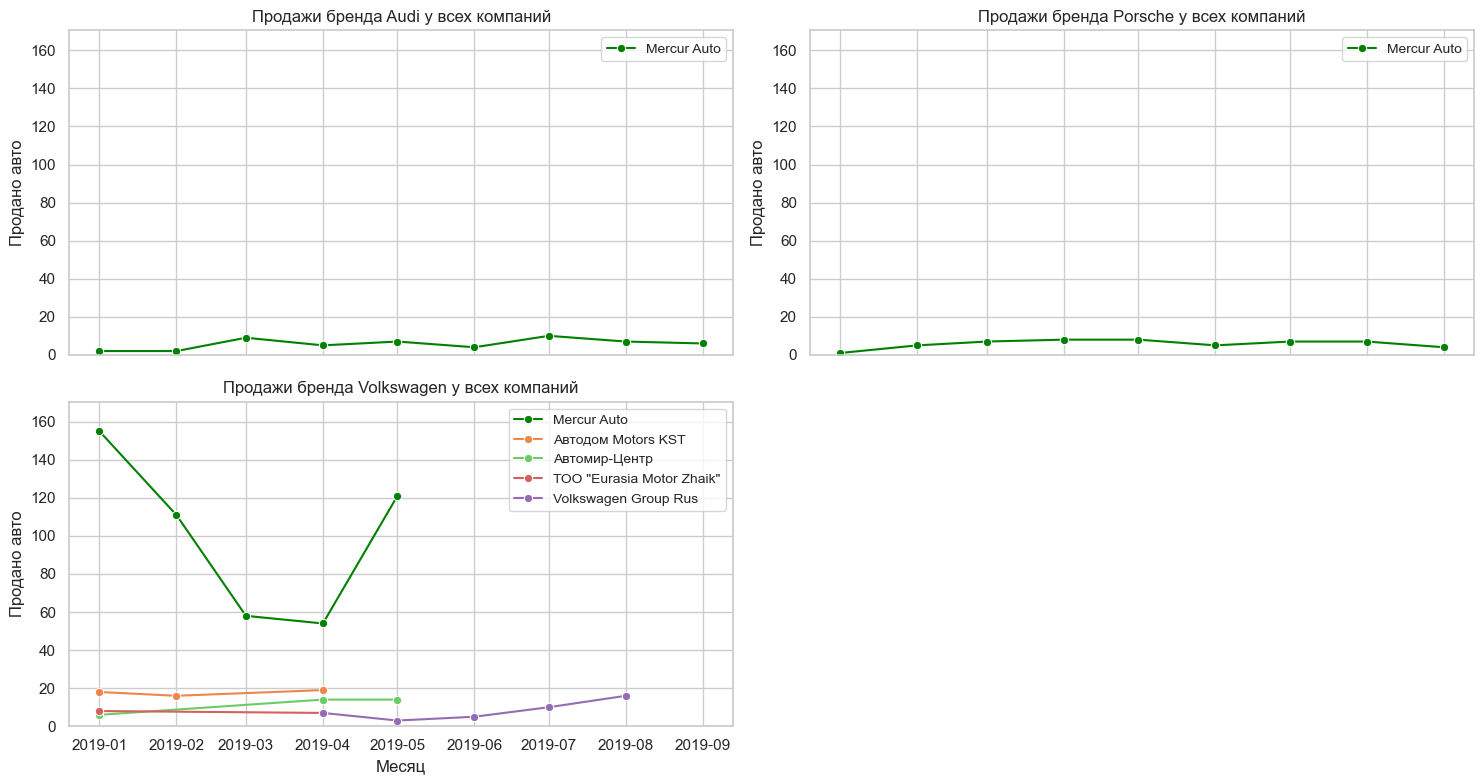

In [159]:
# 1. Находим бренды Mercur Auto
merc_brands = data_query.query("company == 'Mercur Auto'")['brand'].unique()

# 2. Фильтруем данные по всем компаниям и этим брендам
df = data_query[
    (data_query['brand'].isin(merc_brands)) #&
    # (data_query['company'] != 'Mercur Auto')
].copy()

# 3. Создаем столбец "Месяц" для группировки
df['month'] = pd.to_datetime(df['sale_date']).dt.to_period('M').dt.to_timestamp()

# 4. Группируем по бренду, месяцу, компании
grouped = df.groupby(['brand', 'month', 'company'])['quantity'].sum().reset_index()

# 5. Создаем пользовательскую палитру для компаний
# Назначаем зеленый цвет для Mercur Auto, остальные — из стандартной палитры
unique_companies = grouped['company'].unique()
palette = {company: 'green' if company == 'Mercur Auto' else sns.color_palette()[i % len(sns.color_palette())] 
           for i, company in enumerate(unique_companies)}

# 6. Строим графики по каждому бренду
brands = grouped['brand'].unique()  # Получаем уникальные бренды
n_cols = 2  # Количество столбцов для сетки графиков
n_rows = int(np.ceil(len(brands) / n_cols))  # Количество строк, округленное вверх

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 4 * n_rows), sharex=True)  # Создаем сетку подграфиков
axes = axes.flatten()  # Преобразуем массив осей в одномерный для удобства

for i, brand in enumerate(brands):
    ax = axes[i]
    brand_data = grouped[grouped['brand'] == brand]  # Фильтруем данные для текущего бренда
    sns.lineplot(
        data=brand_data, 
        x='month', 
        y='quantity', 
        hue='company', 
        marker='o', 
        ax=ax, 
        palette=palette  # Используем пользовательскую палитру
    )
    ax.set_title(f'Продажи бренда {brand} у всех компаний') 
    ax.set_ylabel('Продано авто')  
    ax.set_xlabel('Месяц') 
    ax.set_ylim(0, grouped['quantity'].max() * 1.1)
    ax.legend(loc='upper right', fontsize='small')

# 7. Удаляем пустые графики (если брендов меньше, чем ячеек в сетке)
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


Мы видим, что по Audi и Porsche конкурентов нет, однако в Voklswagen резкий обрыв с лета. Причем не только у Mercur Auto, но и у других конкурентов. Кроме Volkswagen Group Rus.\
Дело в том, что с 2018 года Mercur Auto из дистрибьютора стал дилером. На рынок пришел Volkswagen Group Rus ["новость"](<https://inbusiness.kz/ru/last/volkswagen-group-rus-vyhodit-na-kazahstanskij-rynok>). С июня 2019 года Volkswagen остался только у официального поставщика.

### Общий вывод по компании Mercur Auto

Компания **Mercur Auto** занимает около **1.5% рынка** по выручке, что делает её заметным, но не доминирующим игроком. Основной фокус — на **розничных (b2c) продажах** премиальных брендов **Volkswagen, Audi и Porsche**. Наиболее массовая модель — **Volkswagen Polo**, обеспечившая значительную часть оборота.

Сравнение с конкурентами показывает, что компании с похожими ценами, такие как **Astana Motors**, **Nissan Manufacturing RUS** и **Allur Auto**, имеют большее количество продаж. Это связано в том числе с потерей доступа к Volkswagen.

Продажи достигли пика в мае 2019 года — свыше **$3 млн**, после чего последовал **резкий спад почти в 3 раза**. Особенно это отразилось на бренде **Volkswagen**, чьи продажи прекратились практически у всех компаний, кроме **Volkswagen Group Rus**. Причина заключается в **изменении структуры дистрибуции**: с июня 2019 года **единственным поставщиком стал Volkswagen Group Rus**. Это объясняет падение объёмов и перераспределение продаж в пользу нового официального дистрибьютора.


## Проверка гипотезы

### Зависимость средних доходов и средней цены авто

Посмотрим, зависит ли цена покупаемых авто от доходов людей в регионе.

In [160]:
# Скачиваем .docx-файл
url = 'https://stat.gov.kz/upload/iblock/ccf/bf8jew5gop2b08nhlabd1wr38jju6otz/Э_26_08_Г%20(2019)_рус.docx'
response = requests.get(url)
doc = docx.Document(BytesIO(response.content)) # доступ к файлу без сохранения на диск или в облако

# Ищем таблицу, в которой в первой строке содержится нужный заголовок
target_table = None
for table in doc.tables:
    first_row_text = ' '.join(cell.text.strip() for cell in table.rows[0].cells)
    if 'Среднедушевые номинальные денежные доходы населения' in first_row_text:
        target_table = table
        break

if target_table is None:
    raise ValueError("Не найдена таблица с нужным заголовком.")

# Читаем строки таблицы
rows = []
for row in target_table.rows:
    text = [cell.text.strip() for cell in row.cells]
    rows.append(text)

# Извлекаем строки с областями и доходами
data_rows = []
for row in rows:
    if len(row) < 2:
        continue
    region = row[0]
    income_str = row[1].replace(' ', '').replace(',', '.')
    if re.match(r'^[А-Яа-яёЁ .\-]+$', region) and not any(x in region for x in ['Республика', 'Max', 'Min']):
        try:
            income = float(income_str)
            data_rows.append([region, income])
        except ValueError:
            continue

#  Создаем DataFrame
income_df = pd.DataFrame(data_rows, columns=['province', 'avg_income_tenge'])
income_df['province'] = income_df['province'].str.strip()

# Просмотр результата
income_df


province  avg_income_tenge
0              Акмолинская          91933.00
1              Актюбинская          92696.00
2              Алматинская          79528.00
3               Атырауская         212571.00
4    Западно-Казахстанская         107202.00
5               Жамбылская          70330.00
6           Карагандинская         106481.00
7             Костанайская          92543.00
8           Кызылординская          76971.00
9            Мангистауская         137539.00
10            Павлодарская         106226.00
11    Северо-Казахстанская          88229.00
12           Туркестанская          52650.00
13  Восточно-Казахстанская          97835.00
14           г. Нур-Султан         162400.00
15               г. Алматы         150380.00
16               г.Шымкент          70202.00

Мы можем сравнить цены по всем регионам, а можем отобрать те, в которых есть хотя бы 30 продаж. Чтобы одиночные аномально высокие или низкие продажи не влияли на результат (например, Туркестанская область с самыми низкими доходами и самыми дорогими автомобилями).\
Отфильтруем.

In [161]:
income_df['province'] = income_df['province'].str.lower().str.replace('г.', '').str.replace('ё', 'е').str.strip()

# Получаем количество продаж по провинциям
province_list = (
    data_query.loc[(data_query['segment'] == 'b2c')].groupby('province')
    .agg(count=('total_usd', 'count'))
    .reset_index()
)

# Оставляем только с количеством продаж > 30
province_list = province_list[province_list['count'] > 30]['province']

# Группируем по province и считаем среднюю цену только для сегмента b2c
avg_price = (
    data_query.loc[(data_query['segment'] == 'b2c')&(data_query['province'].isin(province_list))]
    .groupby('province', as_index=False)['price_usd'].mean()
)


# Нормализуем названия
avg_price['province'] = (
    avg_price['province']
    .str.lower()
    .str.replace('ё', 'е')
    .str.replace(' область', '', regex=False)
    .str.strip()
)

# Также нормализуем province в income_df
income_df['province'] = (
    income_df['province']
    .str.lower()
    .str.replace('г.', '')
    .str.replace('ё', 'е')
    .str.strip()
)

# Объединяем по province
merged = pd.merge(avg_price, income_df, on='province', how='inner')

Коэффициент корреляции: 0.62


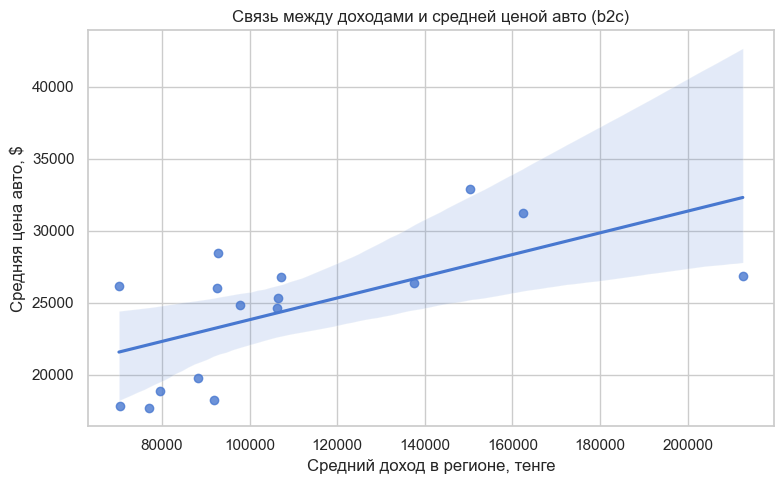

Наблюдается сильная положительная связь: в регионах с более высокими доходами покупают более дорогие автомобили.


In [162]:

# Корреляция
corr, _ = pearsonr(merged['avg_income_tenge'], merged['price_usd'])
print(f"Коэффициент корреляции: {corr:.2f}")

# График
plt.figure(figsize=(8, 5))
sns.regplot(data=merged, x='avg_income_tenge', y='price_usd')
plt.title('Связь между доходами и средней ценой авто (b2c)')
plt.xlabel('Средний доход в регионе, тенге')
plt.ylabel('Средняя цена авто, $')
plt.grid(True)
plt.tight_layout()
plt.show()

if corr > 0.6:
    print("Наблюдается сильная положительная связь: в регионах с более высокими доходами покупают более дорогие автомобили.")
elif corr > 0.3:
    print("Есть умеренная положительная связь между доходами и ценами авто.")
elif corr > 0:
    print("Связь есть, но она слабая.")
else:
    print("Прямая связь между доходами и ценами авто не прослеживается.")

Судя по нашему исследованию, мы можем однозначно утверждать, что между ценами на авто и средними доходами в регионе есть связь.

Посмотрим на таблицу нашего исследования.

In [163]:
merged.sort_values(by='avg_income_tenge', ascending=False)

province  price_usd  avg_income_tenge
4               атырауская   26860.51         212571.00
12              нур-султан   31235.58         162400.00
3                   алматы   32940.51         150380.00
11           мангистауская   26350.50         137539.00
7    западно-казахстанская   26784.69         107202.00
8           карагандинская   25345.53         106481.00
13            павлодарская   24631.78         106226.00
5   восточно-казахстанская   24812.69          97835.00
1              актюбинская   28470.89          92696.00
9             костанайская   26023.45          92543.00
0              акмолинская   18232.66          91933.00
14    северо-казахстанская   19753.56          88229.00
2              алматинская   18855.35          79528.00
10          кызылординская   17668.99          76971.00
6               жамбылская   17831.76          70330.00
15                 шымкент   26157.26          70202.00

Сравнение цен по другим годам могло бы подтверждить или опровергнуть нашу гипотезу.

## Выводы

- Рынок авто Казахстана в 2019 году показал высокую активность и ёмкость — почти 50 тысяч проданных автомобилей на сумму более $1,2 млрд за 9 месяцев.
- Основные игроки — Toyota Motor Kazakhstan, Astana Motors и БИПЭК АВТО, с выраженной специализацией по брендам.
- Большая часть автомобилей производится в Казахстане (около 60%), значительная доля — из России (20%) и Японии (10%). При этом японские автомобили заметно дороже.
- Автомобили с автоматической трансмиссией — самый популярный и более дорогой сегмент, что положительно влияет на выручку дилеров.
- Основной вклад в рынок вносят легковые автомобили и внедорожники; внедорожники приносят на 50% больше выручки за счёт более высокой средней цены.
- Коммерческий транспорт занимает небольшую долю как по количеству, так и по выручке.
- На рынке наблюдается высокая концентрация продаж у топовых дилеров, при этом у мелких компаний часто низкие объёмы продаж, но возможна высокая выручка на единицу авто.
- В июле 2019 года зафиксирован аномальный рост продаж бренда Jac S3, вызванный снижением цены — пример сильного влияния маркетинговых факторов на спрос.
- Компания Mercur Auto занимает около 1.5% рынка, сфокусирована на премиальных брендах Volkswagen, Audi и Porsche, преимущественно в сегменте B2C.
- Продажи Mercur Auto достигли пика в мае, после чего резко упали в связи с изменением структуры дистрибуции Volkswagen — с июня 2019 года официальным поставщиком стала Volkswagen Group Rus, что ограничило доступ дилерам Mercur Auto.
- Сравнение с конкурентами показывает, что компании с похожим ценовым позиционированием имеют больший объём продаж, что указывает на потенциал роста Mercur Auto при решении вопросов с поставками.
- Анализ связи цен на автомобили и средних доходов в регионах выявил явную положительную корреляцию — регионы с низкими доходами имеют низкие средние цены и наоборот. Стоит принимать во внимание доходы в регионе при планировании продаж.